In [1]:
# Imports 
import numpy as np
from numpy import *
from scipy.special import erf
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from scipy.special import factorial2 as fact2
import itertools
import time

In [2]:
# Molecule definition

molecule = 'H2'

# Number of atoms
Nat = 2
# Atomic valencies
Z = [1, 1]
# Number of electrons
Nelec = 2

basis = 'cc-pVDZ'

In [3]:
# Calculation setup

# SCF solver parameters
level_shift = 0.0
damp_p = 2/3
maxit_scf = 500
tol_scf = 10**-6
diis_size_scf = 3

# CC Solver parameters
maxit_cc = 100
tol_cc = 10**-6 
diis_size_cc = 5

# EOM-CC Solver parameters
# Tune number of vectors per state and thresh_vec to prevent eigenvalue collapse to 0
maxit_eom = 100
tol_eom = 10**-8
nstates = 10
nvec_per_state = 1
max_nvec = 1000
thresh_vec = 10**-8
flag_eom_verbose = True
flag_cis_guess = False # seems to make things worse...

# Molecular geometries
num_pts = 300
atom_coordinates = []
RJ = np.linspace(0.7,5,num_pts)
#RJ = np.linspace(2.25,2.35,num_pts)
#RJ = np.array([2.564102564102564])
HOH_angle = np.radians([104.5])

for J in range(num_pts):

    if molecule== 'H2O':
        theta = 0.5*(pi - HOH_angle)
        atom_coordinates.append( [[RJ[J]*np.cos(theta), RJ[J]*np.sin(theta), 0],
                                 [-RJ[J]*np.cos(theta), RJ[J]*np.sin(theta), 0],
                                 [0, 0, 0]] )
    if molecule == 'H2':
        atom_coordinates.append( [[0, 0, -RJ[J]/2],
                                  [0, 0, RJ[J]/2]] )


In [4]:
class BasisFunction:
    ''' A class that contains all our basis function data
            Attributes:
            origin: array/list containing the coordinates of the Gaussian origin
            shell:  tuple of angular momentum
            exps:   list of primitive Gaussian exponents
            coefs:  list of primitive Gaussian coefficients
            norm:   list of normalization factors for Gaussian primitives
    '''
    def __init__(self,origin=[0.0,0.0,0.0],shell=(0,0,0),exps=[],coefs=[]): 
        self.origin = np.asarray(origin)
        self.shell = shell
        self.exps = exps
        self.coefs = coefs
        self.norm = None
        self.normalize()
        
    def normalize(self):
        ''' Routine to normalize the basis functions, in case they
                    do not integrate to unity.
                '''
        l,m,n = self.shell
        L = l+m+n
        # self.norm is a list of length equal to number primitives 
        # normalize primitives first (PGBFs)
        self.norm = np.sqrt(np.power(2,2*(l+m+n)+1.5)*\
                            np.power(self.exps,l+m+n+1.5)/fact2(2*l-1)/fact2(2*m-1)/fact2(2*n-1)/np.power(np.pi,1.5))
        # now normalize the contracted basis functions (CGBFs) # Eq. 1.44 of Valeev integral whitepaper
        prefactor = np.power(np.pi,1.5)*\
                fact2(2*l - 1)*fact2(2*m - 1)*fact2(2*n - 1)/np.power(2.0,L)
        N = 0.0
        num_exps = len(self.exps) 
        for ia in range(num_exps):
            for ib in range(num_exps):
                N += self.norm[ia]*self.norm[ib]*self.coefs[ia]*self.coefs[ib]/np.power(self.exps[ia] + self.exps[ib],L+1.5)
        N *= prefactor
        N = np.power(N,-0.5)
        for ia in range(num_exps):
            self.coefs[ia] *= N
            
    def basisfcn_matrix(self,xdom,ydom,zdom):
        ''' Method that returns a 3-dimensional matrix corresponding to the 
            3D basis function evaluated in space on over a domain (xdom,ydom,zdom)
        '''
        l,m,n = self.shell
        xi = self.exps  
        G = np.zeros((len(xdom),len(ydom),len(zdom)))
        for i in range(len(xi)):
            gauss_x = xdom**l*np.exp(-xi[i]*xdom**2)
            gauss_y = ydom**m*np.exp(-xi[i]*ydom**2)
            gauss_z = zdom**n*np.exp(-xi[i]*zdom**2)
            Temp = np.kron(gauss_z,np.kron(gauss_y,gauss_x))
            G += self.coefs[i]*np.reshape(Temp,[len(xdom),len(ydom),len(zdom)])
            
        return G
            
            
            

In [5]:
def E(i,j,t,Qx,a,b):
    ''' Recursive definition of Hermite Gaussian coefficients.
            Returns a float.
            a: orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b: orbital exponent on Gaussian 'b' (e.g. beta in the text)
            i,j: orbital angular momentum number on Gaussian 'a' and 'b'
            t: number nodes in Hermite (depends on type of integral,
               e.g. always zero for overlap integrals)
            Qx: distance between origins of Gaussian 'a' and 'b'
    '''
    p=a+b
    q = a*b/p
    if (t < 0) or (t > (i + j)): # out of bounds for t
        return 0.0
    elif i == j == t == 0: # base case
        return np.exp(-q*Qx*Qx) # K_AB 
    elif j == 0: # decrement index i
        return (1/(2*p))*E(i-1,j,t-1,Qx,a,b) -  (q*Qx/a)*E(i-1,j,t,Qx,a,b) +  (t+1)*E(i-1,j,t+1,Qx,a,b)
    else: # decrement index j
        return (1/(2*p))*E(i,j-1,t-1,Qx,a,b) +  (q*Qx/b)*E(i,j-1,t,Qx,a,b) +  (t+1)*E(i,j-1,t+1,Qx,a,b)
            
def overlap(a,lmn1,A,b,lmn2,B):
    ''' Evaluates overlap integral between two Gaussians
            Returns a float.
            a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
            lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                  for Gaussian 'a'
            lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
            A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
            B:    list containing origin of Gaussian 'b'
    '''
    l1,m1,n1 = lmn1 # shell angular momentum on Gaussian 'a' 
    l2,m2,n2 = lmn2 # shell angular momentum on Gaussian 'b' 
    S1 = E(l1,l2,0,A[0]-B[0],a,b) # X
    S2 = E(m1,m2,0,A[1]-B[1],a,b) # Y
    S3 = E(n1,n2,0,A[2]-B[2],a,b) # Z
    return S1*S2*S3*np.power(np.pi/(a+b),1.5)

def kinetic(a,lmn1,A,b,lmn2,B):
    ''' Evaluates kinetic energy integral between two Gaussians
            Returns a float.
            a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
            lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                  for Gaussian 'a'
            lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
            A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
            B:    list containing origin of Gaussian 'b'
    '''
    
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    
    term0 = b*(2*(l2+m2+n2)+3)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2),B)
    
    term1 = -2*np.power(b,2)*(overlap(a,(l1,m1,n1),A,b,(l2+2,m2,n2),B) +
                            overlap(a,(l1,m1,n1),A,b,(l2,m2+2,n2),B) +
                            overlap(a,(l1,m1,n1),A,b,(l2,m2,n2+2),B))
    
    term2 = -0.5*(l2*(l2-1)*overlap(a,(l1,m1,n1),A,b,(l2-2,m2,n2),B) +
                  m2*(m2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2-2,n2),B) +
                  n2*(n2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2-2),B)) 
    
    return term0+term1+term2

def R(t,u,v,n,p,PCx,PCy,PCz,RPC):
    ''' Returns the Coulomb auxiliary Hermite integrals
            Returns a float.
            Arguments:
            t,u,v:   order of Coulomb Hermite derivative in x,y,z
                     (see defs in Helgaker and Taylor)
            n:       order of Boys function
            PCx,y,z: Cartesian vector distance between Gaussian
                     composite center P and nuclear center C
            RPC:     Distance between P and C
    '''
    T = p*RPC*RPC
    val = 0.0
    if t == u == v == 0:
        val += np.power(-2*p,n)*boys(n,T) 
    elif t == u == 0:
        if v > 1:
            val += (v-1)*R(t,u,v-2,n+1,p,PCx,PCy,PCz,RPC)
        val += PCz*R(t,u,v-1,n+1,p,PCx,PCy,PCz,RPC) 
    elif t == 0:
        if u > 1:
            val += (u-1)*R(t,u-2,v,n+1,p,PCx,PCy,PCz,RPC)
        val += PCy*R(t,u-1,v,n+1,p,PCx,PCy,PCz,RPC) 
    else:
        if t > 1:
            val += (t-1)*R(t-2,u,v,n+1,p,PCx,PCy,PCz,RPC)
        val += PCx*R(t-1,u,v,n+1,p,PCx,PCy,PCz,RPC) 
    return val

from scipy.special import hyp1f1
def boys(n,T):
    return hyp1f1(n+0.5,n+1.5,-T)/(2.0*n+1.0)

def gaussian_product_center(a,A,b,B): 
    return (a*A+b*B)/(a+b)

def nuclear_attraction(a,lmn1,A,b,lmn2,B,C):
    ''' Evaluates kinetic energy integral between two Gaussians
             Returns a float.
             a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
             b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
             lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                   for Gaussian 'a'
             lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
             A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
             B:    list containing origin of Gaussian 'b'
             C:    list containing origin of nuclear center 'C'
    '''
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    p=a+b
    P = gaussian_product_center(a,A,b,B) # Gaussian composite center 
    RPC = np.linalg.norm(P-C)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                 val += E(l1,l2,t,A[0]-B[0],a,b) * E(m1,m2,u,A[1]-B[1],a,b) * E(n1,n2,v,A[2]-B[2],a,b) * \
                    R(t,u,v,0,p,P[0]-C[0],P[1]-C[1],P[2]-C[2],RPC)
    val *= 2*np.pi/p 
    return val

def electron_repulsion(a,lmn1,A,b,lmn2,B,c,lmn3,C,d,lmn4,D): 
    ''' Evaluates kinetic energy integral between two Gaussians
         Returns a float.
         a,b,c,d:   orbital exponent on Gaussian 'a','b','c','d'
         lmn1,lmn2
         lmn3,lmn4: int tuple containing orbital angular momentum
                    for Gaussian 'a','b','c','d', respectively
         A,B,C,D:   list containing origin of Gaussian 'a','b','c','d'
    '''
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    l3,m3,n3 = lmn3
    l4,m4,n4 = lmn4
    p = a+b # composite exponent for P (from Gaussians 'a' and 'b') 
    q = c+d # composite exponent for Q (from Gaussians 'c' and 'd') 
    alpha = p*q/(p+q)
    P = gaussian_product_center(a,A,b,B) # A and B composite center 
    Q = gaussian_product_center(c,C,d,D) # C and D composite center 
    RPQ = np.linalg.norm(P-Q)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                for tau in range(l3+l4+1): 
                    for nu in range(m3+m4+1):
                        for phi in range(n3+n4+1):
                            val += E(l1,l2,t,A[0]-B[0],a,b) * \
                                    E(m1,m2,u,A[1]-B[1],a,b) * \
                                    E(n1,n2,v,A[2]-B[2],a,b) * \
                                    E(l3,l4,tau,C[0]-D[0],c,d) * \
                                    E(m3,m4,nu ,C[1]-D[1],c,d) * \
                                    E(n3,n4,phi,C[2]-D[2],c,d) * \
                                    np.power(-1,tau+nu+phi) * \
                                    R(t+tau,u+nu,v+phi,0,\
                                        alpha,P[0]-Q[0],P[1]-Q[1],P[2]-Q[2],RPQ)
    val *= 2*np.power(np.pi,2.5)/(p*q*np.sqrt(p+q)) 
    return val

In [6]:
def S(a,b):
    '''Evaluates overlap between two contracted Gaussians
           Returns float.
           Arguments:
           a: contracted Gaussian 'a', BasisFunction object
           b: contracted Gaussian 'b', BasisFunction object
    '''
    s = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            s += a.norm[ia]*b.norm[ib]*ca*cb*\
                 overlap(a.exps[ia],a.shell,a.origin,
                 b.exps[ib],b.shell,b.origin)
    return s

def T(a,b):
    '''Evaluates kinetic energy between two contracted Gaussians
           Returns float.
           Arguments:
           a: contracted Gaussian 'a', BasisFunction object
           b: contracted Gaussian 'b', BasisFunction object
    '''
    t = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            t += a.norm[ia]*b.norm[ib]*ca*cb*kinetic(a.exps[ia],a.shell,a.origin,b.exps[ib],b.shell,b.origin)
    return t

def V(a,b,C,Z):
    '''Evaluates overlap between two contracted Gaussians
            Returns float.
            Arguments:
            a: contracted Gaussian 'a', BasisFunction object
            b: contracted Gaussian 'b', BasisFunction object
            C: center of nucleus
    '''
    v = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            v += a.norm[ia]*b.norm[ib]*ca*cb*nuclear_attraction(a.exps[ia],a.shell,a.origin,b.exps[ib],b.shell,b.origin,C)
    return -v*Z

def ERI(a,b,c,d):
    '''Evaluates overlap between two contracted Gaussians
            Returns float.
            Arguments:
            a: contracted Gaussian 'a', BasisFunction object
            b: contracted Gaussian 'b', BasisFunction object
            c: contracted Gaussian 'b', BasisFunction object
            d: contracted Gaussian 'b', BasisFunction object
    '''
    eri = 0.0
    for ja, ca in enumerate(a.coefs):
        for jb, cb in enumerate(b.coefs):
            for jc, cc in enumerate(c.coefs):
                for jd, cd in enumerate(d.coefs):
                    eri += a.norm[ja]*b.norm[jb]*c.norm[jc]*d.norm[jd]*\
                           ca*cb*cc*cd*\
                           electron_repulsion(a.exps[ja],a.shell,a.origin,\
                                b.exps[jb],b.shell,b.origin,\
                                c.exps[jc],c.shell,c.origin,\
                                d.exps[jd],d.shell,d.origin)
    return eri

In [7]:
#### General Functions ####

def construct_orbitals(SHELL, XI, CM, atom_coordinates):
    orbs = []; Nat = len(SHELL);
    for i in range(Nat):
        for j in range(len(XI[i])):
            orbs.append(BasisFunction(origin=atom_coordinates[i][:],shell=SHELL[i][j],exps=XI[i][j],coefs=CM[i][j]))
    return orbs

def ao_to_mo(AO,C):
    if len(AO.shape) == 2:
        T1 = np.einsum('jb,ij->ib',C,AO,optimize=True)
        T2 = np.einsum('ia,ib->ab',C,T1,optimize=True)
        return T2
    else:
        T1 = np.einsum('ld,ijkl->ijkd',C,AO,optimize=True)
        T2 = np.einsum('kc,ijkd->ijcd',C,T1,optimize=True)
        T3 = np.einsum('jb,ijcd->ibcd',C,T2,optimize=True)
        T4 = np.einsum('ia,ibcd->abcd',C,T3,optimize=True)
        return T4

def spatial_to_spinorb(MO):
    Norb = MO.shape[0]
    if len(MO.shape) == 2:
        MO_sp = np.zeros((2*Norb,2*Norb))
        for i in range(2*Norb):
            for j in range(2*Norb):
                if i%2 == j%2:    
                    i0 = int(np.floor(i/2))
                    j0 = int(np.floor(j/2))
                    MO_sp[i,j] = MO[i0,j0]
            
    else:
        MO_sp = np.zeros((2*Norb,2*Norb,2*Norb,2*Norb))
        for i in range(2*Norb):
            for j in range(2*Norb):
                for k in range(2*Norb):
                    for l in range(2*Norb):
                        if i%2 == k%2 and j%2 == l%2:
                            i0 = int(np.floor(i/2))
                            j0 = int(np.floor(j/2))
                            k0 = int(np.floor(k/2))
                            l0 = int(np.floor(l/2))
                            MO_sp[i,j,k,l] = MO[i0,j0,k0,l0]
    return MO_sp
                
def diis_pulay_solver(X_list,diis_resid_list):
        B_dim = len(X_list) + 1
        B = np.empty((B_dim, B_dim))
        B[-1, :] = -1
        B[:, -1] = -1
        B[-1, -1] = 0
        for i in range(len(X_list)):
            for j in range(i,len(X_list)):
                B[i, j] = np.einsum('ij,ij->', diis_resid_list[i], diis_resid_list[j], optimize=True)
                B[j, i] = B[i, j]

        # Build RHS of Pulay equation 
        rhs = np.zeros((B_dim))
        rhs[-1] = -1

        # Solve Pulay equation for c_i's 
        if np.linalg.det(B) != 0:
            coeff = np.linalg.solve(B, rhs)
            # Build DIIS Fock matrix 
            X = np.zeros_like(X_list[0])
            for x in range(B_dim - 1):
                X += coeff[x] * X_list[x]
            return X
        else:
            return X_list[-1]

In [8]:
#### SCF Functions ####

def calculate_onebody_ints(orbs,atom_coordinates):
    # Number of spatial orbitals
    Norb = len(orbs)
    # Allocate 
    Smat = np.zeros((Norb,Norb))
    Tmat = np.zeros((Norb,Norb))
    Vmat = np.zeros((Norb,Norb))
    # Calculate onebody integrals
    for i in range(Norb):
        for j in range(i,Norb):
            Smat[i,j] = S(orbs[i],orbs[j])
            Tmat[i,j] = T(orbs[i],orbs[j])
            for k in range(Nat):
                Vmat[i,j] += V(orbs[i],orbs[j],atom_coordinates[k][:],Z[k])
            Smat[j,i] = Smat[i,j]
            Tmat[j,i] = Tmat[i,j]
            Vmat[j,i] = Vmat[i,j]
    return Smat,Tmat,Vmat

def calculate_twobody_ints(orbs,vec):
    
    Norb = len(orbs)
    VVmat = np.zeros((Norb,Norb,Norb,Norb))
    
    if vec: # slower?
        num_twobody = int(Norb*(Norb+1)*(Norb**2+Norb+2)/8)
        VVmatvec = np.zeros(num_twobody)
        # Calculate only permutationally unique twobody integrals
        ct = 0
        for i in range(Norb):
            for j in range(i+1):
                for k in range(i+1):
                    if i == k: 
                        lmax = j+1 
                    else: 
                        lmax = k+1
                    for l in range(lmax):
                        VVmatvec[ct] = ERI(orbs[i],orbs[j],orbs[k],orbs[l]) # chemist notation
                        ct += 1
        # Insert unique integrals into 4-dimensional array
        for i in range(Norb):
            for j in range(Norb):
                if i > j: 
                    ij = i*(i+1)/2+j 
                else: 
                    ij = j*(j+1)/2 + i
                for k in range(Norb):
                    for l in range(Norb):
                        if k > l: 
                            kl = k*(k+1)/2+l 
                        else: 
                            kl = l*(l+1)/2 + k
                        if ij > kl: 
                            ijkl = ij*(ij+1)/2 + kl 
                        else: 
                            ijkl = kl*(kl+1)/2 + ij       
                        VVmat[i,k,j,l] = VVmatvec[int(ijkl)] # physics notation
        return VVmat,VVmatvec
    else:
        # Calculate twobody integrals
        for i in range(Norb):
            for j in range(i+1):
                ij = i*(i+1)/2 + j
                for k in range(Norb):
                    for l in range(k+1):
                        kl = k*(k+1)//2 + l
                        if ij >= kl:
                            val = ERI(orbs[i],orbs[j],orbs[k],orbs[l])
                            VVmat[i,k,j,l] = val
                            VVmat[j,k,i,l] = val
                            VVmat[i,l,j,k] = val
                            VVmat[k,i,l,j] = val
                            VVmat[l,i,k,j] = val
                            VVmat[l,j,k,i] = val
                            VVmat[j,l,i,k] = val
                            VVmat[k,j,l,i] = val
        return VVmat

def calc_nuclear_nuclear(atom_coordinates,Z):
    Vnn = 0.0
    Nat = len(atom_coordinates)
    for i in range(Nat):
        for j in range(Nat):
            if i != j:
                Ri = np.asarray(atom_coordinates[i][:])
                Rj = np.asarray(atom_coordinates[j][:])
                Vnn += Z[i]*Z[j]/np.linalg.norm(Ri-Rj)
    return Vnn/2

def orthomat(S,tol,kind):
    evalS, U = np.linalg.eigh(S)
    diagS_minushalf = np.diag(evalS**(-0.5))
    if kind == 'symmetric':
        X0 = np.dot(U,np.dot(diagS_minushalf,U.T))
    else:
        X0 = np.dot(U,diagS_minushalf)
        
    idX = [i for i in range(S.shape[0])]
    for i in range(S.shape[0]):
        for j in range(i+1,S.shape[0]):
            if np.abs(evalS[i]-evalS[j]) < tol:
                J = idX.index(j)
                idX.remove(J)
    X = X0[:,idX]
    return X

In [9]:
#### CCSD Functions ####

def cc_energy(t1,t2,VM,FM,Nocc):
    Ecc = np.einsum('ia,ai->',FM[:Nocc,Nocc:],t1,optimize=True) +\
          0.25*np.einsum('ijab,abij->',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) +\
          0.5*np.einsum('jb,bj->',np.einsum('ijab,ai->jb',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True),t1,optimize=True)
    return Ecc
                
def t1_fcn(t1,t2,VM,FM,Nocc,Nunocc):
    
    # Fock masks to zero diagonal
    Zocc = np.ones((Nocc,Nocc)) - np.eye(Nocc)
    Zunocc = np.ones((Nunocc,Nunocc)) - np.eye(Nunocc)
    
    # Intermediates
    chi_me = FM[:Nocc,Nocc:] + np.einsum('mnef,fn->me',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_mi = FM[:Nocc,:Nocc]*Zocc + \
             np.einsum('mnif,fn->mi',VM[:Nocc,:Nocc,:Nocc,Nocc:],t1,optimize=True)+ \
             0.5*np.einsum('mnef,efin->mi',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    
    chi_ae = FM[Nocc:,Nocc:]*Zunocc + \
             np.einsum('anef,fn->ae',VM[Nocc:,:Nocc,Nocc:,Nocc:],t1,optimize=True) - \
             0.5*np.einsum('mnef,afmn->ae',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) - \
             np.einsum('me,am->ae',chi_me,t1,optimize=True)
    
    TEMP1 = FM[Nocc:,:Nocc] + \
            np.einsum('me,aeim->ai',chi_me,t2,optimize=True) - \
            np.einsum('maie,em->ai',VM[:Nocc,Nocc:,:Nocc,Nocc:],t1,optimize=True) -\
            np.einsum('mi,am->ai',chi_mi,t1,optimize=True) + \
            np.einsum('ae,ei->ai',chi_ae,t1,optimize=True) - \
            0.5*np.einsum('mnif,afmn->ai',VM[:Nocc,:Nocc,:Nocc,Nocc:],t2,optimize=True) + \
            0.5*np.einsum('anef,efin->ai',VM[Nocc:,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    

    return TEMP1

def t2_fcn(t1,t2,VM,FM,Nocc,Nunocc):
    
    # Fock masks to zero diagonal
    Zocc = np.ones((Nocc,Nocc)) - np.eye(Nocc)
    Zunocc = np.ones((Nunocc,Nunocc)) - np.eye(Nunocc)
    
    # Intermediates    
    chi_mi = FM[:Nocc,:Nocc]*Zocc + \
             np.einsum('mnif,fn->mi',VM[:Nocc,:Nocc,:Nocc,Nocc:],t1,optimize=True)+ \
             np.einsum('mnef,efin->mi',0.5*VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    
    chi_me = FM[:Nocc,Nocc:] + np.einsum('mnef,fn->me',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_ae = FM[Nocc:,Nocc:]*Zunocc + \
             np.einsum('anef,fn->ae',VM[Nocc:,:Nocc,Nocc:,Nocc:],t1,optimize=True) - \
             0.5*np.einsum('mnef,afmn->ae',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) - \
             np.einsum('me,am->ae',chi_me,t1,optimize=True)
    
    chit_mi = chi_mi + np.einsum('me,ei->mi',chi_me,t1,optimize=True)
    
    chit_anef = VM[Nocc:,:Nocc,Nocc:,Nocc:] - \
                0.5*np.einsum('mnef,am->anef',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_anej = VM[Nocc:,:Nocc,Nocc:,:Nocc] - \
               0.5*np.einsum('mnej,am->anej',VM[:Nocc,:Nocc,Nocc:,:Nocc],t1,optimize=True) + \
               0.5*np.einsum('anef,fj->anej',chit_anef,t1,optimize=True)
    
    chi_mnif = VM[:Nocc,:Nocc,:Nocc,Nocc:] + \
               0.5*np.einsum('mnef,ei->mnif',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_mbij = VM[:Nocc,Nocc:,:Nocc,:Nocc] - \
                0.5*np.einsum('mnij,bn->mbij',VM[:Nocc,:Nocc,:Nocc,:Nocc],t1,optimize=True) - \
                0.5*np.einsum('bmef,efij->mbij',chit_anef,t2,optimize=True)
    
    chi_abej = 0.5*VM[Nocc:,Nocc:,Nocc:,:Nocc] - np.einsum('anej,bn->abej',chi_anej,t1,optimize=True)
    
    chi_mnij = 0.5*VM[:Nocc,:Nocc,:Nocc,:Nocc] + \
               0.25*np.einsum('mnef,efij->mnij',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) + \
               np.einsum('mnif,fj->mnij',chi_mnif,t1,optimize=True)
    
    chi_anef = chit_anef - 0.5*np.einsum('mnef,am->anef',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chit_anej = VM[Nocc:,:Nocc,Nocc:,:Nocc] - \
                np.einsum('mnej,am->anej',VM[:Nocc,:Nocc,Nocc:,:Nocc],t1,optimize=True) - \
                0.5*np.einsum('mnef,afmj->anej',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) +\
                np.einsum('anef,fj->anej',chi_anef,t1,optimize=True)
    
    chi_efij = np.einsum('ei,fj->efij',t1,t1,optimize=True) + 0.5*t2
    
    # standard order
    TEMP2 = np.einsum('abej,ei->abij',chi_abej,t1,optimize=True) - \
            np.einsum('anej,ebin->abij',chit_anej,t2,optimize=True) - \
            0.5*np.einsum('mbij,am->abij',chi_mbij,t1,optimize=True) + \
            0.5*np.einsum('ae,ebij->abij',chi_ae,t2,optimize=True) - \
            0.5*np.einsum('mi,abmj->abij',chit_mi,t2,optimize=True) + \
            0.25*np.einsum('mnij,abmn->abij',chi_mnij,t2,optimize=True) +\
            0.25*np.einsum('abef,efij->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True) 
    # (ij)
    TEMP2_ij = np.einsum('abei,ej->abij',chi_abej,t1,optimize=True) - \
               np.einsum('anei,ebjn->abij',chit_anej,t2,optimize=True) - \
               0.5*np.einsum('mbji,am->abij',chi_mbij,t1,optimize=True) + \
               0.5*np.einsum('ae,ebji->abij',chi_ae,t2,optimize=True) - \
            0.5*np.einsum('mj,abmi->abij',chit_mi,t2,optimize=True) + \
               0.25*np.einsum('mnji,abmn->abij',chi_mnij,t2,optimize=True) +\
            0.25*np.einsum('abef,efji->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True) 
    # (ab)
    TEMP2_ab = np.einsum('baej,ei->abij',chi_abej,t1,optimize=True) - \
               np.einsum('bnej,eain->abij',chit_anej,t2,optimize=True) - \
               0.5*np.einsum('maij,bm->abij',chi_mbij,t1,optimize=True) + \
               0.5*np.einsum('be,eaij->abij',chi_ae,t2,optimize=True) - \
            0.5*np.einsum('mi,bamj->abij',chit_mi,t2,optimize=True) + \
               0.25*np.einsum('mnij,bamn->abij',chi_mnij,t2,optimize=True) +\
            0.25*np.einsum('baef,efij->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True)
    # (ij)(ab)
    TEMP2_abij = np.einsum('baei,ej->abij',chi_abej,t1,optimize=True) - \
                 np.einsum('bnei,eajn->abij',chit_anej,t2,optimize=True) - \
                 0.5*np.einsum('maji,bm->abij',chi_mbij,t1,optimize=True) + \
                 0.5*np.einsum('be,eaji->abij',chi_ae,t2,optimize=True) - \
                 0.5*np.einsum('mj,bami->abij',chit_mi,t2,optimize=True) + \
                0.25*np.einsum('mnji,bamn->abij',chi_mnij,t2,optimize=True) +\
                 0.25*np.einsum('baef,efji->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True)  
    
    return VM[Nocc:,Nocc:,:Nocc,:Nocc] + TEMP2 - TEMP2_ij - TEMP2_ab + TEMP2_abij

def t1_update(t1,t2,VM,FM,occ,unocc):
    Nocc = len(occ)
    Nunocc = len(unocc)
    X_ai = t1_fcn(t1,t2,VM,FM,Nocc,Nunocc)
    for a in range(Nunocc):
        for i in range(Nocc):
            D_ai = FM[occ[i],occ[i]]-FM[unocc[a],unocc[a]]
            t1[a,i] = X_ai[a,i]/D_ai
    return t1

def t2_update(t1,t2,VM,FM,occ,unocc):
    Nocc = len(occ)
    Nunocc = len(unocc)
    X_abij = t2_fcn(t1,t2,VM,FM,Nocc,Nunocc)
    for a in range(Nunocc):
        for b in range(a+1,Nunocc):
            for i in range(Nocc):
                for j in range(i+1,Nocc):
                    D2_abij = FM[occ[i],occ[i]]+FM[occ[j],occ[j]]-FM[unocc[a],unocc[a]]-FM[unocc[b],unocc[b]]
                    t2[a,b,i,j] = X_abij[a,b,i,j]/D2_abij
                    t2[b,a,i,j] = -t2[a,b,i,j]
                    t2[a,b,j,i] = -t2[a,b,i,j]
                    t2[b,a,j,i] = t2[a,b,i,j]
    return t2

In [10]:
#### EOM-CCSD Functions ####

def gramschmidt(A):
    """ Gram-Schmidt orthogonalization of column-vectors. Matrix A passes
    vectors in its columns, orthonormal system is returned in columns of
    matrix Q. """
    _, k = A.shape

    # first basis vector
    Q = A[:, [0]] / np.linalg.norm(A[:, 0])
    for j in range(1, k):
        # orthogonal projection, loop-free implementation
        q = A[:, j] - np.dot(Q, np.dot(Q.T, A[:, j]))

        # check premature termination
        nq = np.linalg.norm(q)
        if nq < 1e-9 * np.linalg.norm(A[:, j]):
            break
        # add new basis vector as another column of Q
        Q = np.column_stack([Q, q / nq])
    return Q


def cis_hamiltonian(FM,VM,H00,occ,unocc):
    
    Nocc = len(occ)
    Nunocc = len(unocc)
    Nov = Nocc*Nunocc
    
    def swapPositions(s0, pos1, pos2): 
        s02 = s0.copy()
        s02[pos1] = s0[pos2]
        s02[pos2] = s0[pos1]
        return s02

    def singleExcList(s0,iocc,iunocc):
        singleExc = []
        singleExcIdx = []
        for i in iocc:
            for j in iunocc:
                singleExc.append(swapPositions(s0,i,j))
                singleExcIdx.append([i, j])
        return singleExc, singleExcIdx
    
    # singles excitation determinant list
    s0 = np.concatenate( (np.ones_like(occ),np.zeros_like(unocc)), axis=0)
    singles, singleIdx = singleExcList(s0,occ,unocc)
    
    # reference-reference block
    H00 = np.array([H00])[:,np.newaxis]
    
    # singles-reference block
    HS0 = np.zeros(Nov)[:,np.newaxis]
    one_body = 0
    for a in range(len(singles)):
        D1 = singles[a]
        I = singleIdx[a][0]
        A = singleIdx[a][1]
        HS0[a,0] += FM[A,I]
            
    # singles-singles block
    HSS = np.zeros((Nov,Nov))
    for a in range(len(singles)):
        D1 = singles[a]
        I = singleIdx[a][0]
        A = singleIdx[a][1]
        for b in range(len(singles)):
            D2 = singles[b]
            J = singleIdx[b][0]
            B = singleIdx[b][1]
            HSS[a,b] = FM[A,B]*(I==J) - FM[I,J]*(A==B) + VM[A,J,I,B]
            
                       
    H_CIS = np.concatenate((np.concatenate((H00,HS0.T),axis=1),np.concatenate((HS0,HSS),axis=1)),axis=0)
                                              
    return H_CIS

def cis_guess(H_CIS,Nocc,Nunocc):
    omega,V = np.linalg.eigh(H_CIS)
    omega = omega[1:]
    V = V[1:,1:]
    idx = omega.argsort()
    omega = omega[idx]
    V = V[:,idx]
    return omega,V


def Hbar_diagonal(t1,t2,VM,FM,occ,unocc):
    
    Nocc = len(occ)
    Nunocc = len(unocc)
    
    foo = FM[:Nocc,:Nocc]
    fvv = FM[Nocc:,Nocc:]
    fov = FM[:Nocc,Nocc:]
    Vvovv = VM[Nocc:,:Nocc,Nocc:,Nocc:]
    Voovv = VM[:Nocc,:Nocc,Nocc:,Nocc:]
    Vooov = VM[:Nocc,:Nocc,:Nocc,Nocc:]
    Vovvv = VM[:Nocc,Nocc:,Nocc:,Nocc:]
    Voovo = VM[:Nocc,:Nocc,Nocc:,:Nocc]
    Vovvo = VM[:Nocc,Nocc:,Nocc:,:Nocc]
    Vvvvv = VM[Nocc:,Nocc:,Nocc:,Nocc:]
    Voooo = VM[:Nocc,:Nocc,:Nocc,:Nocc]
    
    taubar = t2 + 0.25*(np.einsum('ai,bj->abij',t1,t1,optimize=True) - \
                        np.einsum('aj,bi->abij',t1,t1,optimize=True) - \
                        np.einsum('bi,aj->abij',t1,t1,optimize=True) + \
                        np.einsum('bj,ai->abij',t1,t1,optimize=True)) 
    
    tau = t2 + 0.5*(np.einsum('ai,bj->abij',t1,t1,optimize=True) - \
                np.einsum('aj,bi->abij',t1,t1,optimize=True) - \
                np.einsum('bi,aj->abij',t1,t1,optimize=True) + \
                np.einsum('bj,ai->abij',t1,t1,optimize=True)) 

    Fbar_ae =   fvv - \
                0.5*np.einsum('me,am->ae',fov,t1,optimize=True) + \
                np.einsum('amef,fm->ae',Vvovv,t1,optimize=True) - \
                0.5*np.einsum('afmn,mnef->ae',taubar,Voovv,optimize=True)
                
    Fbar_mi = foo + \
              0.5*np.einsum('me,ei->mi',fov,t1,optimize=True)  + \
              np.einsum('mnie,en->mi',Vooov,t1,optimize=True) + \
              0.5*np.einsum('mnef,efin->mi',Voovv,taubar,optimize=True)
                
    Fbar_me = fov + np.einsum('mnef,fn->me',Voovv,t1,optimize=True)
    
    Wbar_mbej = Vovvo + \
            np.einsum('mbef,fj->mbej',Vovvv,t1,optimize=True) - \
            np.einsum('mnej,bn->mbej',Voovo,t1,optimize=True) - \
            0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True) - \
            np.einsum('mnej,bn->mbej',np.einsum('mnef,fj->mnej',Voovv,t1,optimize=True),t1,optimize=True)
    
    F_ae = Fbar_ae - 0.5*np.einsum('me,am->ae',Fbar_me,t1,optimize=True)
    
    F_mi = Fbar_mi + 0.5*np.einsum('me,ei->mi',Fbar_me,t1,optimize=True)
    
    W_mbej = Wbar_mbej - 0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True)
    
    Wbar_mnij = Voooo + \
                np.einsum('mnie,ej->mnij',Vooov,t1,optimize=True) - np.einsum('mnje,ei->mnij',Vooov,t1,optimize=True) + \
                0.25*np.einsum('mnef,efij->mnij',Voovv,tau,optimize=True)
        
    Wbar_abef = Vvvvv -\
                np.einsum('amef,bm->abef',Vvovv,t1,optimize=True) + np.einsum('bmef,am->abef',Vvovv,t1,optimize=True) + \
                0.25*np.einsum('mnef,abmn->abef',Voovv,tau,optimize=True)
            
    W_mnij = Wbar_mnij + 0.25*np.einsum('mnef,efij->mnij',Voovv,tau,optimize=True)
    
    W_abef = Wbar_abef + 0.25*np.einsum('mnef,abmn->abef',Voovv,tau,optimize=True)
    
    Dia = np.zeros((Nunocc,Nocc))
    Dijab = np.zeros((Nunocc,Nunocc,Nocc,Nocc))
    
    for a in range(Nunocc):
        for i in range(Nocc):
            Dia[a,i] += F_ae[a,a] - F_mi[i,i]
            Dia[a,i] -= W_mbej[i,a,a,i]
            for b in range(Nunocc):
                for j in range(Nocc):
                    Dijab[a,b,i,j] += F_ae[a,a] + F_ae[b,b] - F_mi[i,i] - F_mi[j,j]
                    Dijab[a,b,i,j] -= W_mbej[i,b,b,i] + W_mbej[j,b,b,j] + W_mbej[i,a,a,i] + W_mbej[j,a,a,j] 
                    Dijab[a,b,i,j] += W_abef[a,b,a,b] + W_mnij[i,j,i,j]
                    for l in range(Nocc):
                        Dijab[a,b,i,j] -= 0.5*(VM[occ[j],occ[l],unocc[a],unocc[b]]*t2[a,b,j,l] + \
                                               VM[occ[i],occ[l],unocc[a],unocc[b]]*t2[a,b,i,l])
                    for d in range(Nunocc):
                        Dijab[a,b,i,j] -= 0.5*(VM[occ[i],occ[j],unocc[b],unocc[d]]*t2[b,d,i,j] + \
                                               VM[occ[i],occ[j],unocc[a],unocc[d]]*t2[a,d,i,j])
    
        
    # Build Approximate Diagonal of Hbar
#     Dia = -F_mi.diagonal().reshape(-1, 1) + F_ae.diagonal()
    
#     Dijab = -F_mi.diagonal().reshape(-1, 1, 1, 1) - F_mi.diagonal().reshape(-1, 1, 1) + F_ae.diagonal().reshape(-1, 1) + F_ae.diagonal()
    
    D = np.hstack((Dia.flatten(), Dijab.flatten()))
    return D
    

def sigma_fcn(r1,r2,t1,t2,VM,FM,Nocc,Nunocc):
    
    fvo = FM[Nocc:,:Nocc]
    fov = FM[:Nocc,Nocc:]
    foo = FM[:Nocc,:Nocc]
    fvv = FM[Nocc:,Nocc:]
    
    Vovvv = VM[:Nocc,Nocc:,Nocc:,Nocc:]
    Voovv = VM[:Nocc,:Nocc,Nocc:,Nocc:]
    Vooov = VM[:Nocc,:Nocc,:Nocc,Nocc:]
    Vovvv = VM[:Nocc,Nocc:,Nocc:,Nocc:]
    Vovov = VM[:Nocc,Nocc:,:Nocc,Nocc:]
    Vvoov = VM[Nocc:,:Nocc,:Nocc,Nocc:]
    Vvovo = VM[Nocc:,:Nocc,Nocc:,:Nocc]
    Voovo = VM[:Nocc,:Nocc,Nocc:,:Nocc]
    Vvovv = VM[Nocc:,:Nocc,Nocc:,Nocc:]
    Vvvvv = VM[Nocc:,Nocc:,Nocc:,Nocc:]
    Vvooo = VM[Nocc:,:Nocc,:Nocc,:Nocc]
    Voooo = VM[:Nocc,:Nocc,:Nocc,:Nocc]
    Vvvov = VM[Nocc:,Nocc:,:Nocc,Nocc:]
    Vvvvo = VM[Nocc:,Nocc:,Nocc:,:Nocc]
    Vovoo = VM[:Nocc,Nocc:,:Nocc,:Nocc]
    Vovvo = VM[:Nocc,Nocc:,Nocc:,:Nocc]
    
    # Matrix elements and equations by my derivation, confirmed with
    # Gauss & Stanton, J. Chem. Phys. 103, 3561 (1995)
    
    # Intermediates
    
    tau = t2 + 0.5*(np.einsum('ai,bj->abij',t1,t1,optimize=True) - \
                    np.einsum('aj,bi->abij',t1,t1,optimize=True) - \
                    np.einsum('bi,aj->abij',t1,t1,optimize=True) + \
                    np.einsum('bj,ai->abij',t1,t1,optimize=True)) 
    
    taubar = t2 + 0.25*(np.einsum('ai,bj->abij',t1,t1,optimize=True) - \
                        np.einsum('aj,bi->abij',t1,t1,optimize=True) - \
                        np.einsum('bi,aj->abij',t1,t1,optimize=True) + \
                        np.einsum('bj,ai->abij',t1,t1,optimize=True)) 

    Fbar_ae =   fvv - \
                0.5*np.einsum('me,am->ae',fov,t1,optimize=True) + \
                np.einsum('amef,fm->ae',Vvovv,t1,optimize=True) - \
                0.5*np.einsum('afmn,mnef->ae',taubar,Voovv,optimize=True)
                
    Fbar_mi = foo + \
              0.5*np.einsum('me,ei->mi',fov,t1,optimize=True)  + \
              np.einsum('mnie,en->mi',Vooov,t1,optimize=True) + \
              0.5*np.einsum('mnef,efin->mi',Voovv,taubar,optimize=True)
                
    Fbar_me = fov + np.einsum('mnef,fn->me',Voovv,t1,optimize=True)
    
    Wbar_mnij = Voooo + \
                np.einsum('mnie,ej->mnij',Vooov,t1,optimize=True) - np.einsum('mnje,ei->mnij',Vooov,t1,optimize=True) + \
                0.25*np.einsum('mnef,efij->mnij',Voovv,tau,optimize=True)
        
    Wbar_abef = Vvvvv -\
                np.einsum('amef,bm->abef',Vvovv,t1,optimize=True) + np.einsum('bmef,am->abef',Vvovv,t1,optimize=True) + \
                0.25*np.einsum('mnef,abmn->abef',Voovv,tau,optimize=True)
            
    Wbar_mbej = Vovvo + \
                np.einsum('mbef,fj->mbej',Vovvv,t1,optimize=True) - \
                np.einsum('mnej,bn->mbej',Voovo,t1,optimize=True) - \
                0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True) - \
                np.einsum('mnej,bn->mbej',np.einsum('mnef,fj->mnej',Voovv,t1,optimize=True),t1,optimize=True)
    
    # Hbar 1-body matrix elements
    F_ae = Fbar_ae - 0.5*np.einsum('me,am->ae',Fbar_me,t1,optimize=True)
    
    F_mi = Fbar_mi + 0.5*np.einsum('me,ei->mi',Fbar_me,t1,optimize=True)
    
    F_me = Fbar_me
    
    # Hbar 2-body matrix elements
    W_mnij = Wbar_mnij + 0.25*np.einsum('mnef,efij->mnij',Voovv,tau,optimize=True)
    
    W_abef = Wbar_abef + 0.25*np.einsum('mnef,abmn->abef',Voovv,tau,optimize=True)
    
    W_mbej = Wbar_mbej - 0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True)
    
    W_mnie = Vooov + np.einsum('mnfe,fi->mnie',Voovv,t1,optimize=True)
    
    W_amef = Vvovv - np.einsum('nmef,an->amef',Voovv,t1,optimize=True)
    
    W_mbij =    Vovoo - np.einsum('me,beij->mbij',F_me,t2,optimize=True) - np.einsum('mnij,bn->mbij',W_mnij,t1,optimize=True) + \
                0.5*np.einsum('mbef,efij->mbij',Vovvv,tau,optimize=True) + \
                np.einsum('mnie,bejn->mbij',Vooov,t2,optimize=True) - np.einsum('mnje,bein->mbij',Vooov,t2,optimize=True) + \
                np.einsum('mbej,ei->mbij',Vovvo,t1,optimize=True) - np.einsum('mbei,ej->mbij',Vovvo,t1,optimize=True) - \
                np.einsum('mbej,ei->mbij',np.einsum('mnef,bfnj->mbej',Voovv,t2,optimize=True),t1,optimize=True) + \
                np.einsum('mbei,ej->mbij',np.einsum('mnef,bfni->mbei',Voovv,t2,optimize=True),t1,optimize=True)
                
    W_abei =    Vvvvo - np.einsum('me,abmi->abei',F_me,t2,optimize=True) + np.einsum('abef,fi->abei',W_abef,t1,optimize=True) + \
                0.5*np.einsum('mnei,abmn->abei',Voovo,tau,optimize=True) - \
                np.einsum('mbef,afmi->abei',Vovvv,t2,optimize=True) + np.einsum('maef,bfmi->abei',Vovvv,t2,optimize=True) - \
                np.einsum('mbei,am->abei',Vovvo,t1,optimize=True) + np.einsum('maei,bm->abei',Vovvo,t1,optimize=True) + \
                np.einsum('mbei,am->abei',np.einsum('mnef,bfni->mbei',Voovv,t2,optimize=True),t1,optimize=True) - \
                np.einsum('maei,bm->abei',np.einsum('mnef,afni->maei',Voovv,t2,optimize=True),t1,optimize=True)
    
    # Hbar 3-body matrix elements
    W_abmije =  -np.einsum('mnej,abin->abmije',Voovo,t2,optimize=True) + np.einsum('mnei,abjn->abmije',Voovo,t2,optimize=True) -\
                np.einsum('mnei,abnj->abmije',np.einsum('mnef,fi->mnei',Voovv,t1,optimize=True),t2,optimize=True) + \
                np.einsum('mnej,abni->abmije',np.einsum('mnef,fj->mnej',Voovv,t1,optimize=True),t2,optimize=True)
        
    W_amnije = np.einsum('mnfe,afij->amnije',Voovv,t2,optimize=True)
    
    W_abmief = -np.einsum('mnfe,abin->abmief',Voovv,t2,optimize=True)
    
    # Calculate matrix-vector products of Hbar*R
    
    # <ia|HR_1|0>
    TEMP1 = np.einsum('ae,ei->ai',F_ae,r1,optimize=True) - np.einsum('mi,am->ai',F_mi,r1,optimize=True) + \
            np.einsum('maei,em->ai',W_mbej,r1,optimize=True)
        
    # <ia|HR_2|0>
    TEMP2 = 0.5*np.einsum('amfe,feim->ai',W_amef,r2,optimize=True) - 0.5*np.einsum('mnie,aemn->ai',W_mnie,r2,optimize=True) + \
            np.einsum('me,aeim->ai',F_me,r2,optimize=True)
        
    # <ijab|HR_1|0>
    TEMP3 = np.einsum('abej,ei->abij',W_abei,r1,optimize=True) - np.einsum('abei,ej->abij',W_abei,r1,optimize=True) - \
            np.einsum('mbij,am->abij',W_mbij,r1,optimize=True) + np.einsum('maij,bm->abij',W_mbij,r1,optimize=True) + \
            np.einsum('abmije,em->abij',W_abmije,r1,optimize=True)
            
    # <ijab|HR_2|0>  
    TEMP4 = np.einsum('bd,adij->abij',F_ae,r2,optimize=True) - np.einsum('ad,bdij->abij',F_ae,r2,optimize=True) - \
            np.einsum('mj,abim->abij',F_mi,r2,optimize=True) + np.einsum('mi,abjm->abij',F_mi,r2,optimize=True) + \
            0.5*np.einsum('abef,efij->abij',W_abef,r2,optimize=True) + 0.5*np.einsum('mnij,abmn->abij',W_mnij,r2,optimize=True) + \
            np.einsum('mbej,aeim->abij',W_mbej,r2,optimize=True) - np.einsum('mbei,aejm->abij',W_mbej,r2,optimize=True) - np.einsum('maej,beim->abij',W_mbej,r2,optimize=True) + np.einsum('maei,bejm->abij',W_mbej,r2,optimize=True) - \
            0.5*np.einsum('amnije,bemn->abij',W_amnije,r2,optimize=True) + 0.5*np.einsum('bmnije,aemn->abij',W_amnije,r2,optimize=True) + \
            0.5*np.einsum('abmief,efjm->abij',W_abmief,r2,optimize=True) - 0.5*np.einsum('abmjef,efim->abij',W_abmief,r2,optimize=True)

    # Construct sigma trial vectors for Davidson iterations
    sigma_r1 = TEMP1 + TEMP2
    sigma_r2 = TEMP3 + TEMP4
    
    return sigma_r1, sigma_r2

def calculate_r0(r1,r2,t1,t2,VM,FM,Nocc,Nunocc,omega):
    
    fov = FM[:Nocc,Nocc:]
    Voovv = VM[:Nocc,:Nocc,Nocc:,Nocc:]
    
    F_me = fov + np.einsum('mnef,fn->me',Voovv,t1,optimize=True)
    
    r0 = 0
    r0 += np.einsum('ia,ai->',F_me,r1,optimize=True)
    r0 += 0.25*np.einsum('ijab,abij->',Voovv,r2,optimize=True)
    r0 *= 1/omega
    
    return r0


In [11]:
def gramschmidt_v3(A):
    k = A.shape[1]
    A[:,0] = A[:,0]/np.linalg.norm(A[:,0])
    for i in range(1,k):
        for j in range(i):
            A[:,i] -= np.dot(A[:,i],A[:,j])*A[:,j]
        A[:,i] = A[:,i]/np.linalg.norm(A[:,i])
    return A

def gramschmidt_v2(A,tol):
    k = A.shape[1]
    A[:,0] = A[:,0]/np.linalg.norm(A[:,0])
    B = A[:,0][:,np.newaxis]
    ct = 0
    for i in range(1,k):
        ct += 1
        for j in range(ct):
            A[:,ct] -= np.dot(A[:,ct],A[:,j])*A[:,j]
        normA = np.linalg.norm(A[:,ct])
        if normA > tol:
            A[:,ct] = A[:,ct]/normA
            B = np.concatenate((B,A[:,ct][:,np.newaxis]),axis=1)
        else:
            np.delete(A,ct,axis=1)
            ct -= 1
    return B

In [12]:
def bse_parse(basis,Z):
    import basis_set_exchange as bse
    BS = bse.get_basis(basis,elements=[Z],fmt='gamess_us',header=False)
    shell = []
    xi = []
    Cm = []
    BSS = BS.splitlines()[3:-1]
    for line in BSS:
        x = line.split()
        if x[0] == 'S' or x[0] == 's':
            SH = 'S'
            NGS = int(x[1])
            shell.append((0,0,0))
            xi_temp = []
            Cm_temp = []
        elif x[0] == 'P' or x[0] == 'p':
            SH = 'P'
            NGS = int(x[1])
            shell.append((1,0,0))
            shell.append((0,1,0))
            shell.append((0,0,1))
            xi_temp = []
            Cm_temp = []
        elif x[0] == 'D' or x[0] == 'd':
            SH = 'D'
            NGS = int(x[1])
            shell.append((2,0,0))
            shell.append((0,2,0))
            shell.append((0,0,2))
            shell.append((1,1,0))
            shell.append((0,1,1))
            shell.append((1,0,1))
            xi_temp = []
            Cm_temp = []
        elif x[0] == 'L' or x[0] == 'l':
            SH = 'L'
            NGS = int(x[1])
            shell.append((0,0,0))
            shell.append((1,0,0))
            shell.append((0,1,0))
            shell.append((0,0,1))
            xi_temp = []
            Cm_temp_s = []
            Cm_temp_p = []
        else:
            if SH != 'L':
                xi_temp.append(float(x[1]))
                Cm_temp.append(float(x[2]))
            else:
                xi_temp.append(float(x[1]))
                Cm_temp_s.append(float(x[2]))
                Cm_temp_p.append(float(x[3]))
            if len(xi_temp) == NGS:
                if SH != 'L':
                    if SH == 'S':
                        xi.append(xi_temp)
                        Cm.append(Cm_temp)
                    elif SH == 'P':
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                    elif SH == 'D':
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                    else:
                        print('Unknown shell label')
                else:
                    xi.append(xi_temp)
                    xi.append(xi_temp)
                    xi.append(xi_temp)
                    xi.append(xi_temp)
                    Cm.append(Cm_temp_s)
                    Cm.append(Cm_temp_p)
                    Cm.append(Cm_temp_p)
                    Cm.append(Cm_temp_p)
    return shell, xi, Cm

def get_basis(basis,Z):
    SHELL = []
    XI = []
    CM = []
    for z in Z:
        shell,xi,Cm = bse_parse(basis,z)
        SHELL.append(shell)
        XI.append(xi)
        CM.append(Cm)
    return SHELL,XI,CM

In [13]:
# Get the basis set for the calculation
SHELL, XI, CM = get_basis(basis,Z)

In [14]:
# Initialize containers
EHF = np.zeros(num_pts); ECC = np.zeros(num_pts); EEOM = np.zeros((nstates,num_pts)); eom_conv = np.zeros((nstates,num_pts))
Coeff_list = []; Pmat_list = []; MOeps_list = []; orbs_list = []; 

# Number of occupied spatial orbitals (RHF, closed shell case)
if Nelec > 1:
    Nocc0 = int(Nelec/2)
else:
    Nocc0 = int(Nelec)

# Coordinate sweep
for J in range(len(RJ)):
    
    if molecule == 'O2':
        #Rp = np.degrees(RJ[J])
        Rp = RJ[J]
    else:
        Rp = RJ[J]
    print('R = {}'.format(Rp))
    
    ####### Integral Calculation #########

    print('Beginning AO integral evaluation...')
    t0 = time.time()
    
    # Construct atom-centered CGO basis functions
    orbs = construct_orbitals(SHELL, XI, CM, atom_coordinates[J])
    Norb = len(orbs)
    Smat,Tmat,Vmat = calculate_onebody_ints(orbs,atom_coordinates[J])
    VVmat = calculate_twobody_ints(orbs,0)
 
    print('Completed AO integral construction ({} seconds\n)'.format(time.time()-t0))
                    
    ####### SCF Routine #########
    
    print('Beginning SCF routine...')
    t0 = time.time()
    
    # Form Hcore
    Hcore = Tmat + Vmat
    
    # Orthogonalization of basis
    X = orthomat(Smat,0.0,'symmetric')
    
    # Initial guess at P 
    P = np.zeros((Norb,Norb))
    
    # Calculate Fock matrix with guess
    G = np.einsum('prqs,rs->pq',VVmat,P,optimize=True)-\
        0.5*np.einsum('prsq,rs->pq',VVmat,P,optimize=True)
    Fock = Hcore + G + level_shift*(Smat-Smat*P*Smat)
    
    eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
    idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
    C = dot(X,Cp[:,idx])
    P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
    
    # DIIS containers
    F_list = []; resid_F = []
    
    # SCF Iterations
    it = 1; flag_conv_scf = False
    while it < maxit_scf: 
        
        # Calculate Fock matrix with guess
        G = np.einsum('prqs,rs->pq',VVmat,P,optimize=True)-\
            0.5*np.einsum('prsq,rs->pq',VVmat,P,optimize=True)
        Fock = Hcore + G + level_shift*(Smat-Smat*P*Smat)
        
        # Build DIIS Residual
        diis_r = X.dot(Fock.dot(P).dot(Smat) - Smat.dot(P).dot(Fock)).dot(X)
        
        if np.mean(diis_r**2)**0.5 <= tol_scf:
            flag_conv_scf = True
            it_scf = it
            break
            
        # Append trial & residual vectors to lists
        # (Note: do NOT use extrapolated matrices in F_list!)
        if len(F_list) == diis_size_scf:
            del F_list[0]
            del resid_F[0]
        F_list.append(Fock)
        resid_F.append(diis_r)
        
        # DIIS extrapolated Fock matrix
        if it >= 2:
            Fock = diis_pulay_solver(F_list, resid_F)
    
        # Compute new orbital guess with DIIS Fock matrix
        eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
        idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
        C = dot(X,Cp[:,idx])
        
        # Compute HF energy and density matrix 
        P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
        it += 1
        
    # Compute new orbital guess with DIIS Fock matrix
    eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
    idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
    C = dot(X,Cp[:,idx])

    # Compute HF energy and density matrix 
    P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
            
    # Store charge density, coefficients, and HF energy for given geometry
    Pmat_list.append(P)
    Coeff_list.append(C)
    MOeps_list.append(eps_mo)
        
    H00 = 0.5*np.einsum('qp,pq->',P,Hcore+Fock,optimize=True)
    EHF[J] = H00
    if Nat > 1:
        EHF[J] += calc_nuclear_nuclear(atom_coordinates[J],Z)
    
    if flag_conv_scf:
        print('Completed SCF Routine in {} iterations ({} seconds)'.format(it_scf, time.time()-t0))
        print('Erhf = {} Ha\n'.format(EHF[J]))

        ####### Post-HF Processing #########
        t0 = time.time()
        
        # Convert AO integrals to MO integrals
        VVmat_mo = ao_to_mo(VVmat,C); 
        Fock_mo = ao_to_mo(Fock,C)
        Hcore_mo = ao_to_mo(Hcore,C)

        # Convert MO spatial integrals to spinorbital integrals
        VM = spatial_to_spinorb(VVmat_mo)
        FM = spatial_to_spinorb(Fock_mo)
        ZM = spatial_to_spinorb(Hcore_mo)

        # Antisymmetrize two-body integral matrix
        VM = VM - np.einsum('pqrs->pqsr',VM) 

        # Occupied and unoccuped indices
        occ = [occ for occ in range(2*Nocc0)]; 
        unocc = [unocc for unocc in range(2*Nocc0,2*Norb)]; 
        Nocc = len(occ)
        Nunocc = len(unocc)
        
        print('AO to MO conversion took {} seconds\n'.format(time.time()-t0))
        
        ####### CCSD Routine #########
        print('Beginning CCSD routine...')
        t0 = time.time()

        # Initialize T1 and T2 and DIIS containers
        t1 = np.zeros((Nunocc,Nocc))
        t2 = np.zeros((Nunocc,Nunocc,Nocc,Nocc))
        t1_list = []; t2_list = [];
        t1_resid_list = []; t2_resid_list = [];

        # Jacobi/DIIS iterations
        it = 1; flag_conv_cc = False
        while it < maxit_cc: # T1/T2 iterations

            # Store old t1 and t2
            t1_old = t1.copy()
            t2_old = t2.copy()

            # Update t1 and t2 by Jacobi
            t1 = t1_update(t1,t2,VM,FM,occ,unocc)
            t2 = t2_update(t1,t2,VM,FM,occ,unocc)

            # Build DIIS Residual
            resid_t1 = t1 - t1_old
            resid_t2 = np.reshape(t2 - t2_old,(Nunocc**2,Nocc**2))

            # Check for exit condition
            if np.mean(resid_t1**2)**0.5 < tol_cc and np.mean(resid_t2**2)**0.5 < tol_cc:
                flag_conv_cc = True
                it_cc = it
                break

            # Append trial & residual vectors to lists
            # (Note: Do NOT use extrapolated t1/t2 to build these!)
            if len(t1_list) == diis_size_cc:
                del t1_list[0]
                del t1_resid_list[0]
            if len(t2_list) == diis_size_cc:
                del t2_list[0]
                del t2_resid_list[0]
            t1_list.append(t1)
            t1_resid_list.append(resid_t1)
            t2_list.append(t2)
            t2_resid_list.append(resid_t2)

            # DIIS extrapolated T1 and T2
            if it >= 2:
                t1 = diis_pulay_solver(t1_list,t1_resid_list)
                t2 = diis_pulay_solver(t2_list,t2_resid_list)

            it += 1

        # CC correlation energy
        Ecorr = cc_energy(t1,t2,VM,FM,Nocc)

        # Total energy
        ECC[J] = EHF[J] + Ecorr

        if flag_conv_cc:
            print('Completed CCSD Routine in {} iterations ({} seconds)'.format(it_cc, time.time()-t0))
            print('Eccsd = {} Ha'.format(ECC[J]))
            print('Ecorr = {} Ha\n'.format(Ecorr))
        else:
            print('CCSD not converged in {} iterations\n\n'.format(maxit_cc))
            
        ####### EOM-CCSD Routine #########
        
        print('Beginning EOM-CCSD Routine...')
            
        t0 = time.time()

        D = Hbar_diagonal(t1,t2,VM,FM,occ,unocc)
        
        # BLOCK DAVIDSON ALGORITHM
        Nov = Nocc*Nunocc
        Hbar_dim = Nov + Nov*Nov
        
        L = nstates*nvec_per_state
        Lmax = max_nvec
        
        if not flag_cis_guess:
            B_idx = D.argsort()[:L]
            B = np.eye(Hbar_dim)[:,B_idx]
            omega = D[B_idx]
        else:
            H_CIS = cis_hamiltonian(FM,VM,H00,occ,unocc)
            omega,B = cis_guess(H_CIS,Nocc,Nunocc)
            B_idx = omega.argsort()[:L]
            omega = omega[B_idx]
            B = np.vstack((B[:,B_idx],np.zeros((Nov*Nov,len(B_idx))))) 
            
            
        it_eom = 1; flag_conv_eom = False;
        while it_eom < maxit_eom:
            
            # Orthonormalize search space
            B = gramschmidt_v2(B,thresh_vec)
            
            # Store old eigvalues 
            omega_old = omega.copy()
            
            # Update search space dimension
            L = B.shape[1]
            if it_eom > 1:
                if int(np.abs(L_old-L)) == 0:
                    break
            
            print('Iter-{}    L = {}'.format(it_eom,L))
            
            # Matrix-vector product
            SIGMA = np.zeros_like(B)
            for i in range(L):
                B1 = B[:Nov,i].reshape(Nunocc,Nocc)
                B2 = B[Nov:,i].reshape(Nunocc,Nunocc,Nocc,Nocc)
                sigma_r1,sigma_r2 = sigma_fcn(B1,B2,t1,t2,VM,FM,Nocc,Nunocc)
                SIGMA[:Nov,i] = sigma_r1.flatten()
                SIGMA[Nov:,i] = sigma_r2.flatten()

            # Interaction matrix
            G = np.dot(B.T,SIGMA)
            
            # Sort eigpairs
            omega,alpha = np.linalg.eig(G)
            idx = omega.argsort()
            omega = omega[idx]
            alpha = alpha[:,idx]

            # Ritz vector
            Rz = np.dot(B,alpha)
            
            Q = np.zeros((Hbar_dim,nstates))
            resid_norm = np.zeros(nstates)
            for j in range(nstates):

                # Calculate residual
                r = np.dot(SIGMA, alpha[:, j]) - omega[j]*Rz[:,j]
                resid_norm[j] = np.linalg.norm(r)

                # Precondition residual
                Q[:,j] = r/(omega[j]-D[j])
               
                # Print status
                print('    Root = {}     e = {:>10.12f}    |r| = {:>10.12f}'.\
                      format(j+1,np.real(omega[j]),resid_norm[j]))
        
            
            # Check convergence
            res = np.sum(resid_norm)/nstates
            eps = np.sqrt(np.sum( (omega[:nstates]-omega_old[:nstates])**2 ))
            for j in range(nstates):
                if resid_norm[j] < tol_eom:
                    eom_conv[j,J] = 1
            if res < tol_eom:
                flag_conv_eom = True
                break
            else:
                if L >= Lmax:
                    print('Restarting and Collapsing...')
                    B = np.dot(B,alpha)
                    omega = omega_old.copy()
                else:
#                     Q = gramschmidt_v2(Q,thresh_vec)
                    B = np.concatenate((B,Q),axis=1)
                    L_old = L
                
                    
            it_eom +=1 
            
        # Record EOM excitation energies
        EEOM[:,J] = np.squeeze(np.tile(ECC[J],(nstates,1))) + omega[:nstates]
        
        if flag_conv_eom:
            
            print('Completed EOM-CCSD Routine in {} iterations ({} seconds)'.format(it_eom, time.time()-t0))
            for j in range(nstates):
                print('E'+str(j+1)+'_exc = {} Ha\n'.format(np.real(omega[j])))
        else:
            print('EOM-CCSD not converged in {} iterations\n'.format(maxit_eom))
          
    else:
        print('SCF not converged in {} iterations\n\n'.format(maxit_scf))



R = 0.7
Beginning AO integral evaluation...
Completed AO integral construction (0.9961302280426025 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -0.8490853003449279 Ha

AO to MO conversion took 0.16202712059020996 seconds

Beginning CCSD routine...
Completed CCSD Routine in 15 iterations (0.12267136573791504 seconds)
Eccsd = -0.8773255625348783 Ha
Ecorr = -0.028240262189950377 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.628835319703    |r| = 0.316058613528
    Root = 2     e = 0.650027560053    |r| = 0.352667527136
    Root = 3     e = 0.650027560054    |r| = 0.352667527138
    Root = 4     e = 0.703490006519    |r| = 0.507622273202
    Root = 5     e = 0.706351408410    |r| = 0.206556806733
    Root = 6     e = 0.706351408410    |r| = 0.206556806733
    Root = 7     e = 0.706351408410    |r| = 0.206556806734
    Root = 8     e = 0.847945673015    |r| = 0.463621995966
    Root = 9     e = 1.415706184046    |r

    Root = 1     e = 0.605056342947    |r| = 0.163452148494
    Root = 2     e = 0.614118271298    |r| = 0.194714419488
    Root = 3     e = 0.614118271305    |r| = 0.194714419505
    Root = 4     e = 0.660214463693    |r| = 0.199877065076
    Root = 5     e = 0.696174527412    |r| = 0.068908339658
    Root = 6     e = 0.696174527413    |r| = 0.068908339660
    Root = 7     e = 0.696174527414    |r| = 0.068908339662
    Root = 8     e = 0.832394511100    |r| = 0.543273523931
    Root = 9     e = 1.379898635620    |r| = 0.225681947805
    Root = 10     e = 1.615649716438    |r| = 0.374457657511
Iter-3    L = 30
    Root = 1     e = 0.602151095965    |r| = 0.127462105578
    Root = 2     e = 0.607101170651    |r| = 0.159006784811
    Root = 3     e = 0.607101170658    |r| = 0.159006784813
    Root = 4     e = 0.657359992343    |r| = 0.119704805419
    Root = 5     e = 0.695645435047    |r| = 0.032459965156
    Root = 6     e = 0.695645435048    |r| = 0.032459965156
    Root = 7     e = 0

    Root = 1     e = 0.592108350603    |r| = 0.022648276624
    Root = 2     e = 0.594931556798    |r| = 0.058196089877
    Root = 3     e = 0.594931556815    |r| = 0.058196089886
    Root = 4     e = 0.648734888702    |r| = 0.018762823089
    Root = 5     e = 0.691118084604    |r| = 0.002209343775
    Root = 6     e = 0.691118084605    |r| = 0.002209343775
    Root = 7     e = 0.691118084606    |r| = 0.002209343774
    Root = 8     e = 0.810711245878    |r| = 0.139058325489
    Root = 9     e = 1.355358150290    |r| = 0.042939117621
    Root = 10     e = 1.570903558986    |r| = 0.065627807740
Iter-5    L = 50
    Root = 1     e = 0.592040371789    |r| = 0.000000000000
    Root = 2     e = 0.593315936394    |r| = 0.032080642397
    Root = 3     e = 0.593315936411    |r| = 0.032080642401
    Root = 4     e = 0.648676885201    |r| = 0.000000000238
    Root = 5     e = 0.691126223729    |r| = 0.001011968701
    Root = 6     e = 0.691126223730    |r| = 0.001011968701
    Root = 7     e = 0

Completed AO integral construction (1.0473999977111816 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -0.9565436401529803 Ha

AO to MO conversion took 0.15621089935302734 seconds

Beginning CCSD routine...
Completed CCSD Routine in 15 iterations (0.11048579216003418 seconds)
Eccsd = -0.9857593538042307 Ha
Ecorr = -0.029215713651250398 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.595395276031    |r| = 0.308645534972
    Root = 2     e = 0.618519494886    |r| = 0.347335840258
    Root = 3     e = 0.618519494961    |r| = 0.347335840490
    Root = 4     e = 0.678472776344    |r| = 0.510675257515
    Root = 5     e = 0.693011385658    |r| = 0.201947369851
    Root = 6     e = 0.693011385662    |r| = 0.201947369866
    Root = 7     e = 0.693011385665    |r| = 0.201947369881
    Root = 8     e = 0.840935521559    |r| = 0.467518023304
    Root = 9     e = 1.341778155658    |r| = 0.308384262195
    Root = 10     e = 1.5

    Root = 1     e = 0.572061538848    |r| = 0.162966390385
    Root = 2     e = 0.582258113017    |r| = 0.198048048511
    Root = 3     e = 0.582258113017    |r| = 0.198048048512
    Root = 4     e = 0.634424259835    |r| = 0.200559028664
    Root = 5     e = 0.683467970285    |r| = 0.068609229642
    Root = 6     e = 0.683467970285    |r| = 0.068609229642
    Root = 7     e = 0.683467970285    |r| = 0.068609229642
    Root = 8     e = 0.824975361933    |r| = 0.516251973417
    Root = 9     e = 1.305833525753    |r| = 0.216493428151
    Root = 10     e = 1.535997826382    |r| = 0.371412604913
Iter-3    L = 30
    Root = 1     e = 0.569171400655    |r| = 0.126793694748
    Root = 2     e = 0.575071323849    |r| = 0.159822623301
    Root = 3     e = 0.575071323849    |r| = 0.159822623301
    Root = 4     e = 0.631497729463    |r| = 0.111731302775
    Root = 5     e = 0.682887763420    |r| = 0.033275262292
    Root = 6     e = 0.682887763420    |r| = 0.033275262292
    Root = 7     e = 0

    Root = 1     e = 0.559183088461    |r| = 0.019467613725
    Root = 2     e = 0.562461869565    |r| = 0.059311171606
    Root = 3     e = 0.562461869569    |r| = 0.059311171608
    Root = 4     e = 0.623263910734    |r| = 0.016725124025
    Root = 5     e = 0.678932043798    |r| = 0.002792870569
    Root = 6     e = 0.678932043798    |r| = 0.002792870569
    Root = 7     e = 0.678932043798    |r| = 0.002792870568
    Root = 8     e = 0.804178490041    |r| = 0.135350812462
    Root = 9     e = 1.282496542219    |r| = 0.039776494220
    Root = 10     e = 1.490332465783    |r| = 0.067581372123
Iter-5    L = 50
    Root = 1     e = 0.559121219621    |r| = 0.000000000007
    Root = 2     e = 0.560550928229    |r| = 0.030923404076
    Root = 3     e = 0.560550928232    |r| = 0.030923404077
    Root = 4     e = 0.623214509979    |r| = 0.000000000137
    Root = 5     e = 0.678950394466    |r| = 0.001697730245
    Root = 6     e = 0.678950394466    |r| = 0.001697730245
    Root = 7     e = 0

Completed AO integral construction (0.991729736328125 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.026680056100148 Ha

AO to MO conversion took 0.15621304512023926 seconds

Beginning CCSD routine...
Completed CCSD Routine in 17 iterations (0.13803601264953613 seconds)
Eccsd = -1.0568464258154031 Ha
Ecorr = -0.03016636971525514 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.562141589479    |r| = 0.300027714841
    Root = 2     e = 0.587336190365    |r| = 0.340786062848
    Root = 3     e = 0.587336190365    |r| = 0.340786062848
    Root = 4     e = 0.654450690237    |r| = 0.512854906872
    Root = 5     e = 0.681614224854    |r| = 0.197027410256
    Root = 6     e = 0.681614224854    |r| = 0.197027410256
    Root = 7     e = 0.681614224854    |r| = 0.197027410256
    Root = 8     e = 0.835045165349    |r| = 0.470514356454
    Root = 9     e = 1.271778572644    |r| = 0.309879076218
    Root = 10     e = 1.5137

    Root = 1     e = 0.539499766358    |r| = 0.161517872600
    Root = 2     e = 0.550973019224    |r| = 0.201295361897
    Root = 3     e = 0.550973019225    |r| = 0.201295361901
    Root = 4     e = 0.609982251886    |r| = 0.200270624021
    Root = 5     e = 0.672755479413    |r| = 0.067877867627
    Root = 6     e = 0.672755479413    |r| = 0.067877867628
    Root = 7     e = 0.672755479413    |r| = 0.067877867628
    Root = 8     e = 0.818531288756    |r| = 0.487036444595
    Root = 9     e = 1.236199323700    |r| = 0.205674617958
    Root = 10     e = 1.459216859201    |r| = 0.365036298588
Iter-3    L = 30
    Root = 1     e = 0.536610363851    |r| = 0.122683465770
    Root = 2     e = 0.543528269594    |r| = 0.157439998309
    Root = 3     e = 0.543528269596    |r| = 0.157439998310
    Root = 4     e = 0.606963628815    |r| = 0.102768785654
    Root = 5     e = 0.672116404895    |r| = 0.034140696468
    Root = 6     e = 0.672116404895    |r| = 0.034140696468
    Root = 7     e = 0

    Root = 1     e = 0.526759348641    |r| = 0.015832485706
    Root = 2     e = 0.530497058461    |r| = 0.060340156365
    Root = 3     e = 0.530497058461    |r| = 0.060340156366
    Root = 4     e = 0.599211857961    |r| = 0.014905102884
    Root = 5     e = 0.668755201788    |r| = 0.003514987251
    Root = 6     e = 0.668755201788    |r| = 0.003514987251
    Root = 7     e = 0.668755201788    |r| = 0.003514987251
    Root = 8     e = 0.798824874101    |r| = 0.128236374539
    Root = 9     e = 1.214588656724    |r| = 0.035370271549
    Root = 10     e = 1.413310659497    |r| = 0.070497891988
Iter-5    L = 50
    Root = 1     e = 0.526705019074    |r| = 0.000000000000
    Root = 2     e = 0.528259615684    |r| = 0.028720123193
    Root = 3     e = 0.528259615684    |r| = 0.028720123193
    Root = 4     e = 0.599168786812    |r| = 0.000000000001
    Root = 5     e = 0.668786945464    |r| = 0.002325606886
    Root = 6     e = 0.668786945464    |r| = 0.002325606886
    Root = 7     e = 0

Completed AO integral construction (1.022704839706421 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.0720752090564472 Ha

AO to MO conversion took 0.1405925750732422 seconds

Beginning CCSD routine...
Completed CCSD Routine in 16 iterations (0.1408092975616455 seconds)
Eccsd = -1.103167864957587 Ha
Ecorr = -0.031092655901139785 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.529273387392    |r| = 0.290596638271
    Root = 2     e = 0.556571250965    |r| = 0.333280984766
    Root = 3     e = 0.556571250967    |r| = 0.333280984772
    Root = 4     e = 0.631513434776    |r| = 0.514373661136
    Root = 5     e = 0.672229112156    |r| = 0.191893145446
    Root = 6     e = 0.672229112156    |r| = 0.191893145446
    Root = 7     e = 0.672229112156    |r| = 0.191893145446
    Root = 8     e = 0.830322520184    |r| = 0.472566040742
    Root = 9     e = 1.207362349021    |r| = 0.310110266907
    Root = 10     e = 1.44244

C:\Users\Karthik\Anaconda3\lib\site-packages\ipykernel_launcher.py:284: ComplexWarning: Casting complex values to real discards the imaginary part


    Root = 1     e = 0.508497003975    |r| = 0.013544134352
    Root = 2     e = 0.512476404284    |r| = 0.060827888899
    Root = 3     e = 0.512476404284    |r| = 0.060827888899
    Root = 4     e = 0.586119339337    |r| = 0.013817241117
    Root = 5     e = 0.663848063031    |r| = 0.003919476668
    Root = 6     e = 0.663848063031    |r| = 0.003919476668
    Root = 7     e = 0.663848063031    |r| = 0.003919476668
    Root = 8     e = 0.796256181630    |r| = 0.122658277678
    Root = 9     e = 1.178541550006    |r| = 0.032303565385
    Root = 10     e = 1.371483979032    |r| = 0.072098116166
Iter-5    L = 45
    Root = 1     e = 0.508448147795    |r| = 0.000040464749
    Root = 2     e = 0.510053124629    |r| = 0.027058010254
    Root = 3     e = 0.510053124629    |r| = 0.027058010254
    Root = 4     e = 0.586058446153    |r| = 0.006992311550
    Root = 5     e = 0.663848063031    |r| = 0.003919476668
    Root = 6     e = 0.663848063031    |r| = 0.003919476668
    Root = 7     e = 0

    Root = 1     e = 0.499397279686    |r| = 0.000159522416
    Root = 2     e = 0.501021291441    |r| = 0.026174821381
    Root = 3     e = 0.501021291441    |r| = 0.026174821381
    Root = 4     e = 0.579689970094    |r| = 0.006644547079
    Root = 5     e = 0.661638602028    |r| = 0.004110122661
    Root = 6     e = 0.661638602028    |r| = 0.004110122661
    Root = 7     e = 0.661684163537    |r| = 0.002758045537
    Root = 8     e = 0.795096171364    |r| = 0.119503135971
    Root = 9     e = 1.160898686117    |r| = 0.015088566698
    Root = 10     e = 1.326916584858    |r| = 0.300485148377
Iter-6    L = 53
    Root = 1     e = 0.499397492459    |r| = 0.000000000000
    Root = 2     e = 0.500472559181    |r| = 0.014491619777
    Root = 3     e = 0.500472559181    |r| = 0.014491619777
    Root = 4     e = 0.579711320396    |r| = 0.000000000000
    Root = 5     e = 0.661684163537    |r| = 0.002758045537
    Root = 6     e = 0.661684163537    |r| = 0.002758045537
    Root = 7     e = 0

Completed AO integral construction (0.9981420040130615 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.0973556046947275 Ha

AO to MO conversion took 0.15621185302734375 seconds

Beginning CCSD routine...
Completed CCSD Routine in 20 iterations (0.16931986808776855 seconds)
Eccsd = -1.1292280048770016 Ha
Ecorr = -0.031872400182274066 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.501512750091    |r| = 0.282106393041
    Root = 2     e = 0.530546255409    |r| = 0.326272011004
    Root = 3     e = 0.530546255409    |r| = 0.326272011004
    Root = 4     e = 0.612730278239    |r| = 0.515310644024
    Root = 5     e = 0.665772284292    |r| = 0.187398884946
    Root = 6     e = 0.665772284292    |r| = 0.187398884946
    Root = 7     e = 0.665772284292    |r| = 0.187398884946
    Root = 8     e = 0.827200821191    |r| = 0.473634174767
    Root = 9     e = 1.157351393703    |r| = 0.308922081279
    Root = 10     e = 1.3

    Root = 1     e = 0.480534189878    |r| = 0.155025882718
    Root = 2     e = 0.494489326633    |r| = 0.203756631189
    Root = 3     e = 0.494489326633    |r| = 0.203756631189
    Root = 4     e = 0.568297463678    |r| = 0.195540489433
    Root = 5     e = 0.658192656277    |r| = 0.064630485465
    Root = 6     e = 0.658192656277    |r| = 0.064630485465
    Root = 7     e = 0.658192656277    |r| = 0.064630485465
    Root = 8     e = 0.808980282912    |r| = 0.427166058416
    Root = 9     e = 1.123305943266    |r| = 0.181798068178
    Root = 10     e = 1.329718618625    |r| = 0.344303269416
Iter-3    L = 30
    Root = 1     e = 0.477588692740    |r| = 0.107888010189
    Root = 2     e = 0.486147903654    |r| = 0.146057040310
    Root = 3     e = 0.486147903654    |r| = 0.146057040310
    Root = 4     e = 0.565084606955    |r| = 0.082527107614
    Root = 5     e = 0.657417003476    |r| = 0.035596738266
    Root = 6     e = 0.657417003476    |r| = 0.035596738266
    Root = 7     e = 0

    Root = 1     e = 0.468179484352    |r| = 0.008183008743
    Root = 2     e = 0.472582349211    |r| = 0.061501564171
    Root = 3     e = 0.472582349214    |r| = 0.061501564172
    Root = 4     e = 0.558356939175    |r| = 0.010969695136
    Root = 5     e = 0.655146386342    |r| = 0.004695149339
    Root = 6     e = 0.655146386342    |r| = 0.004695149339
    Root = 7     e = 0.655146386343    |r| = 0.004695149339
    Root = 8     e = 0.791627482618    |r| = 0.107076296944
    Root = 9     e = 1.105599822317    |r| = 0.024523846776
    Root = 10     e = 1.284256264583    |r| = 0.074578619134
Iter-5    L = 50
    Root = 1     e = 0.468147172846    |r| = 0.000000000004
    Root = 2     e = 0.469802565327    |r| = 0.023193443698
    Root = 3     e = 0.469802565330    |r| = 0.023193443698
    Root = 4     e = 0.558325946550    |r| = 0.000000000010
    Root = 5     e = 0.655211416430    |r| = 0.003087086894
    Root = 6     e = 0.655211416430    |r| = 0.003087086894
    Root = 7     e = 0

Completed AO integral construction (1.0000615119934082 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.1156199310931743 Ha

AO to MO conversion took 0.14059209823608398 seconds

Beginning CCSD routine...
Completed CCSD Routine in 20 iterations (0.15761685371398926 seconds)
Eccsd = -1.1483943036034931 Ha
Ecorr = -0.03277437251031897 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.469692725661    |r| = 0.271890415769
    Root = 2     e = 0.500569554716    |r| = 0.317595607672
    Root = 3     e = 0.500569554717    |r| = 0.317595607674
    Root = 4     e = 0.591820543902    |r| = 0.516170765586
    Root = 5     e = 0.660009292950    |r| = 0.182141746668
    Root = 6     e = 0.660009292950    |r| = 0.182141746668
    Root = 7     e = 0.660009292950    |r| = 0.182141746668
    Root = 8     e = 0.824578168369    |r| = 0.474366763373
    Root = 9     e = 1.105318310439    |r| = 0.305613662187
    Root = 10     e = 1.32

    Root = 1     e = 0.449689274068    |r| = 0.149481619987
    Root = 2     e = 0.464858574749    |r| = 0.201983819067
    Root = 3     e = 0.464858574759    |r| = 0.201983819097
    Root = 4     e = 0.547778600990    |r| = 0.191216915220
    Root = 5     e = 0.653069479125    |r| = 0.062555086640
    Root = 6     e = 0.653069479125    |r| = 0.062555086640
    Root = 7     e = 0.653069479125    |r| = 0.062555086640
    Root = 8     e = 0.805077898739    |r| = 0.395246771205
    Root = 9     e = 1.072387141977    |r| = 0.168616112264
    Root = 10     e = 1.268800869190    |r| = 0.333260640214
Iter-3    L = 30
    Root = 1     e = 0.446719054406    |r| = 0.098388947622
    Root = 2     e = 0.455866719020    |r| = 0.138465570626
    Root = 3     e = 0.455866719031    |r| = 0.138465570632
    Root = 4     e = 0.544481229841    |r| = 0.070084047534
    Root = 5     e = 0.652200404016    |r| = 0.036159709981
    Root = 6     e = 0.652200404017    |r| = 0.036159709981
    Root = 7     e = 0

    Root = 1     e = 0.437605816273    |r| = 0.004739265073
    Root = 2     e = 0.442178005135    |r| = 0.061496344441
    Root = 3     e = 0.442178005137    |r| = 0.061496344442
    Root = 4     e = 0.538308956656    |r| = 0.008382637966
    Root = 5     e = 0.650475685535    |r| = 0.005161406549
    Root = 6     e = 0.650475685535    |r| = 0.005161406549
    Root = 7     e = 0.650475685535    |r| = 0.005161406549
    Root = 8     e = 0.788939645838    |r| = 0.094055490244
    Root = 9     e = 1.056718680916    |r| = 0.018655768517
    Root = 10     e = 1.223270016612    |r| = 0.074904805920
Iter-5    L = 50
    Root = 1     e = 0.437590958521    |r| = 0.000000000361
    Root = 2     e = 0.439227736442    |r| = 0.020875712036
    Root = 3     e = 0.439227736444    |r| = 0.020875712036
    Root = 4     e = 0.538286069286    |r| = 0.000000000030
    Root = 5     e = 0.650563573354    |r| = 0.003192903546
    Root = 6     e = 0.650563573354    |r| = 0.003192903546
    Root = 7     e = 0

Completed AO integral construction (1.0288372039794922 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.002991914749145508 seconds)
Erhf = -1.1252132185775223 Ha

AO to MO conversion took 0.14959979057312012 seconds

Beginning CCSD routine...
Completed CCSD Routine in 18 iterations (0.1436154842376709 seconds)
Eccsd = -1.15889242828629 Ha
Ecorr = -0.0336792097087678 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.438555337230    |r| = 0.261411145335
    Root = 2     e = 0.470997082936    |r| = 0.308524415088
    Root = 3     e = 0.470997082936    |r| = 0.308524415088
    Root = 4     e = 0.571954739161    |r| = 0.517013728008
    Root = 5     e = 0.656014711791    |r| = 0.176973364170
    Root = 6     e = 0.656014711791    |r| = 0.176973364170
    Root = 7     e = 0.656014711791    |r| = 0.176973364170
    Root = 8     e = 0.822944095684    |r| = 0.475033663133
    Root = 9     e = 1.059698465511    |r| = 0.300221940528
    Root = 10

    Root = 1     e = 0.419537251322    |r| = 0.143038123951
    Root = 2     e = 0.435728854477    |r| = 0.198350002613
    Root = 3     e = 0.435728854479    |r| = 0.198350002620
    Root = 4     e = 0.528512514466    |r| = 0.186726272160
    Root = 5     e = 0.649661285190    |r| = 0.060998651800
    Root = 6     e = 0.649661285191    |r| = 0.060998651801
    Root = 7     e = 0.649661285191    |r| = 0.060998651802
    Root = 8     e = 0.801999320864    |r| = 0.367685967282
    Root = 9     e = 1.028009605558    |r| = 0.156579121105
    Root = 10     e = 1.214171215115    |r| = 0.326513031331
Iter-3    L = 30
    Root = 1     e = 0.416576920026    |r| = 0.089330893109
    Root = 2     e = 0.426071539371    |r| = 0.131121617263
    Root = 3     e = 0.426071539374    |r| = 0.131121617263
    Root = 4     e = 0.525169657589    |r| = 0.057715982725
    Root = 5     e = 0.648683645631    |r| = 0.036561341651
    Root = 6     e = 0.648683645631    |r| = 0.036561341651
    Root = 7     e = 0

    Root = 1     e = 0.407770415696    |r| = 0.003906452383
    Root = 2     e = 0.412356504584    |r| = 0.060942939090
    Root = 3     e = 0.412356504585    |r| = 0.060942939090
    Root = 4     e = 0.519510670455    |r| = 0.005678876301
    Root = 5     e = 0.647455464088    |r| = 0.005561412335
    Root = 6     e = 0.647455464088    |r| = 0.005561412335
    Root = 7     e = 0.647455464088    |r| = 0.005561412335
    Root = 8     e = 0.786813708788    |r| = 0.082843492005
    Root = 9     e = 1.014102265768    |r| = 0.014063437131
    Root = 10     e = 1.167876521742    |r| = 0.073579831467
Iter-5    L = 50
    Root = 1     e = 0.407775247817    |r| = 0.000000000000
    Root = 2     e = 0.409349152147    |r| = 0.019307838473
    Root = 3     e = 0.409349152148    |r| = 0.019307838473
    Root = 4     e = 0.519495106579    |r| = 0.000000000004
    Root = 5     e = 0.647567552084    |r| = 0.003102036222
    Root = 6     e = 0.647567552084    |r| = 0.003102036222
    Root = 7     e = 0

Completed AO integral construction (1.0241901874542236 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0029916763305664062 seconds)
Erhf = -1.128636320990653 Ha

AO to MO conversion took 0.15059661865234375 seconds

Beginning CCSD routine...
Completed CCSD Routine in 17 iterations (0.13663458824157715 seconds)
Eccsd = -1.1632359347153851 Ha
Ecorr = -0.03459961372473213 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.408175136125    |r| = 0.250705185513
    Root = 2     e = 0.441850974643    |r| = 0.299174815062
    Root = 3     e = 0.441850974643    |r| = 0.299174815063
    Root = 4     e = 0.553087792510    |r| = 0.518091265791
    Root = 5     e = 0.653619448148    |r| = 0.171992534626
    Root = 6     e = 0.653619448148    |r| = 0.171992534625
    Root = 7     e = 0.653619448148    |r| = 0.171992534625
    Root = 8     e = 0.822164908047    |r| = 0.476138686125
    Root = 9     e = 1.019661151212    |r| = 0.293062171684
    Root 

    Root = 1     e = 0.390149218293    |r| = 0.136148834213
    Root = 2     e = 0.407127160356    |r| = 0.193539256256
    Root = 3     e = 0.407127160356    |r| = 0.193539256256
    Root = 4     e = 0.510407090903    |r| = 0.182724125508
    Root = 5     e = 0.647795945066    |r| = 0.060245289153
    Root = 6     e = 0.647795945066    |r| = 0.060245289153
    Root = 7     e = 0.647795945066    |r| = 0.060245289153
    Root = 8     e = 0.799667666428    |r| = 0.347281639140
    Root = 9     e = 0.989323814666    |r| = 0.146173159078
    Root = 10     e = 1.165144603583    |r| = 0.325260785257
Iter-3    L = 30
    Root = 1     e = 0.387242356879    |r| = 0.081315520615
    Root = 2     e = 0.396859744933    |r| = 0.124484988920
    Root = 3     e = 0.396859744933    |r| = 0.124484988920
    Root = 4     e = 0.507068701424    |r| = 0.046643157640
    Root = 5     e = 0.646697383575    |r| = 0.036932676674
    Root = 6     e = 0.646697383575    |r| = 0.036932676674
    Root = 7     e = 0

    Root = 1     e = 0.378749306477    |r| = 0.005399270587
    Root = 2     e = 0.383206751636    |r| = 0.059803081937
    Root = 3     e = 0.383206751640    |r| = 0.059803081939
    Root = 4     e = 0.501861020675    |r| = 0.003148774500
    Root = 5     e = 0.645908644863    |r| = 0.005945881729
    Root = 6     e = 0.645908644864    |r| = 0.005945881729
    Root = 7     e = 0.645908644864    |r| = 0.005945881729
    Root = 8     e = 0.784996885819    |r| = 0.075561193084
    Root = 9     e = 0.976871084662    |r| = 0.011304789742
    Root = 10     e = 1.117358740027    |r| = 0.070585913393
Iter-5    L = 50
    Root = 1     e = 0.378772859982    |r| = 0.000000000000
    Root = 2     e = 0.380247384171    |r| = 0.018194135938
    Root = 3     e = 0.380247384176    |r| = 0.018194135938
    Root = 4     e = 0.501849898003    |r| = 0.000000000000
    Root = 5     e = 0.646043625906    |r| = 0.002908912770
    Root = 6     e = 0.646043625906    |r| = 0.002908912770
    Root = 7     e = 0

Completed AO integral construction (0.9952895641326904 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.1276375339806268 Ha

AO to MO conversion took 0.15621352195739746 seconds

Beginning CCSD routine...
Completed CCSD Routine in 23 iterations (0.17302513122558594 seconds)
Eccsd = -1.163186302879817 Ha
Ecorr = -0.03554876889919028 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.378647853704    |r| = 0.239832691803
    Root = 2     e = 0.413197861166    |r| = 0.289641553229
    Root = 3     e = 0.413197861166    |r| = 0.289641553229
    Root = 4     e = 0.535176271278    |r| = 0.519614472310
    Root = 5     e = 0.652652460221    |r| = 0.167270201617
    Root = 6     e = 0.652652460221    |r| = 0.167270201617
    Root = 7     e = 0.652652460221    |r| = 0.167270201617
    Root = 8     e = 0.822113676402    |r| = 0.478030255161
    Root = 9     e = 0.984303174616    |r| = 0.284640288733
    Root = 10     e = 1.184

    Root = 1     e = 0.361624724432    |r| = 0.129103999982
    Root = 2     e = 0.379132883487    |r| = 0.188091185434
    Root = 3     e = 0.379132883487    |r| = 0.188091185434
    Root = 4     e = 0.493368818356    |r| = 0.179522436730
    Root = 5     e = 0.647306232024    |r| = 0.060268154280
    Root = 6     e = 0.647306232024    |r| = 0.060268154280
    Root = 7     e = 0.647306232024    |r| = 0.060268154280
    Root = 8     e = 0.797961177110    |r| = 0.335301615937
    Root = 9     e = 0.955426790915    |r| = 0.137363562933
    Root = 10     e = 1.120824727530    |r| = 0.328674306311
Iter-3    L = 30
    Root = 1     e = 0.358810783200    |r| = 0.074424555672
    Root = 2     e = 0.368354463955    |r| = 0.118624991364
    Root = 3     e = 0.368354463955    |r| = 0.118624991364
    Root = 4     e = 0.490081258550    |r| = 0.037986537023
    Root = 5     e = 0.646077736756    |r| = 0.037473754276
    Root = 6     e = 0.646077736756    |r| = 0.037473754276
    Root = 7     e = 0

    Root = 1     e = 0.350641056810    |r| = 0.006923104921
    Root = 2     e = 0.354853393165    |r| = 0.058071273825
    Root = 3     e = 0.354853393207    |r| = 0.058071273834
    Root = 4     e = 0.485255244797    |r| = 0.001590996842
    Root = 5     e = 0.645663185606    |r| = 0.006338188939
    Root = 6     e = 0.645663185608    |r| = 0.006338188939
    Root = 7     e = 0.645663185609    |r| = 0.006338188939
    Root = 8     e = 0.783227744264    |r| = 0.073628514258
    Root = 9     e = 0.944174390979    |r| = 0.010183729648
    Root = 10     e = 1.071061354760    |r| = 0.066072086248
Iter-5    L = 50
    Root = 1     e = 0.350679741280    |r| = 0.000000000001
    Root = 2     e = 0.352028281659    |r| = 0.017267909262
    Root = 3     e = 0.352028281700    |r| = 0.017267909262
    Root = 4     e = 0.485244594631    |r| = 0.000000000035
    Root = 5     e = 0.645818291295    |r| = 0.002715557490
    Root = 6     e = 0.645818291296    |r| = 0.002715557490
    Root = 7     e = 0

Completed AO integral construction (0.9982349872589111 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.1234623007410671 Ha

AO to MO conversion took 0.15621185302734375 seconds

Beginning CCSD routine...
Completed CCSD Routine in 26 iterations (0.20043396949768066 seconds)
Eccsd = -1.1600050672900895 Ha
Ecorr = -0.03654276654902243 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.350093981030    |r| = 0.228880803148
    Root = 2     e = 0.385141148129    |r| = 0.280000017536
    Root = 3     e = 0.385141148130    |r| = 0.280000017537
    Root = 4     e = 0.518183315747    |r| = 0.521716433263
    Root = 5     e = 0.652959863662    |r| = 0.162848046667
    Root = 6     e = 0.652959863662    |r| = 0.162848046667
    Root = 7     e = 0.652959863662    |r| = 0.162848046667
    Root = 8     e = 0.822685437760    |r| = 0.480897021783
    Root = 9     e = 0.952905161167    |r| = 0.275460185981
    Root = 10     e = 1.14

    Root = 1     e = 0.334083174958    |r| = 0.122057511115
    Root = 2     e = 0.351858675658    |r| = 0.182298675402
    Root = 3     e = 0.351858675658    |r| = 0.182298675402
    Root = 4     e = 0.477314800648    |r| = 0.177282595084
    Root = 5     e = 0.648044296727    |r| = 0.060886744337
    Root = 6     e = 0.648044296727    |r| = 0.060886744337
    Root = 7     e = 0.648044296727    |r| = 0.060886744337
    Root = 8     e = 0.796739570411    |r| = 0.331602670631
    Root = 9     e = 0.925592341494    |r| = 0.129874193011
    Root = 10     e = 1.080461397681    |r| = 0.335012027559
Iter-3    L = 30
    Root = 1     e = 0.331390673804    |r| = 0.068444044775
    Root = 2     e = 0.340690651204    |r| = 0.113369829043
    Root = 3     e = 0.340690651204    |r| = 0.113369829043
    Root = 4     e = 0.474107597267    |r| = 0.032632298304
    Root = 5     e = 0.646678402478    |r| = 0.038346400518
    Root = 6     e = 0.646678402478    |r| = 0.038346400518
    Root = 7     e = 0

    Root = 1     e = 0.323562318416    |r| = 0.007910565066
    Root = 2     e = 0.327443264023    |r| = 0.055769913810
    Root = 3     e = 0.327443264052    |r| = 0.055769913816
    Root = 4     e = 0.469602554177    |r| = 0.002537957003
    Root = 5     e = 0.646577308390    |r| = 0.006738314475
    Root = 6     e = 0.646577308391    |r| = 0.006738314475
    Root = 7     e = 0.646577308391    |r| = 0.006738314475
    Root = 8     e = 0.781257059843    |r| = 0.077734071176
    Root = 9     e = 0.915353779268    |r| = 0.010035685518
    Root = 10     e = 1.028578355374    |r| = 0.060317077653
Iter-5    L = 50
    Root = 1     e = 0.323611824606    |r| = 0.000000000012
    Root = 2     e = 0.324818186877    |r| = 0.016398349181
    Root = 3     e = 0.324818186906    |r| = 0.016398349181
    Root = 4     e = 0.469588543024    |r| = 0.000000000075
    Root = 5     e = 0.646749649572    |r| = 0.002577712965
    Root = 6     e = 0.646749649573    |r| = 0.002577712965
    Root = 7     e = 0

Completed AO integral construction (0.9902632236480713 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.1170134277941992 Ha

AO to MO conversion took 0.15621328353881836 seconds

Beginning CCSD routine...
Completed CCSD Routine in 29 iterations (0.22336077690124512 seconds)
Eccsd = -1.1546119050684729 Ha
Ecorr = -0.03759847727427373 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.322642550880    |r| = 0.217945626405
    Root = 2     e = 0.357805999987    |r| = 0.270313500485
    Root = 3     e = 0.357805999988    |r| = 0.270313500486
    Root = 4     e = 0.502082011881    |r| = 0.524454248845
    Root = 5     e = 0.654410800594    |r| = 0.158734303868
    Root = 6     e = 0.654410800594    |r| = 0.158734303868
    Root = 7     e = 0.654410800594    |r| = 0.158734303868
    Root = 8     e = 0.823805268629    |r| = 0.484800630273
    Root = 9     e = 0.924973316675    |r| = 0.265925287398
    Root = 10     e = 1.11

    Root = 1     e = 0.307645722304    |r| = 0.115087155078
    Root = 2     e = 0.325430518652    |r| = 0.176286463331
    Root = 3     e = 0.325430519210    |r| = 0.176286464482
    Root = 4     e = 0.462177158062    |r| = 0.176157345087
    Root = 5     e = 0.649887964453    |r| = 0.061897994028
    Root = 6     e = 0.649887964459    |r| = 0.061897994035
    Root = 7     e = 0.649887964465    |r| = 0.061897994043
    Root = 8     e = 0.795870845896    |r| = 0.335255994386
    Root = 9     e = 0.899298070205    |r| = 0.123397256555
    Root = 10     e = 1.043567626749    |r| = 0.342585615374
Iter-3    L = 30
    Root = 1     e = 0.305091087148    |r| = 0.063088373866
    Root = 2     e = 0.314003067329    |r| = 0.108469868086
    Root = 3     e = 0.314003067975    |r| = 0.108469867975
    Root = 4     e = 0.459056544724    |r| = 0.030813937643
    Root = 5     e = 0.648376953727    |r| = 0.039619443820
    Root = 6     e = 0.648376953735    |r| = 0.039619443839
    Root = 7     e = 0

    Root = 1     e = 0.297624710303    |r| = 0.008391491071
    Root = 2     e = 0.301118057103    |r| = 0.052954906772
    Root = 3     e = 0.301118057110    |r| = 0.052954906773
    Root = 4     e = 0.454825415700    |r| = 0.004086945967
    Root = 5     e = 0.648533776553    |r| = 0.007135646432
    Root = 6     e = 0.648533776553    |r| = 0.007135646432
    Root = 7     e = 0.648533776553    |r| = 0.007135646432
    Root = 8     e = 0.778848666935    |r| = 0.087896804613
    Root = 9     e = 0.889927064213    |r| = 0.010297111051
    Root = 10     e = 0.989701813532    |r| = 0.053644782462
Iter-5    L = 50
    Root = 1     e = 0.297681384541    |r| = 0.000000000000
    Root = 2     e = 0.298738981342    |r| = 0.015529621435
    Root = 3     e = 0.298738981350    |r| = 0.015529621435
    Root = 4     e = 0.454805169903    |r| = 0.000000000010
    Root = 5     e = 0.648720801335    |r| = 0.002505897922
    Root = 6     e = 0.648720801335    |r| = 0.002505897922
    Root = 7     e = 0

Completed AO integral construction (1.0189282894134521 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.108954986943846 Ha

AO to MO conversion took 0.14059042930603027 seconds

Beginning CCSD routine...
Completed CCSD Routine in 27 iterations (0.21135902404785156 seconds)
Eccsd = -1.1476893775920407 Ha
Ecorr = -0.03873439064819476 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.296411317107    |r| = 0.207104290866
    Root = 2     e = 0.331325553919    |r| = 0.260633356350
    Root = 3     e = 0.331325553927    |r| = 0.260633356362
    Root = 4     e = 0.486856539676    |r| = 0.527822108467
    Root = 5     e = 0.656901104368    |r| = 0.154914672305
    Root = 6     e = 0.656901104369    |r| = 0.154914672307
    Root = 7     e = 0.656901104369    |r| = 0.154914672309
    Root = 8     e = 0.825428173996    |r| = 0.489741615880
    Root = 9     e = 0.900162119035    |r| = 0.256311774064
    Root = 10     e = 1.082

    Root = 1     e = 0.282420296226    |r| = 0.108227548318
    Root = 2     e = 0.299974830294    |r| = 0.170103166063
    Root = 3     e = 0.299974830413    |r| = 0.170103166286
    Root = 4     e = 0.447905434149    |r| = 0.176312784564
    Root = 5     e = 0.652742824074    |r| = 0.063129190391
    Root = 6     e = 0.652742824076    |r| = 0.063129190398
    Root = 7     e = 0.652742824078    |r| = 0.063129190406
    Root = 8     e = 0.795246917597    |r| = 0.345098713523
    Root = 9     e = 0.876157135621    |r| = 0.117670532709
    Root = 10     e = 1.009859871766    |r| = 0.350149817242
Iter-3    L = 30
    Root = 1     e = 0.280010012601    |r| = 0.058117011785
    Root = 2     e = 0.288418093252    |r| = 0.103705116652
    Root = 3     e = 0.288418093390    |r| = 0.103705116614
    Root = 4     e = 0.444854442938    |r| = 0.031703408529
    Root = 5     e = 0.651077972512    |r| = 0.041284033436
    Root = 6     e = 0.651077972513    |r| = 0.041284033437
    Root = 7     e = 0

    Root = 1     e = 0.272924301846    |r| = 0.008472944973
    Root = 2     e = 0.276001817989    |r| = 0.049712734551
    Root = 3     e = 0.276001817996    |r| = 0.049712734552
    Root = 4     e = 0.440864706655    |r| = 0.005318548155
    Root = 5     e = 0.651443292404    |r| = 0.007516643841
    Root = 6     e = 0.651443292404    |r| = 0.007516643841
    Root = 7     e = 0.651443292404    |r| = 0.007516643841
    Root = 8     e = 0.775763593921    |r| = 0.103740259354
    Root = 9     e = 0.867522623736    |r| = 0.010672040649
    Root = 10     e = 0.954316897998    |r| = 0.046343743615
Iter-5    L = 50
    Root = 1     e = 0.272985397623    |r| = 0.000000000000
    Root = 2     e = 0.273895297164    |r| = 0.014633100666
    Root = 3     e = 0.273895297172    |r| = 0.014633100666
    Root = 4     e = 0.440836755850    |r| = 0.000000000000
    Root = 5     e = 0.651642649480    |r| = 0.002485744626
    Root = 6     e = 0.651642649480    |r| = 0.002485744626
    Root = 7     e = 0

Completed AO integral construction (0.9957218170166016 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.0997805797593767 Ha

AO to MO conversion took 0.15621352195739746 seconds

Beginning CCSD routine...
Completed CCSD Routine in 25 iterations (0.1885519027709961 seconds)
Eccsd = -1.1397504361087818 Ha
Ecorr = -0.03996985634940499 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.271493529892    |r| = 0.196407344340
    Root = 2     e = 0.305829310947    |r| = 0.251002510762
    Root = 3     e = 0.305829310967    |r| = 0.251002510781
    Root = 4     e = 0.472501497081    |r| = 0.531770664184
    Root = 5     e = 0.660351553139    |r| = 0.151358586321
    Root = 6     e = 0.660351553139    |r| = 0.151358586324
    Root = 7     e = 0.660351553140    |r| = 0.151358586327
    Root = 8     e = 0.827536429869    |r| = 0.495695597476
    Root = 9     e = 0.878194041596    |r| = 0.246795170677
    Root = 10     e = 1.054

    Root = 1     e = 0.258490058411    |r| = 0.101489153130
    Root = 2     e = 0.275606469319    |r| = 0.163778482280
    Root = 3     e = 0.275606469325    |r| = 0.163778482290
    Root = 4     e = 0.434463486326    |r| = 0.177894507278
    Root = 5     e = 0.656538618033    |r| = 0.064445020219
    Root = 6     e = 0.656538618033    |r| = 0.064445020221
    Root = 7     e = 0.656538618034    |r| = 0.064445020223
    Root = 8     e = 0.794784641590    |r| = 0.360028260281
    Root = 9     e = 0.855849558055    |r| = 0.112491694890
    Root = 10     e = 0.979157206709    |r| = 0.356909757121
Iter-3    L = 30
    Root = 1     e = 0.256223966312    |r| = 0.053367909332
    Root = 2     e = 0.264043959140    |r| = 0.098929840551
    Root = 3     e = 0.264043959147    |r| = 0.098929840548
    Root = 4     e = 0.431445851543    |r| = 0.033945359499
    Root = 5     e = 0.654710168245    |r| = 0.043290951522
    Root = 6     e = 0.654710168245    |r| = 0.043290951522
    Root = 7     e = 0

    Root = 1     e = 0.249533370637    |r| = 0.008248638723
    Root = 2     e = 0.252191096586    |r| = 0.046151030327
    Root = 3     e = 0.252191096677    |r| = 0.046151030334
    Root = 4     e = 0.427678558063    |r| = 0.006079098013
    Root = 5     e = 0.655239769032    |r| = 0.007868521511
    Root = 6     e = 0.655239769033    |r| = 0.007868521511
    Root = 7     e = 0.655239769034    |r| = 0.007868521510
    Root = 8     e = 0.771737566410    |r| = 0.124795096240
    Root = 9     e = 0.847824976584    |r| = 0.011028180971
    Root = 10     e = 0.922320310151    |r| = 0.038635037508
Iter-5    L = 50
    Root = 1     e = 0.249596646825    |r| = 0.000000000000
    Root = 2     e = 0.250365409878    |r| = 0.013691764308
    Root = 3     e = 0.250365409968    |r| = 0.013691764309
    Root = 4     e = 0.427643032374    |r| = 0.000000000054
    Root = 5     e = 0.655449022669    |r| = 0.002492692554
    Root = 6     e = 0.655449022670    |r| = 0.002492692554
    Root = 7     e = 0

Completed AO integral construction (1.0017564296722412 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.0898592092084907 Ha

AO to MO conversion took 0.14059162139892578 seconds

Beginning CCSD routine...
Completed CCSD Routine in 26 iterations (0.2130441665649414 seconds)
Eccsd = -1.131183377918968 Ha
Ecorr = -0.04132416871047721 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.247952056067    |r| = 0.185883399667
    Root = 2     e = 0.281432552900    |r| = 0.241459124223
    Root = 3     e = 0.281432552915    |r| = 0.241459124248
    Root = 4     e = 0.459018724237    |r| = 0.536223309129
    Root = 5     e = 0.664703911906    |r| = 0.148024896286
    Root = 6     e = 0.664703911906    |r| = 0.148024896280
    Root = 7     e = 0.664703911906    |r| = 0.148024896275
    Root = 8     e = 0.830133021491    |r| = 0.502636103370
    Root = 9     e = 0.858816808056    |r| = 0.237485547305
    Root = 10     e = 1.0300

    Root = 1     e = 0.235911656465    |r| = 0.094862560488
    Root = 2     e = 0.252423039616    |r| = 0.157343704799
    Root = 3     e = 0.252423039618    |r| = 0.157343704801
    Root = 4     e = 0.421829859119    |r| = 0.180985080759
    Root = 5     e = 0.661226401403    |r| = 0.065735985226
    Root = 6     e = 0.661226401403    |r| = 0.065735985228
    Root = 7     e = 0.661226401404    |r| = 0.065735985229
    Root = 8     e = 0.794422129727    |r| = 0.379104631633
    Root = 9     e = 0.838091647915    |r| = 0.107705098380
    Root = 10     e = 0.951314796749    |r| = 0.362415763316
Iter-3    L = 30
    Root = 1     e = 0.233786214077    |r| = 0.048748813287
    Root = 2     e = 0.240966646260    |r| = 0.094074149265
    Root = 3     e = 0.240966646263    |r| = 0.094074149265
    Root = 4     e = 0.418795477549    |r| = 0.036469619001
    Root = 5     e = 0.659223829639    |r| = 0.045577117727
    Root = 6     e = 0.659223829640    |r| = 0.045577117728
    Root = 7     e = 0

    Root = 1     e = 0.227500020498    |r| = 0.007794301096
    Root = 2     e = 0.229753271913    |r| = 0.042384468836
    Root = 3     e = 0.229753271913    |r| = 0.042384468836
    Root = 4     e = 0.415242741053    |r| = 0.006318880111
    Root = 5     e = 0.659876900415    |r| = 0.008180496918
    Root = 6     e = 0.659876900415    |r| = 0.008180496918
    Root = 7     e = 0.659876900415    |r| = 0.008180496918
    Root = 8     e = 0.766458316677    |r| = 0.150569042942
    Root = 9     e = 0.830553632252    |r| = 0.011303387757
    Root = 10     e = 0.893587820123    |r| = 0.030677655669
Iter-5    L = 50
    Root = 1     e = 0.227563268615    |r| = 0.000000000000
    Root = 2     e = 0.228200970947    |r| = 0.012699318390
    Root = 3     e = 0.228200970947    |r| = 0.012699318390
    Root = 4     e = 0.415201393060    |r| = 0.000000000000
    Root = 5     e = 0.660093278699    |r| = 0.002497501505
    Root = 6     e = 0.660093278699    |r| = 0.002497501505
    Root = 7     e = 0

Completed AO integral construction (1.0003116130828857 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.0794671252129135 Ha

AO to MO conversion took 0.14058899879455566 seconds

Beginning CCSD routine...
Completed CCSD Routine in 24 iterations (0.21542143821716309 seconds)
Eccsd = -1.1222827917062972 Ha
Ecorr = -0.042815666493383586 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.225819685344    |r| = 0.175548193204
    Root = 2     e = 0.258228732040    |r| = 0.232039497433
    Root = 3     e = 0.258228732042    |r| = 0.232039497435
    Root = 4     e = 0.446413977458    |r| = 0.541089387255
    Root = 5     e = 0.669915120871    |r| = 0.144865312244
    Root = 6     e = 0.669915120871    |r| = 0.144865312244
    Root = 7     e = 0.669915120871    |r| = 0.144865312244
    Root = 8     e = 0.833234076938    |r| = 0.510544624186
    Root = 9     e = 0.841792009742    |r| = 0.228453207069
    Root = 10     e = 1.0

    Root = 1     e = 0.214713798388    |r| = 0.088329066989
    Root = 2     e = 0.230497794216    |r| = 0.150838915869
    Root = 3     e = 0.230497794259    |r| = 0.150838915925
    Root = 4     e = 0.409992457861    |r| = 0.185574960890
    Root = 5     e = 0.666770096033    |r| = 0.066907678697
    Root = 6     e = 0.666770096035    |r| = 0.066907678705
    Root = 7     e = 0.666770096037    |r| = 0.066907678713
    Root = 8     e = 0.794108896585    |r| = 0.401541456840
    Root = 9     e = 0.822624789807    |r| = 0.103192363818
    Root = 10     e = 0.926192423432    |r| = 0.366453299774
Iter-3    L = 30
    Root = 1     e = 0.212724690118    |r| = 0.044220896444
    Root = 2     e = 0.219244518832    |r| = 0.089128310267
    Root = 3     e = 0.219244518883    |r| = 0.089128310236
    Root = 4     e = 0.406883323145    |r| = 0.038691751145
    Root = 5     e = 0.664582387797    |r| = 0.048078860738
    Root = 6     e = 0.664582387798    |r| = 0.048078860741
    Root = 7     e = 0

    Root = 1     e = 0.206845894460    |r| = 0.007177329332
    Root = 2     e = 0.208723738021    |r| = 0.038523060677
    Root = 3     e = 0.208723738021    |r| = 0.038523060677
    Root = 4     e = 0.403544650548    |r| = 0.006027509053
    Root = 5     e = 0.665318493539    |r| = 0.008444108874
    Root = 6     e = 0.665318493539    |r| = 0.008444108874
    Root = 7     e = 0.665318493539    |r| = 0.008444108874
    Root = 8     e = 0.759542078223    |r| = 0.180399040036
    Root = 9     e = 0.815454514192    |r| = 0.011472908048
    Root = 10     e = 0.867968618890    |r| = 0.022586544916
Iter-5    L = 50
    Root = 1     e = 0.206906653397    |r| = 0.000000000000
    Root = 2     e = 0.207425403153    |r| = 0.011660997831
    Root = 3     e = 0.207425403153    |r| = 0.011660997831
    Root = 4     e = 0.403500725263    |r| = 0.000000000001
    Root = 5     e = 0.665538680842    |r| = 0.002467952485
    Root = 6     e = 0.665538680842    |r| = 0.002467952485
    Root = 7     e = 0

Completed AO integral construction (0.9959301948547363 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.0688107631498966 Ha

AO to MO conversion took 0.14058971405029297 seconds

Beginning CCSD routine...
Completed CCSD Routine in 26 iterations (0.21066665649414062 seconds)
Eccsd = -1.1132728538929089 Ha
Ecorr = -0.044462090743012155 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.205103887455    |r| = 0.165411783051
    Root = 2     e = 0.236286436376    |r| = 0.222779562723
    Root = 3     e = 0.236286436377    |r| = 0.222779562724
    Root = 4     e = 0.434694669868    |r| = 0.546275630981
    Root = 5     e = 0.675950625938    |r| = 0.141826888212
    Root = 6     e = 0.675950625938    |r| = 0.141826888213
    Root = 7     e = 0.675950625938    |r| = 0.141826888213
    Root = 8     e = 0.826898424074    |r| = 0.219741388243
    Root = 9     e = 0.836861060336    |r| = 0.519417216425
    Root = 10     e = 0.9

    Root = 1     e = 0.194902791594    |r| = 0.081859499329
    Root = 2     e = 0.209880284231    |r| = 0.144308449241
    Root = 3     e = 0.209880284234    |r| = 0.144308449245
    Root = 4     e = 0.398947800537    |r| = 0.191555767017
    Root = 5     e = 0.673141742035    |r| = 0.067868165434
    Root = 6     e = 0.673141742036    |r| = 0.067868165438
    Root = 7     e = 0.673141742036    |r| = 0.067868165441
    Root = 8     e = 0.793796979890    |r| = 0.426674742644
    Root = 9     e = 0.809218949583    |r| = 0.098856370979
    Root = 10     e = 0.903655426521    |r| = 0.368969956424
Iter-3    L = 30
    Root = 1     e = 0.193046935213    |r| = 0.039780145361
    Root = 2     e = 0.198910882967    |r| = 0.084121947699
    Root = 3     e = 0.198910882971    |r| = 0.084121947695
    Root = 4     e = 0.395703894453    |r| = 0.040378776491
    Root = 5     e = 0.670757746228    |r| = 0.050735008186
    Root = 6     e = 0.670757746229    |r| = 0.050735008188
    Root = 7     e = 0

    Root = 1     e = 0.187571743576    |r| = 0.006462632913
    Root = 2     e = 0.189111809018    |r| = 0.034664990904
    Root = 3     e = 0.189111814594    |r| = 0.034664990909
    Root = 4     e = 0.392582419457    |r| = 0.005234045594
    Root = 5     e = 0.671531379260    |r| = 0.008652364648
    Root = 6     e = 0.671531379922    |r| = 0.008652364858
    Root = 7     e = 0.671531380583    |r| = 0.008652365069
    Root = 8     e = 0.750522959191    |r| = 0.213266591086
    Root = 9     e = 0.802304834994    |r| = 0.011546098500
    Root = 10     e = 0.845293020706    |r| = 0.014448008319
Iter-5    L = 50
    Root = 1     e = 0.187627235068    |r| = 0.000000000083
    Root = 2     e = 0.188040129566    |r| = 0.010592040362
    Root = 3     e = 0.188040135053    |r| = 0.010592040215
    Root = 4     e = 0.392540357997    |r| = 0.000000036013
    Root = 5     e = 0.671751304602    |r| = 0.002369168151
    Root = 6     e = 0.671751305281    |r| = 0.002369168732
    Root = 7     e = 0

Completed AO integral construction (1.0045504570007324 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.058043809729448 Ha

AO to MO conversion took 0.14058995246887207 seconds

Beginning CCSD routine...
Completed CCSD Routine in 27 iterations (0.21136164665222168 seconds)
Eccsd = -1.1043216740021742 Ha
Ecorr = -0.04627786427272618 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.185789500189    |r| = 0.155488061398
    Root = 2     e = 0.215646518933    |r| = 0.213717332878
    Root = 3     e = 0.215646519186    |r| = 0.213717333014
    Root = 4     e = 0.423865816954    |r| = 0.551691354738
    Root = 5     e = 0.682772168472    |r| = 0.138851170779
    Root = 6     e = 0.682772168533    |r| = 0.138851171147
    Root = 7     e = 0.682772168594    |r| = 0.138851171515
    Root = 8     e = 0.813934752174    |r| = 0.211376940542
    Root = 9     e = 0.841028069695    |r| = 0.529255388174
    Root = 10     e = 0.970

    Root = 1     e = 0.176460487313    |r| = 0.075434867736
    Root = 2     e = 0.190590462090    |r| = 0.137804312775
    Root = 3     e = 0.190590462164    |r| = 0.137804312816
    Root = 4     e = 0.388690849427    |r| = 0.198729388790
    Root = 5     e = 0.680301604928    |r| = 0.068528626095
    Root = 6     e = 0.680301604948    |r| = 0.068528626185
    Root = 7     e = 0.680301604969    |r| = 0.068528626275
    Root = 8     e = 0.793429408536    |r| = 0.453880038911
    Root = 9     e = 0.797668069054    |r| = 0.094624213717
    Root = 10     e = 0.883565130125    |r| = 0.370024775221
Iter-3    L = 30
    Root = 1     e = 0.174737250784    |r| = 0.035448764619
    Root = 2     e = 0.179969677570    |r| = 0.079105313765
    Root = 3     e = 0.179969677651    |r| = 0.079105313752
    Root = 4     e = 0.385255606777    |r| = 0.041510993900
    Root = 5     e = 0.677710186624    |r| = 0.053487136216
    Root = 6     e = 0.677710186643    |r| = 0.053487136270
    Root = 7     e = 0

    Root = 1     e = 0.169661385832    |r| = 0.005715110936
    Root = 2     e = 0.170905628955    |r| = 0.030895725620
    Root = 3     e = 0.170905628956    |r| = 0.030895725620
    Root = 4     e = 0.382361875964    |r| = 0.004037927152
    Root = 5     e = 0.678474726030    |r| = 0.008797915039
    Root = 6     e = 0.678474726031    |r| = 0.008797915039
    Root = 7     e = 0.678474726032    |r| = 0.008797915039
    Root = 8     e = 0.738865936100    |r| = 0.247701115150
    Root = 9     e = 0.790915192628    |r| = 0.011582216231
    Root = 10     e = 0.825384376341    |r| = 0.006358655336
Iter-5    L = 50
    Root = 1     e = 0.169708608865    |r| = 0.000000000000
    Root = 2     e = 0.170029100552    |r| = 0.009514124354
    Root = 3     e = 0.170029100552    |r| = 0.009514124355
    Root = 4     e = 0.382326888844    |r| = 0.000000000049
    Root = 5     e = 0.678689310749    |r| = 0.002166296177
    Root = 6     e = 0.678689310750    |r| = 0.002166296178
    Root = 7     e = 0

Completed AO integral construction (1.016061782836914 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.015621662139892578 seconds)
Erhf = -1.0472801732312 Ha

AO to MO conversion took 0.14058947563171387 seconds

Beginning CCSD routine...
Completed CCSD Routine in 28 iterations (0.2297987937927246 seconds)
Eccsd = -1.095558566055027 Ha
Ecorr = -0.04827839282382706 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.167847668682    |r| = 0.145794747105
    Root = 2     e = 0.196327821311    |r| = 0.204893012245
    Root = 3     e = 0.196327822196    |r| = 0.204893012422
    Root = 4     e = 0.413931748097    |r| = 0.557257389196
    Root = 5     e = 0.690328836284    |r| = 0.135877103952
    Root = 6     e = 0.690328836327    |r| = 0.135877104209
    Root = 7     e = 0.690328836370    |r| = 0.135877104467
    Root = 8     e = 0.802725817217    |r| = 0.203368597505
    Root = 9     e = 0.845733005031    |r| = 0.540081026017
    Root = 10  

    Root = 1     e = 0.159360349632    |r| = 0.069025928284
    Root = 2     e = 0.172633502055    |r| = 0.131373688706
    Root = 3     e = 0.172633502057    |r| = 0.131373688707
    Root = 4     e = 0.379224357118    |r| = 0.206844904870
    Root = 5     e = 0.688197908631    |r| = 0.068787323267
    Root = 6     e = 0.688197908631    |r| = 0.068787323268
    Root = 7     e = 0.688197908631    |r| = 0.068787323269
    Root = 8     e = 0.787803123265    |r| = 0.090419499770
    Root = 9     e = 0.792938138380    |r| = 0.482564381237
    Root = 10     e = 0.865805514371    |r| = 0.369767166066
Iter-3    L = 30
    Root = 1     e = 0.157772671592    |r| = 0.031258671613
    Root = 2     e = 0.162411844017    |r| = 0.074133435333
    Root = 3     e = 0.162411844020    |r| = 0.074133435331
    Root = 4     e = 0.375549392459    |r| = 0.042206759616
    Root = 5     e = 0.685388701868    |r| = 0.056270397405
    Root = 6     e = 0.685388701868    |r| = 0.056270397405
    Root = 7     e = 0

    Root = 1     e = 0.153084194547    |r| = 0.004999835595
    Root = 2     e = 0.154075848538    |r| = 0.027290276938
    Root = 3     e = 0.154075848541    |r| = 0.027290276940
    Root = 4     e = 0.372890282359    |r| = 0.002779792188
    Root = 5     e = 0.686080809949    |r| = 0.008869594537
    Root = 6     e = 0.686080809950    |r| = 0.008869594537
    Root = 7     e = 0.686080809951    |r| = 0.008869594537
    Root = 8     e = 0.724030008291    |r| = 0.281839146694
    Root = 9     e = 0.781128645618    |r| = 0.011718316288
    Root = 10     e = 0.808060802887    |r| = 0.002409325273
Iter-5    L = 50
    Root = 1     e = 0.153120145043    |r| = 0.000000000003
    Root = 2     e = 0.153361710526    |r| = 0.008451291465
    Root = 3     e = 0.153361710528    |r| = 0.008451291467
    Root = 4     e = 0.372867881007    |r| = 0.000000000181
    Root = 5     e = 0.662146307543    |r| = 0.359727689806
    Root = 6     e = 0.686283743791    |r| = 0.001833611887
    Root = 7     e = 0

Completed AO integral construction (0.9986763000488281 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.0366039284760638 Ha

AO to MO conversion took 0.14058971405029297 seconds

Beginning CCSD routine...
Completed CCSD Routine in 29 iterations (0.24942851066589355 seconds)
Eccsd = -1.0870769536873865 Ha
Ecorr = -0.05047302521132291 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.151235256195    |r| = 0.136365904796
    Root = 2     e = 0.178325467054    |r| = 0.196352322182
    Root = 3     e = 0.178325467056    |r| = 0.196352322182
    Root = 4     e = 0.404889002192    |r| = 0.562902911525
    Root = 5     e = 0.698532904601    |r| = 0.132836093245
    Root = 6     e = 0.698532904601    |r| = 0.132836093245
    Root = 7     e = 0.698532904601    |r| = 0.132836093245
    Root = 8     e = 0.793117667987    |r| = 0.195716613339
    Root = 9     e = 0.850938163049    |r| = 0.551895202683
    Root = 10     e = 0.94

    Root = 1     e = 0.143560129407    |r| = 0.062624344647
    Root = 2     e = 0.155991554749    |r| = 0.125068779315
    Root = 3     e = 0.155991554750    |r| = 0.125068779316
    Root = 4     e = 0.370543386025    |r| = 0.215624103919
    Root = 5     e = 0.696733759783    |r| = 0.068542487628
    Root = 6     e = 0.696733759783    |r| = 0.068542487624
    Root = 7     e = 0.696733759783    |r| = 0.068542487621
    Root = 8     e = 0.779477156013    |r| = 0.086178820557
    Root = 9     e = 0.792236824945    |r| = 0.512075950524
    Root = 10     e = 0.850264878530    |r| = 0.368403528896
Iter-3    L = 30
    Root = 1     e = 0.142114892573    |r| = 0.027250109945
    Root = 2     e = 0.146207650846    |r| = 0.069256930030
    Root = 3     e = 0.146207650846    |r| = 0.069256930032
    Root = 4     e = 0.366591896925    |r| = 0.042677828302
    Root = 5     e = 0.693697766109    |r| = 0.059008638055
    Root = 6     e = 0.693697766110    |r| = 0.059008638053
    Root = 7     e = 0

    Root = 1     e = 0.137796034936    |r| = 0.004376392825
    Root = 2     e = 0.138577726359    |r| = 0.023916570732
    Root = 3     e = 0.138577726655    |r| = 0.023916570732
    Root = 4     e = 0.364170640324    |r| = 0.002684209388
    Root = 5     e = 0.694234816636    |r| = 0.008846734257
    Root = 6     e = 0.694234816640    |r| = 0.008846734258
    Root = 7     e = 0.694234816644    |r| = 0.008846734258
    Root = 8     e = 0.705597789311    |r| = 0.313658790299
    Root = 9     e = 0.772816092170    |r| = 0.012185906113
    Root = 10     e = 0.793141144696    |r| = 0.010275534630
Iter-5    L = 50
    Root = 1     e = 0.137818055793    |r| = 0.000000000002
    Root = 2     e = 0.137994052198    |r| = 0.007426779317
    Root = 3     e = 0.137994052490    |r| = 0.007426779324
    Root = 4     e = 0.364166206880    |r| = 0.000000003833
    Root = 5     e = 0.627016893945    |r| = 0.352301934354
    Root = 6     e = 0.694418609231    |r| = 0.001374649657
    Root = 7     e = 0

Completed AO integral construction (1.0022897720336914 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.0260769310772002 Ha

AO to MO conversion took 0.14058971405029297 seconds

Beginning CCSD routine...
Completed CCSD Routine in 41 iterations (0.33701562881469727 seconds)
Eccsd = -1.078950645252254 Ha
Ecorr = -0.0528737141750538 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.135905321996    |r| = 0.127245735705
    Root = 2     e = 0.161621953386    |r| = 0.188145362396
    Root = 3     e = 0.161621953393    |r| = 0.188145362394
    Root = 4     e = 0.396734035209    |r| = 0.568573039403
    Root = 5     e = 0.707249280957    |r| = 0.129656270686
    Root = 6     e = 0.707249280958    |r| = 0.129656270689
    Root = 7     e = 0.707249280958    |r| = 0.129656270692
    Root = 8     e = 0.784982028306    |r| = 0.188406508384
    Root = 9     e = 0.856562094214    |r| = 0.564699553815
    Root = 10     e = 0.9305

    Root = 1     e = 0.129011377262    |r| = 0.056236468729
    Root = 2     e = 0.140633988595    |r| = 0.118941927354
    Root = 3     e = 0.140633988595    |r| = 0.118941927354
    Root = 4     e = 0.362640308867    |r| = 0.224797060293
    Root = 5     e = 0.705754660595    |r| = 0.067690688486
    Root = 6     e = 0.705754660595    |r| = 0.067690688485
    Root = 7     e = 0.705754660595    |r| = 0.067690688484
    Root = 8     e = 0.772568141469    |r| = 0.081838969876
    Root = 9     e = 0.791229360275    |r| = 0.541699632431
    Root = 10     e = 0.836846014451    |r| = 0.366181054092
Iter-3    L = 30
    Root = 1     e = 0.127719622087    |r| = 0.023459835627
    Root = 2     e = 0.131317450465    |r| = 0.064515398780
    Root = 3     e = 0.131317450466    |r| = 0.064515398780
    Root = 4     e = 0.358388943709    |r| = 0.043200475225
    Root = 5     e = 0.702485652282    |r| = 0.061600547125
    Root = 6     e = 0.702485652282    |r| = 0.061600547124
    Root = 7     e = 0

    Root = 1     e = 0.123753619464    |r| = 0.003884351882
    Root = 2     e = 0.124366425198    |r| = 0.020837058374
    Root = 3     e = 0.124366425207    |r| = 0.020837058374
    Root = 4     e = 0.356209923781    |r| = 0.004545811003
    Root = 5     e = 0.683450475844    |r| = 0.341276516906
    Root = 6     e = 0.702768685189    |r| = 0.008690589504
    Root = 7     e = 0.702768685189    |r| = 0.008690589504
    Root = 8     e = 0.702768685190    |r| = 0.008690589504
    Root = 9     e = 0.765886935788    |r| = 0.013267530165
    Root = 10     e = 0.780460051316    |r| = 0.018602996902
Iter-5    L = 50
    Root = 1     e = 0.123759865305    |r| = 0.000000000000
    Root = 2     e = 0.123883355320    |r| = 0.006460766161
    Root = 3     e = 0.123883355329    |r| = 0.006460766161
    Root = 4     e = 0.356228381949    |r| = 0.000000000004
    Root = 5     e = 0.592696578225    |r| = 0.338391536441
    Root = 6     e = 0.702925457604    |r| = 0.000853052105
    Root = 7     e = 0

Completed AO integral construction (1.0075645446777344 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -1.015744594358751 Ha

AO to MO conversion took 0.1562192440032959 seconds

Beginning CCSD routine...
Completed CCSD Routine in 32 iterations (0.2540922164916992 seconds)
Eccsd = -1.071230108531347 Ha
Ecorr = -0.05548551417259578 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.121803145703    |r| = 0.118503185581
    Root = 2     e = 0.146184008606    |r| = 0.180329878091
    Root = 3     e = 0.146184008608    |r| = 0.180329878096
    Root = 4     e = 0.389453221011    |r| = 0.574221012344
    Root = 5     e = 0.716267649579    |r| = 0.126259109421
    Root = 6     e = 0.716267649579    |r| = 0.126259109420
    Root = 7     e = 0.716267649579    |r| = 0.126259109419
    Root = 8     e = 0.778205719101    |r| = 0.181420036696
    Root = 9     e = 0.862459872585    |r| = 0.578432309877
    Root = 10     e = 0.920808

    Root = 1     e = 0.115656143230    |r| = 0.049904358828
    Root = 2     e = 0.126514757609    |r| = 0.113050688393
    Root = 3     e = 0.126514757609    |r| = 0.113050688393
    Root = 4     e = 0.355497287082    |r| = 0.234118593027
    Root = 5     e = 0.715024425534    |r| = 0.066145104720
    Root = 6     e = 0.715024425534    |r| = 0.066145104721
    Root = 7     e = 0.715024425534    |r| = 0.066145104722
    Root = 8     e = 0.766967291678    |r| = 0.077350760266
    Root = 9     e = 0.789824341466    |r| = 0.570641919104
    Root = 10     e = 0.825451409792    |r| = 0.363361067449
Iter-3    L = 30
    Root = 1     e = 0.114532531571    |r| = 0.019913770190
    Root = 2     e = 0.117688825869    |r| = 0.059935532200
    Root = 3     e = 0.117688825869    |r| = 0.059935532199
    Root = 4     e = 0.350936233364    |r| = 0.044076663666
    Root = 5     e = 0.711520730941    |r| = 0.063910427029
    Root = 6     e = 0.711520730942    |r| = 0.063910427029
    Root = 7     e = 0

    Root = 1     e = 0.110903656813    |r| = 0.003521914558
    Root = 2     e = 0.111386901743    |r| = 0.018106327097
    Root = 3     e = 0.111386901745    |r| = 0.018106327098
    Root = 4     e = 0.349003494864    |r| = 0.007364115013
    Root = 5     e = 0.657913927234    |r| = 0.363088854791
    Root = 6     e = 0.711434537856    |r| = 0.008335163917
    Root = 7     e = 0.711434537858    |r| = 0.008335163918
    Root = 8     e = 0.711434537859    |r| = 0.008335163918
    Root = 9     e = 0.760269429224    |r| = 0.015177138555
    Root = 10     e = 0.769860044089    |r| = 0.027397949223
Iter-5    L = 50
    Root = 1     e = 0.110893784740    |r| = 0.000000000000
    Root = 2     e = 0.110977486338    |r| = 0.005570116055
    Root = 3     e = 0.110977486339    |r| = 0.005570116056
    Root = 4     e = 0.349048899188    |r| = 0.000000000042
    Root = 5     e = 0.560458360339    |r| = 0.321931248471
    Root = 6     e = 0.711558151791    |r| = 0.000425852229
    Root = 7     e = 0

Completed AO integral construction (1.0026781558990479 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.015626192092895508 seconds)
Erhf = -1.005640203320787 Ha

AO to MO conversion took 0.14058423042297363 seconds

Beginning CCSD routine...
Completed CCSD Routine in 25 iterations (0.19659185409545898 seconds)
Eccsd = -1.063950341322542 Ha
Ecorr = -0.05831013800175507 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.108870902214    |r| = 0.110230288050
    Root = 2     e = 0.131968835397    |r| = 0.172969927463
    Root = 3     e = 0.131968835411    |r| = 0.172969927451
    Root = 4     e = 0.383026295542    |r| = 0.579809580277
    Root = 5     e = 0.725297565248    |r| = 0.122565053763
    Root = 6     e = 0.725297565250    |r| = 0.122565053775
    Root = 7     e = 0.725297565251    |r| = 0.122565053786
    Root = 8     e = 0.772689299711    |r| = 0.174734389004
    Root = 9     e = 0.868421530082    |r| = 0.592960228130
    Root = 

    Root = 1     e = 0.103439784262    |r| = 0.043700961343
    Root = 2     e = 0.113586606233    |r| = 0.107451600962
    Root = 3     e = 0.113586606233    |r| = 0.107451600962
    Root = 4     e = 0.349097711375    |r| = 0.243395512599
    Root = 5     e = 0.724233324084    |r| = 0.063835819621
    Root = 6     e = 0.724233324084    |r| = 0.063835819621
    Root = 7     e = 0.724233324084    |r| = 0.063835819621
    Root = 8     e = 0.762586068685    |r| = 0.072663179008
    Root = 9     e = 0.787965931155    |r| = 0.598104399662
    Root = 10     e = 0.815993315316    |r| = 0.360208594507
Iter-3    L = 30
    Root = 1     e = 0.102501827543    |r| = 0.016610102503
    Root = 2     e = 0.105271026472    |r| = 0.055531256288
    Root = 3     e = 0.105271026472    |r| = 0.055531256288
    Root = 4     e = 0.344229426206    |r| = 0.045589391268
    Root = 5     e = 0.709412718305    |r| = 0.386354686720
    Root = 6     e = 0.720502228972    |r| = 0.065746596432
    Root = 7     e = 0

    Root = 1     e = 0.099191073324    |r| = 0.003230094696
    Root = 2     e = 0.099582482059    |r| = 0.015764859946
    Root = 3     e = 0.099582482059    |r| = 0.015764859946
    Root = 4     e = 0.342542823267    |r| = 0.010619558023
    Root = 5     e = 0.629794065383    |r| = 0.377853586165
    Root = 6     e = 0.719917644177    |r| = 0.007684187345
    Root = 7     e = 0.719917644177    |r| = 0.007684187345
    Root = 8     e = 0.719917644177    |r| = 0.007684187345
    Root = 9     e = 0.755910618816    |r| = 0.017914076797
    Root = 10     e = 0.761197339918    |r| = 0.037059031948
Iter-5    L = 50
    Root = 1     e = 0.099167019055    |r| = 0.000000000000
    Root = 2     e = 0.099223149761    |r| = 0.004768884532
    Root = 3     e = 0.099223149762    |r| = 0.004768884532
    Root = 4     e = 0.342616658211    |r| = 0.000000000001
    Root = 5     e = 0.530847302170    |r| = 0.305098750040
    Root = 6     e = 0.720006784549    |r| = 0.000346958608
    Root = 7     e = 0

Completed AO integral construction (1.0113537311553955 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0029921531677246094 seconds)
Erhf = -0.9957880612914917 Ha

AO to MO conversion took 0.15458440780639648 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.23935842514038086 seconds)
Eccsd = -1.0571408680116186 Ha
Ecorr = -0.061352806720126864 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.097054963529    |r| = 0.102540652797
    Root = 2     e = 0.118932939277    |r| = 0.166134923066
    Root = 3     e = 0.118932939294    |r| = 0.166134923051
    Root = 4     e = 0.377433854581    |r| = 0.585315796253
    Root = 5     e = 0.733985812969    |r| = 0.118500525487
    Root = 6     e = 0.733985812970    |r| = 0.118500525490
    Root = 7     e = 0.733985812970    |r| = 0.118500525493
    Root = 8     e = 0.768349412896    |r| = 0.168320406917
    Root = 9     e = 0.874189314164    |r| = 0.608083959879
    Roo

    Root = 1     e = 0.092299448353    |r| = 0.037773493631
    Root = 2     e = 0.101790097036    |r| = 0.102207911878
    Root = 3     e = 0.101790097062    |r| = 0.102207911870
    Root = 4     e = 0.343413706393    |r| = 0.252476289779
    Root = 5     e = 0.733001014332    |r| = 0.060745675466
    Root = 6     e = 0.733001014333    |r| = 0.060745675476
    Root = 7     e = 0.733001014334    |r| = 0.060745675487
    Root = 8     e = 0.759336498738    |r| = 0.067761236315
    Root = 9     e = 0.785655047074    |r| = 0.623336291263
    Root = 10     e = 0.808366789090    |r| = 0.356962092874
Iter-3    L = 30
    Root = 1     e = 0.091564911033    |r| = 0.013512288835
    Root = 2     e = 0.094002796476    |r| = 0.051308325264
    Root = 3     e = 0.094002796505    |r| = 0.051308325255
    Root = 4     e = 0.338250245152    |r| = 0.047943748344
    Root = 5     e = 0.694771326099    |r| = 0.391367641217
    Root = 6     e = 0.729064319808    |r| = 0.066864517978
    Root = 7     e = 0

    Root = 1     e = 0.088550977580    |r| = 0.002905879283
    Root = 2     e = 0.088886563652    |r| = 0.013828922531
    Root = 3     e = 0.088886566922    |r| = 0.013828923833
    Root = 4     e = 0.336808761765    |r| = 0.013580196730
    Root = 5     e = 0.600276281674    |r| = 0.384779892243
    Root = 6     e = 0.727854236644    |r| = 0.006637349738
    Root = 7     e = 0.727854237003    |r| = 0.006637350941
    Root = 8     e = 0.727854237363    |r| = 0.006637352144
    Root = 9     e = 0.752752343508    |r| = 0.021212968067
    Root = 10     e = 0.754261113628    |r| = 0.046798130273
Iter-5    L = 50
    Root = 1     e = 0.088517551230    |r| = 0.000000000203
    Root = 2     e = 0.088557628255    |r| = 0.004070015937
    Root = 3     e = 0.088557631565    |r| = 0.004070016642
    Root = 4     e = 0.336904012390    |r| = 0.000000047597
    Root = 5     e = 0.504038267539    |r| = 0.289173512621
    Root = 6     e = 0.727914439142    |r| = 0.000921140332
    Root = 7     e = 0

Completed AO integral construction (1.022106409072876 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.001994609832763672 seconds)
Erhf = -0.9862057137590516 Ha

AO to MO conversion took 0.1495978832244873 seconds

Beginning CCSD routine...
Completed CCSD Routine in 31 iterations (0.2463374137878418 seconds)
Eccsd = -1.050815986219324 Ha
Ecorr = -0.06461027246027243 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.086296354062    |r| = 0.095580567255
    Root = 2     e = 0.107023528205    |r| = 0.159899222321
    Root = 3     e = 0.107023528205    |r| = 0.159899222321
    Root = 4     e = 0.372645313241    |r| = 0.590717669330
    Root = 5     e = 0.741940783029    |r| = 0.114005117796
    Root = 6     e = 0.741940783029    |r| = 0.114005117796
    Root = 7     e = 0.741940783029    |r| = 0.114005117796
    Root = 8     e = 0.765104871194    |r| = 0.162155963911
    Root = 9     e = 0.879476314094    |r| = 0.623498176956
    Root = 10

    Root = 1     e = 0.082177254810    |r| = 0.032355338087
    Root = 2     e = 0.091067902784    |r| = 0.097381421355
    Root = 3     e = 0.091067902784    |r| = 0.097381421355
    Root = 4     e = 0.338421228828    |r| = 0.261264822314
    Root = 5     e = 0.740936360856    |r| = 0.056906591001
    Root = 6     e = 0.740936360856    |r| = 0.056906591000
    Root = 7     e = 0.740936360856    |r| = 0.056906591000
    Root = 8     e = 0.757140575422    |r| = 0.062656409218
    Root = 9     e = 0.782964333265    |r| = 0.645759549659
    Root = 10     e = 0.802463811640    |r| = 0.353830606526
Iter-3    L = 30
    Root = 1     e = 0.081660567382    |r| = 0.010545349126
    Root = 2     e = 0.083826429936    |r| = 0.047268861892
    Root = 3     e = 0.083826429937    |r| = 0.047268861892
    Root = 4     e = 0.332981112949    |r| = 0.051233690994
    Root = 5     e = 0.679622677029    |r| = 0.394960195489
    Root = 6     e = 0.736841031170    |r| = 0.066956459197
    Root = 7     e = 0

    Root = 1     e = 0.078931027531    |r| = 0.002441950137
    Root = 2     e = 0.079244243076    |r| = 0.012283310302
    Root = 3     e = 0.079244243080    |r| = 0.012283310302
    Root = 4     e = 0.331797031793    |r| = 0.014385841358
    Root = 5     e = 0.570730777162    |r| = 0.383754458438
    Root = 6     e = 0.734917083648    |r| = 0.005215511724
    Root = 7     e = 0.734917083649    |r| = 0.005215511724
    Root = 8     e = 0.734917083649    |r| = 0.005215511724
    Root = 9     e = 0.748599933223    |r| = 0.050872876156
    Root = 10     e = 0.750745501704    |r| = 0.024593064578
Iter-5    L = 50
    Root = 1     e = 0.078895688570    |r| = 0.000000000000
    Root = 2     e = 0.078930260265    |r| = 0.003487005323
    Root = 3     e = 0.078930260269    |r| = 0.003487005322
    Root = 4     e = 0.331892972974    |r| = 0.000000000006
    Root = 5     e = 0.480023730404    |r| = 0.274887697086
    Root = 6     e = 0.734956863997    |r| = 0.002180575437
    Root = 7     e = 0

Completed AO integral construction (1.0046257972717285 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -0.9769054653398923 Ha

AO to MO conversion took 0.14059209823608398 seconds

Beginning CCSD routine...
Completed CCSD Routine in 27 iterations (0.2169041633605957 seconds)
Eccsd = -1.0449759968286945 Ha
Ecorr = -0.06807053148880218 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.076531538656    |r| = 0.089520000001
    Root = 2     e = 0.096180123139    |r| = 0.154334894829
    Root = 3     e = 0.096180123161    |r| = 0.154334894709
    Root = 4     e = 0.368618665531    |r| = 0.595993247463
    Root = 5     e = 0.748791996669    |r| = 0.109044078747
    Root = 6     e = 0.748791996693    |r| = 0.109044078907
    Root = 7     e = 0.748791996717    |r| = 0.109044079067
    Root = 8     e = 0.762874237914    |r| = 0.156225533807
    Root = 9     e = 0.884010870366    |r| = 0.638819842690
    Root = 10     e = 0.896

    Root = 1     e = 0.073006773786    |r| = 0.027820584905
    Root = 2     e = 0.081350824885    |r| = 0.093034864247
    Root = 3     e = 0.081350824886    |r| = 0.093034864248
    Root = 4     e = 0.334084005628    |r| = 0.269694680995
    Root = 5     e = 0.747684024286    |r| = 0.052427235817
    Root = 6     e = 0.747684024287    |r| = 0.052427235808
    Root = 7     e = 0.747684024287    |r| = 0.052427235799
    Root = 8     e = 0.755909938193    |r| = 0.057431139739
    Root = 9     e = 0.780012797736    |r| = 0.665009152733
    Root = 10     e = 0.798145750346    |r| = 0.350972724812
Iter-3    L = 30
    Root = 1     e = 0.072713287261    |r| = 0.007655101550
    Root = 2     e = 0.074671645873    |r| = 0.043416940882
    Root = 3     e = 0.074671645874    |r| = 0.043416940886
    Root = 4     e = 0.328388823709    |r| = 0.055426531956
    Root = 5     e = 0.664595358746    |r| = 0.397892942004
    Root = 6     e = 0.743512984283    |r| = 0.065693103214
    Root = 7     e = 0

    Root = 1     e = 0.070266061184    |r| = 0.001763393212
    Root = 2     e = 0.070585533540    |r| = 0.011076160651
    Root = 3     e = 0.070585533543    |r| = 0.011076160651
    Root = 4     e = 0.327467044481    |r| = 0.012708301631
    Root = 5     e = 0.542469956736    |r| = 0.375569246555
    Root = 6     e = 0.740849561190    |r| = 0.004042226668
    Root = 7     e = 0.740849561190    |r| = 0.004042226668
    Root = 8     e = 0.740849561190    |r| = 0.004042226668
    Root = 9     e = 0.743700948577    |r| = 0.045266461766
    Root = 10     e = 0.749811557378    |r| = 0.027445192001
Iter-5    L = 50
    Root = 1     e = 0.070237815359    |r| = 0.000000000000
    Root = 2     e = 0.070276126283    |r| = 0.003031817203
    Root = 3     e = 0.070276126286    |r| = 0.003031817203
    Root = 4     e = 0.327546765929    |r| = 0.000000000023
    Root = 5     e = 0.458656767620    |r| = 0.262575959104
    Root = 6     e = 0.740869151597    |r| = 0.002129171401
    Root = 7     e = 0

Completed AO integral construction (0.997180700302124 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -0.9678953899823337 Ha

AO to MO conversion took 0.15621304512023926 seconds

Beginning CCSD routine...
Completed CCSD Routine in 41 iterations (0.32747602462768555 seconds)
Eccsd = -1.0396280315535615 Ha
Ecorr = -0.07173264157122776 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.067708052747    |r| = 0.084539597880
    Root = 2     e = 0.086351495488    |r| = 0.149512404792
    Root = 3     e = 0.086351495490    |r| = 0.149512404790
    Root = 4     e = 0.365323436535    |r| = 0.601133816759
    Root = 5     e = 0.754276330858    |r| = 0.103616506646
    Root = 6     e = 0.754276330858    |r| = 0.103616506646
    Root = 7     e = 0.754276330858    |r| = 0.103616506646
    Root = 8     e = 0.761590910989    |r| = 0.150513109212
    Root = 9     e = 0.887601914235    |r| = 0.653716838405
    Root = 10     e = 0.893

    Root = 1     e = 0.064730878113    |r| = 0.024667621183
    Root = 2     e = 0.072575728118    |r| = 0.089219354225
    Root = 3     e = 0.072575728119    |r| = 0.089219354225
    Root = 4     e = 0.330374209633    |r| = 0.277740731720
    Root = 5     e = 0.753009224713    |r| = 0.047453882545
    Root = 6     e = 0.753009224713    |r| = 0.047453882541
    Root = 7     e = 0.753009224713    |r| = 0.047453882536
    Root = 8     e = 0.755562821299    |r| = 0.052208186647
    Root = 9     e = 0.776930335501    |r| = 0.680989612638
    Root = 10     e = 0.795272527537    |r| = 0.348507780785
Iter-3    L = 30
    Root = 1     e = 0.064654439330    |r| = 0.005003375375
    Root = 2     e = 0.066473303555    |r| = 0.039762328270
    Root = 3     e = 0.066473303556    |r| = 0.039762328270
    Root = 4     e = 0.324445806038    |r| = 0.060390965400
    Root = 5     e = 0.650272048229    |r| = 0.400732473217
    Root = 6     e = 0.748894037763    |r| = 0.062743379042
    Root = 7     e = 0

    Root = 1     e = 0.062499587929    |r| = 0.000847140867
    Root = 2     e = 0.062846694676    |r| = 0.010128139168
    Root = 3     e = 0.062846694676    |r| = 0.010128139168
    Root = 4     e = 0.323770429301    |r| = 0.011523036810
    Root = 5     e = 0.516526464936    |r| = 0.361903738653
    Root = 6     e = 0.739606068804    |r| = 0.038821588767
    Root = 7     e = 0.745546454855    |r| = 0.004921414576
    Root = 8     e = 0.745546454855    |r| = 0.004921414576
    Root = 9     e = 0.745546454855    |r| = 0.004921414576
    Root = 10     e = 0.749880574386    |r| = 0.029100455093
Iter-5    L = 50
    Root = 1     e = 0.062487533611    |r| = 0.000000000000
    Root = 2     e = 0.062537061277    |r| = 0.002705316913
    Root = 3     e = 0.062537061277    |r| = 0.002705316913
    Root = 4     e = 0.323835192129    |r| = 0.000000000000
    Root = 5     e = 0.439708276483    |r| = 0.252164082830
    Root = 6     e = 0.738355331282    |r| = 0.000000000000
    Root = 7     e = 0

Completed AO integral construction (0.9957213401794434 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.015622377395629883 seconds)
Erhf = -0.9591800164618242 Ha

AO to MO conversion took 0.14058971405029297 seconds

Beginning CCSD routine...
Completed CCSD Routine in 37 iterations (0.3039278984069824 seconds)
Eccsd = -1.0347570481786892 Ha
Ecorr = -0.07557703171686501 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.059760447940    |r| = 0.080813067440
    Root = 2     e = 0.059760447940    |r| = 0.080813067440
    Root = 3     e = 0.059760447940    |r| = 0.080813067440
    Root = 4     e = 0.362708424641    |r| = 0.606117802509
    Root = 5     e = 0.758254604318    |r| = 0.097760965781
    Root = 6     e = 0.761176236675    |r| = 0.145018400173
    Root = 7     e = 0.761176236675    |r| = 0.145018400173
    Root = 8     e = 0.761176236675    |r| = 0.145018400173
    Root = 9     e = 0.890142206670    |r| = 0.667868445849
    Root =

    Root = 1     e = 0.057292469915    |r| = 0.023406039968
    Root = 2     e = 0.057292469915    |r| = 0.023406039968
    Root = 3     e = 0.057292469915    |r| = 0.023406039968
    Root = 4     e = 0.327258529770    |r| = 0.285393088684
    Root = 5     e = 0.756011001201    |r| = 0.047154981493
    Root = 6     e = 0.756011001201    |r| = 0.047154981493
    Root = 7     e = 0.756011001201    |r| = 0.047154981493
    Root = 8     e = 0.756819861330    |r| = 0.042164428781
    Root = 9     e = 0.773811497114    |r| = 0.693828798671
    Root = 10     e = 0.793686910497    |r| = 0.346507972608
Iter-3    L = 30
    Root = 1     e = 0.057420928356    |r| = 0.003619645429
    Root = 2     e = 0.057420928356    |r| = 0.003619645429
    Root = 3     e = 0.057420928356    |r| = 0.003619645429
    Root = 4     e = 0.321116798607    |r| = 0.065922540169
    Root = 5     e = 0.637091798647    |r| = 0.403790140314
    Root = 6     e = 0.748068626366    |r| = 0.175432557904
    Root = 7     e = 0

    Root = 1     e = 0.055566166294    |r| = 0.000491434498
    Root = 2     e = 0.055566166305    |r| = 0.000491434497
    Root = 3     e = 0.055566166315    |r| = 0.000491434496
    Root = 4     e = 0.320660114245    |r| = 0.011940623937
    Root = 5     e = 0.493510729971    |r| = 0.344960997806
    Root = 6     e = 0.736419912891    |r| = 0.036739525729
    Root = 7     e = 0.749040619240    |r| = 0.007905247498
    Root = 8     e = 0.750859585400    |r| = 0.028814369436
    Root = 9     e = 0.750859585421    |r| = 0.028814369397
    Root = 10     e = 0.750859585443    |r| = 0.028814369359
Iter-5    L = 50
    Root = 1     e = 0.055577787438    |r| = 0.000000000012
    Root = 2     e = 0.055577787449    |r| = 0.000000000000
    Root = 3     e = 0.055577787460    |r| = 0.000000000012
    Root = 4     e = 0.320716308091    |r| = 0.000000000250
    Root = 5     e = 0.422888150685    |r| = 0.243229597807
    Root = 6     e = 0.735483643381    |r| = 0.000000000149
    Root = 7     e = 0

Completed AO integral construction (1.0307912826538086 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0029926300048828125 seconds)
Erhf = -0.9507608396428291 Ha

AO to MO conversion took 0.14623475074768066 seconds

Beginning CCSD routine...
Completed CCSD Routine in 31 iterations (0.25413036346435547 seconds)
Eccsd = -1.0303471595128906 Ha
Ecorr = -0.07958631987006148 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.052627291081    |r| = 0.078471102165
    Root = 2     e = 0.052627291135    |r| = 0.078471102429
    Root = 3     e = 0.052627291190    |r| = 0.078471102692
    Root = 4     e = 0.360725360991    |r| = 0.610926703276
    Root = 5     e = 0.760742057668    |r| = 0.091552785114
    Root = 6     e = 0.761557187970    |r| = 0.139744989833
    Root = 7     e = 0.761557188026    |r| = 0.139744990576
    Root = 8     e = 0.761557188081    |r| = 0.139744991319
    Root = 9     e = 0.891029668689    |r| = 0.606190264695
    Root

    Root = 1     e = 0.050642097914    |r| = 0.024249193709
    Root = 2     e = 0.050642099318    |r| = 0.024249193913
    Root = 3     e = 0.050642100721    |r| = 0.024249194117
    Root = 4     e = 0.324704298472    |r| = 0.292654760230
    Root = 5     e = 0.757168532532    |r| = 0.042426528785
    Root = 6     e = 0.757168533687    |r| = 0.042426526956
    Root = 7     e = 0.757168534841    |r| = 0.042426525128
    Root = 8     e = 0.759170096174    |r| = 0.036731469249
    Root = 9     e = 0.770700991519    |r| = 0.703832673040
    Root = 10     e = 0.793229941285    |r| = 0.345008225366
Iter-3    L = 30
    Root = 1     e = 0.050971315950    |r| = 0.004837224632
    Root = 2     e = 0.050971317351    |r| = 0.004837224558
    Root = 3     e = 0.050971318752    |r| = 0.004837224484
    Root = 4     e = 0.318365928211    |r| = 0.071775805654
    Root = 5     e = 0.625314193647    |r| = 0.407147626996
    Root = 6     e = 0.746680037447    |r| = 0.179065704766
    Root = 7     e = 0

    Root = 1     e = 0.049422756349    |r| = 0.001740610003
    Root = 2     e = 0.049422756359    |r| = 0.001740610011
    Root = 3     e = 0.049422756370    |r| = 0.001740610018
    Root = 4     e = 0.318106616741    |r| = 0.013013758269
    Root = 5     e = 0.473622757942    |r| = 0.326904254893
    Root = 6     e = 0.734045053433    |r| = 0.036976012563
    Root = 7     e = 0.751494016142    |r| = 0.011448787361
    Root = 8     e = 0.752457883444    |r| = 0.026889112190
    Root = 9     e = 0.752457883485    |r| = 0.026889112056
    Root = 10     e = 0.752457883526    |r| = 0.026889111921
Iter-5    L = 50
    Root = 1     e = 0.049449885099    |r| = 0.000000000013
    Root = 2     e = 0.049449885110    |r| = 0.000000000000
    Root = 3     e = 0.049449885121    |r| = 0.000000000013
    Root = 4     e = 0.318158327956    |r| = 0.000000000154
    Root = 5     e = 0.407921259534    |r| = 0.235092270891
    Root = 6     e = 0.733336213310    |r| = 0.000000000085
    Root = 7     e = 0

Completed AO integral construction (1.0045077800750732 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.001994609832763672 seconds)
Erhf = -0.9426366438946515 Ha

AO to MO conversion took 0.1495988368988037 seconds

Beginning CCSD routine...
Completed CCSD Routine in 40 iterations (0.3241307735443115 seconds)
Eccsd = -1.0263828379186577 Ha
Ecorr = -0.08374619402400625 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.046251029901    |r| = 0.077575195062
    Root = 2     e = 0.046251029901    |r| = 0.077575195062
    Root = 3     e = 0.046251029901    |r| = 0.077575195062
    Root = 4     e = 0.359330869997    |r| = 0.615541837444
    Root = 5     e = 0.761881557904    |r| = 0.085095610850
    Root = 6     e = 0.762666429090    |r| = 0.134702386006
    Root = 7     e = 0.762666429090    |r| = 0.134702386006
    Root = 8     e = 0.762666429090    |r| = 0.134702386005
    Root = 9     e = 0.891186262478    |r| = 0.608151677631
    Root = 

    Root = 1     e = 0.044740926742    |r| = 0.026934396070
    Root = 2     e = 0.044740926744    |r| = 0.026934396070
    Root = 3     e = 0.044740926746    |r| = 0.026934396070
    Root = 4     e = 0.322683875829    |r| = 0.299535882417
    Root = 5     e = 0.758958858360    |r| = 0.038103362306
    Root = 6     e = 0.758958858362    |r| = 0.038103362302
    Root = 7     e = 0.758958858365    |r| = 0.038103362298
    Root = 8     e = 0.760228130731    |r| = 0.031300091144
    Root = 9     e = 0.767606164883    |r| = 0.711420712549
    Root = 10     e = 0.793752939708    |r| = 0.344014316714
Iter-3    L = 30
    Root = 1     e = 0.045278729158    |r| = 0.007179114155
    Root = 2     e = 0.045278729160    |r| = 0.007179114155
    Root = 3     e = 0.045278729162    |r| = 0.007179114155
    Root = 4     e = 0.316161910973    |r| = 0.077687095654
    Root = 5     e = 0.615034833926    |r| = 0.410725556144
    Root = 6     e = 0.745856047102    |r| = 0.183026015396
    Root = 7     e = 0

    Root = 1     e = 0.044033661091    |r| = 0.002142529957
    Root = 2     e = 0.044033661101    |r| = 0.002142529957
    Root = 3     e = 0.044033661112    |r| = 0.002142529956
    Root = 4     e = 0.316075593776    |r| = 0.014066391069
    Root = 5     e = 0.456750654839    |r| = 0.309439196250
    Root = 6     e = 0.732321272993    |r| = 0.037546352421
    Root = 7     e = 0.753120282567    |r| = 0.014507458453
    Root = 8     e = 0.753934255135    |r| = 0.024145298220
    Root = 9     e = 0.753934255146    |r| = 0.024145298206
    Root = 10     e = 0.753934255158    |r| = 0.024145298193
Iter-5    L = 50
    Root = 1     e = 0.044040653237    |r| = 0.000000000000
    Root = 2     e = 0.044040653248    |r| = 0.000000000000
    Root = 3     e = 0.044040653258    |r| = 0.000000000000
    Root = 4     e = 0.316125021922    |r| = 0.000000000001
    Root = 5     e = 0.394576720700    |r| = 0.226988689381
    Root = 6     e = 0.731768669817    |r| = 0.000000000000
    Root = 7     e = 0

Completed AO integral construction (1.000455379486084 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0 seconds)
Erhf = -0.93480458301534 Ha

AO to MO conversion took 0.15621304512023926 seconds

Beginning CCSD routine...
Completed CCSD Routine in 31 iterations (0.244981050491333 seconds)
Eccsd = -1.022834215996594 Ha
Ecorr = -0.08802963298125395 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.040566978999    |r| = 0.078081978586
    Root = 2     e = 0.040566978999    |r| = 0.078081978586
    Root = 3     e = 0.040566978999    |r| = 0.078081978586
    Root = 4     e = 0.358467865556    |r| = 0.619936807303
    Root = 5     e = 0.761880153520    |r| = 0.078517580372
    Root = 6     e = 0.764428542821    |r| = 0.129905430889
    Root = 7     e = 0.764428542822    |r| = 0.129905430890
    Root = 8     e = 0.764428542822    |r| = 0.129905430890
    Root = 9     e = 0.891878552775    |r| = 0.704509127008
    Root = 10     e = 0.89217747

    Root = 1     e = 0.039549536940    |r| = 0.030892092497
    Root = 2     e = 0.039549536940    |r| = 0.030892092497
    Root = 3     e = 0.039549536940    |r| = 0.030892092497
    Root = 4     e = 0.321161560995    |r| = 0.306037865339
    Root = 5     e = 0.760214714827    |r| = 0.026003573721
    Root = 6     e = 0.761308496556    |r| = 0.034161166381
    Root = 7     e = 0.761308496556    |r| = 0.034161166381
    Root = 8     e = 0.761308496556    |r| = 0.034161166381
    Root = 9     e = 0.764514435297    |r| = 0.717042364572
    Root = 10     e = 0.795106890053    |r| = 0.343503566803
Iter-3    L = 30
    Root = 1     e = 0.040297617216    |r| = 0.009433189983
    Root = 2     e = 0.040297617216    |r| = 0.009433189983
    Root = 3     e = 0.040297617216    |r| = 0.009433189983
    Root = 4     e = 0.314465649589    |r| = 0.083386888448
    Root = 5     e = 0.606218583800    |r| = 0.414366353778
    Root = 6     e = 0.745414249520    |r| = 0.187003553826
    Root = 7     e = 0

C:\Users\Karthik\Anaconda3\lib\site-packages\ipykernel_launcher.py:314: ComplexWarning: Casting complex values to real discards the imaginary part


Completed AO integral construction (1.032637119293213 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0 seconds)
Erhf = -0.9304582664303533 Ha

AO to MO conversion took 0.15621209144592285 seconds

Beginning CCSD routine...
Completed CCSD Routine in 43 iterations (0.34110522270202637 seconds)
Eccsd = -1.0209845859775593 Ha
Ecorr = -0.09052631954720586 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.037608419174    |r| = 0.078955934016
    Root = 2     e = 0.037608419185    |r| = 0.078955934017
    Root = 3     e = 0.037608419195    |r| = 0.078955934018
    Root = 4     e = 0.358196514241    |r| = 0.622340410922
    Root = 5     e = 0.761462133208    |r| = 0.074757791653
    Root = 6     e = 0.765703829326    |r| = 0.127280464121
    Root = 7     e = 0.765703829334    |r| = 0.127280464111
    Root = 8     e = 0.765703829341    |r| = 0.127280464101
    Root = 9     e = 0.891409930959    |r| = 0.710504209245
    Root = 10     e = 0.893

    Root = 1     e = 0.036886756946    |r| = 0.033480082761
    Root = 2     e = 0.036886756946    |r| = 0.033480082761
    Root = 3     e = 0.036886756946    |r| = 0.033480082761
    Root = 4     e = 0.320502552955    |r| = 0.309582048016
    Root = 5     e = 0.759818435379    |r| = 0.023086481132
    Root = 6     e = 0.762745349508    |r| = 0.719540735894
    Root = 7     e = 0.762879167565    |r| = 0.032032085291
    Root = 8     e = 0.762879167565    |r| = 0.032032085291
    Root = 9     e = 0.762879167565    |r| = 0.032032085291
    Root = 10     e = 0.796202073900    |r| = 0.343414095083
Iter-3    L = 30
    Root = 1     e = 0.037746350331    |r| = 0.010528891143
    Root = 2     e = 0.037746350331    |r| = 0.010528891143
    Root = 3     e = 0.037746350331    |r| = 0.010528891143
    Root = 4     e = 0.313710529154    |r| = 0.086448705799
    Root = 5     e = 0.601796852787    |r| = 0.416407095846
    Root = 6     e = 0.745272054917    |r| = 0.189154748035
    Root = 7     e = 0

    Root = 1     e = 0.036843139623    |r| = 0.000997321292
    Root = 2     e = 0.036843139626    |r| = 0.000997321292
    Root = 3     e = 0.036843139629    |r| = 0.000997321292
    Root = 4     e = 0.313851732698    |r| = 0.015273719733
    Root = 5     e = 0.435624961682    |r| = 0.285596643311
    Root = 6     e = 0.730587377675    |r| = 0.037732985256
    Root = 7     e = 0.754513149622    |r| = 0.016403925167
    Root = 8     e = 0.757636186502    |r| = 0.008406219349
    Root = 9     e = 0.757636186506    |r| = 0.008406219346
    Root = 10     e = 0.757636186510    |r| = 0.008406219343
Iter-5    L = 50
    Root = 1     e = 0.036839310085    |r| = 0.000000000000
    Root = 2     e = 0.036839310088    |r| = 0.000000000000
    Root = 3     e = 0.036839310091    |r| = 0.000000000000
    Root = 4     e = 0.313900523390    |r| = 0.000000000027
    Root = 5     e = 0.376542347043    |r| = 0.212855855121
    Root = 6     e = 0.730173230591    |r| = 0.000000000003
    Root = 7     e = 0

Completed AO integral construction (0.9957120418548584 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -0.9230738530604391 Ha

AO to MO conversion took 0.15621209144592285 seconds

Beginning CCSD routine...
Completed CCSD Routine in 28 iterations (0.2179863452911377 seconds)
Eccsd = -1.0180368901556014 Ha
Ecorr = -0.09496303709516224 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.032896238754    |r| = 0.081375796251
    Root = 2     e = 0.032896238754    |r| = 0.081375796251
    Root = 3     e = 0.032896238754    |r| = 0.081375796251
    Root = 4     e = 0.358073258498    |r| = 0.626337402856
    Root = 5     e = 0.760159334756    |r| = 0.068279543247
    Root = 6     e = 0.768356757969    |r| = 0.122901105198
    Root = 7     e = 0.768356757969    |r| = 0.122901105198
    Root = 8     e = 0.768356757969    |r| = 0.122901105199
    Root = 9     e = 0.890167417128    |r| = 0.720329278368
    Root = 10     e = 0.895

    Root = 1     e = 0.032731946599    |r| = 0.038171440211
    Root = 2     e = 0.032731946599    |r| = 0.038171440211
    Root = 3     e = 0.032731946599    |r| = 0.038171440210
    Root = 4     e = 0.319699894891    |r| = 0.315483432059
    Root = 5     e = 0.758604902348    |r| = 0.018276275949
    Root = 6     e = 0.759647966855    |r| = 0.722930086616
    Root = 7     e = 0.765998367954    |r| = 0.028408735549
    Root = 8     e = 0.765998367954    |r| = 0.028408735548
    Root = 9     e = 0.765998367954    |r| = 0.028408735548
    Root = 10     e = 0.798604672066    |r| = 0.343580524543
Iter-3    L = 30
    Root = 1     e = 0.033752980401    |r| = 0.012034512397
    Root = 2     e = 0.033752980401    |r| = 0.012034512397
    Root = 3     e = 0.033752980402    |r| = 0.012034512397
    Root = 4     e = 0.312744200957    |r| = 0.091305295580
    Root = 5     e = 0.595043588108    |r| = 0.419799625699
    Root = 6     e = 0.745128609791    |r| = 0.192475495329
    Root = 7     e = 0

    Root = 1     e = 0.032997596572    |r| = 0.000415358163
    Root = 2     e = 0.032997596573    |r| = 0.000415358164
    Root = 3     e = 0.032997596575    |r| = 0.000415358165
    Root = 4     e = 0.313006717546    |r| = 0.015774348842
    Root = 5     e = 0.425093586942    |r| = 0.273314782152
    Root = 6     e = 0.729938793136    |r| = 0.037388527292
    Root = 7     e = 0.754918572126    |r| = 0.014483740881
    Root = 8     e = 0.761485900673    |r| = 0.002340546959
    Root = 9     e = 0.761485900676    |r| = 0.002340546965
    Root = 10     e = 0.761485900679    |r| = 0.002340546971
Iter-5    L = 50
    Root = 1     e = 0.032995952517    |r| = 0.000000000000
    Root = 2     e = 0.032995952518    |r| = 0.000000000000
    Root = 3     e = 0.032995952519    |r| = 0.000000000000
    Root = 4     e = 0.313056834229    |r| = 0.000000000021
    Root = 5     e = 0.366863499493    |r| = 0.202638583097
    Root = 6     e = 0.729556020674    |r| = 0.000000000006
    Root = 7     e = 0

Completed AO integral construction (1.0413334369659424 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0029954910278320312 seconds)
Erhf = -0.9159660305738283 Ha

AO to MO conversion took 0.15059256553649902 seconds

Beginning CCSD routine...
Completed CCSD Routine in 39 iterations (0.315155029296875 seconds)
Eccsd = -1.0154333250716612 Ha
Ecorr = -0.09946729449783295 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.028729433013    |r| = 0.084736886707
    Root = 2     e = 0.028729433013    |r| = 0.084736886707
    Root = 3     e = 0.028729433013    |r| = 0.084736886707
    Root = 4     e = 0.358357028270    |r| = 0.630046791319
    Root = 5     e = 0.758319623890    |r| = 0.062069103816
    Root = 6     e = 0.771489786368    |r| = 0.118805295630
    Root = 7     e = 0.771489786368    |r| = 0.118805295630
    Root = 8     e = 0.771489786368    |r| = 0.118805295631
    Root = 9     e = 0.888522524738    |r| = 0.729394988998
    Root =

    Root = 1     e = 0.029169844512    |r| = 0.042594647018
    Root = 2     e = 0.029169844512    |r| = 0.042594647018
    Root = 3     e = 0.029169844512    |r| = 0.042594647018
    Root = 4     e = 0.319308614658    |r| = 0.320984164330
    Root = 5     e = 0.756556907012    |r| = 0.725347972574
    Root = 6     e = 0.756902668796    |r| = 0.014077792735
    Root = 7     e = 0.769555614505    |r| = 0.024847617082
    Root = 8     e = 0.769555614505    |r| = 0.024847617082
    Root = 9     e = 0.769555614505    |r| = 0.024847617082
    Root = 10     e = 0.801525220843    |r| = 0.344105408877
Iter-3    L = 30
    Root = 1     e = 0.030294408143    |r| = 0.013024042666
    Root = 2     e = 0.030294408143    |r| = 0.013024042666
    Root = 3     e = 0.030294408143    |r| = 0.013024042666
    Root = 4     e = 0.312194244912    |r| = 0.095344191335
    Root = 5     e = 0.589402893416    |r| = 0.422856754571
    Root = 6     e = 0.745017651290    |r| = 0.194945861145
    Root = 7     e = 0

    Root = 1     e = 0.029655243484    |r| = 0.000088499383
    Root = 2     e = 0.029655243484    |r| = 0.000088499383
    Root = 3     e = 0.029655243484    |r| = 0.000088499383
    Root = 4     e = 0.312560011325    |r| = 0.016130344690
    Root = 5     e = 0.416437091384    |r| = 0.263267197311
    Root = 6     e = 0.729531028684    |r| = 0.036849869397
    Root = 7     e = 0.754925505747    |r| = 0.008963160870
    Root = 8     e = 0.766268007265    |r| = 0.001173358538
    Root = 9     e = 0.766268007265    |r| = 0.001173358538
    Root = 10     e = 0.766268007265    |r| = 0.001173358538
Iter-5    L = 50
    Root = 1     e = 0.029655043814    |r| = 0.000000000000
    Root = 2     e = 0.029655043814    |r| = 0.000000000000
    Root = 3     e = 0.029655043814    |r| = 0.000000000000
    Root = 4     e = 0.312612769299    |r| = 0.000000000000
    Root = 5     e = 0.358573717022    |r| = 0.191838241665
    Root = 6     e = 0.729140422469    |r| = 0.000000000000
    Root = 7     e = 0

Completed AO integral construction (0.9996957778930664 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -0.9091269846157395 Ha

AO to MO conversion took 0.15621113777160645 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.22966408729553223 seconds)
Eccsd = -1.0131419987926373 Ha
Ecorr = -0.10401501417689794 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.025053503781    |r| = 0.088802011051
    Root = 2     e = 0.025053503784    |r| = 0.088802011049
    Root = 3     e = 0.025053503786    |r| = 0.088802011046
    Root = 4     e = 0.358999140902    |r| = 0.633440931777
    Root = 5     e = 0.756133899507    |r| = 0.056303212354
    Root = 6     e = 0.775034749001    |r| = 0.115003157776
    Root = 7     e = 0.775034749002    |r| = 0.115003157787
    Root = 8     e = 0.775034749004    |r| = 0.115003157797
    Root = 9     e = 0.886613406914    |r| = 0.737791156726
    Root = 10     e = 0.90

    Root = 1     e = 0.026140261834    |r| = 0.046328971725
    Root = 2     e = 0.026140261839    |r| = 0.046328971728
    Root = 3     e = 0.026140261843    |r| = 0.046328971732
    Root = 4     e = 0.319294938633    |r| = 0.326065560074
    Root = 5     e = 0.753495241729    |r| = 0.727060098173
    Root = 6     e = 0.754892532350    |r| = 0.011017485380
    Root = 7     e = 0.773531092390    |r| = 0.021547954406
    Root = 8     e = 0.773531092392    |r| = 0.021547954403
    Root = 9     e = 0.773531092394    |r| = 0.021547954400
    Root = 10     e = 0.804865993813    |r| = 0.344926671169
Iter-3    L = 30
    Root = 1     e = 0.027307304520    |r| = 0.013562395692
    Root = 2     e = 0.027307304524    |r| = 0.013562395693
    Root = 3     e = 0.027307304529    |r| = 0.013562395693
    Root = 4     e = 0.312026974163    |r| = 0.098405815900
    Root = 5     e = 0.584718981539    |r| = 0.425487971116
    Root = 6     e = 0.744854502599    |r| = 0.196276829344
    Root = 7     e = 0

    Root = 1     e = 0.026763185401    |r| = 0.000234198792
    Root = 2     e = 0.026763185426    |r| = 0.000234198793
    Root = 3     e = 0.026763185451    |r| = 0.000234198793
    Root = 4     e = 0.312480555972    |r| = 0.016399363019
    Root = 5     e = 0.409377313100    |r| = 0.255220005551
    Root = 6     e = 0.729291505609    |r| = 0.036276880012
    Root = 7     e = 0.753999297349    |r| = 0.001666104738
    Root = 8     e = 0.772133890920    |r| = 0.001946258366
    Root = 9     e = 0.772133890961    |r| = 0.001946258368
    Root = 10     e = 0.772133891002    |r| = 0.001946258369
Iter-5    L = 50
    Root = 1     e = 0.026763600943    |r| = 0.000000000014
    Root = 2     e = 0.026763600968    |r| = 0.000000000010
    Root = 3     e = 0.026763600993    |r| = 0.000000000014
    Root = 4     e = 0.312537173651    |r| = 0.000000003134
    Root = 5     e = 0.351668109650    |r| = 0.181174174158
    Root = 6     e = 0.728857730239    |r| = 0.000000000713
    Root = 7     e = 0

Completed AO integral construction (0.9997837543487549 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -0.9025485801570309 Ha

AO to MO conversion took 0.15619897842407227 seconds

Beginning CCSD routine...
Completed CCSD Routine in 34 iterations (0.30794191360473633 seconds)
Eccsd = -1.0111343246114926 Ha
Ecorr = -0.10858574445446173 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.021819441210    |r| = 0.093354422638
    Root = 2     e = 0.034503032728    |r| = 0.140558791537
    Root = 3     e = 0.034503032728    |r| = 0.140558791537
    Root = 4     e = 0.359956055145    |r| = 0.636496579704
    Root = 5     e = 0.753762049243    |r| = 0.051175106692
    Root = 6     e = 0.753762049243    |r| = 0.051175106692
    Root = 7     e = 0.753762049243    |r| = 0.051175106692
    Root = 8     e = 0.778926140319    |r| = 0.111499905062
    Root = 9     e = 0.884559597857    |r| = 0.745599929861
    Root = 10     e = 0.90

    Root = 1     e = 0.023578237635    |r| = 0.049133999698
    Root = 2     e = 0.026965401835    |r| = 0.075748194613
    Root = 3     e = 0.026965401836    |r| = 0.075748194611
    Root = 4     e = 0.319624619750    |r| = 0.330705697471
    Root = 5     e = 0.750492569249    |r| = 0.728265623675
    Root = 6     e = 0.752724362953    |r| = 0.010011527965
    Root = 7     e = 0.752724362953    |r| = 0.010011527965
    Root = 8     e = 0.752724362953    |r| = 0.010011527965
    Root = 9     e = 0.777923025699    |r| = 0.019464111413
    Root = 10     e = 0.808539110950    |r| = 0.345979633437
Iter-3    L = 30
    Root = 1     e = 0.024735462090    |r| = 0.013730599481
    Root = 2     e = 0.025330368872    |r| = 0.019076477182
    Root = 3     e = 0.025330368874    |r| = 0.019076477182
    Root = 4     e = 0.312209176755    |r| = 0.100398360920
    Root = 5     e = 0.580847600616    |r| = 0.427643085524
    Root = 6     e = 0.744584596249    |r| = 0.196260438301
    Root = 7     e = 0

    Root = 1     e = 0.024270852391    |r| = 0.000379437848
    Root = 2     e = 0.024342070266    |r| = 0.004630978284
    Root = 3     e = 0.024342070267    |r| = 0.004630978284
    Root = 4     e = 0.312738466333    |r| = 0.016629793250
    Root = 5     e = 0.403676632685    |r| = 0.248863041156
    Root = 6     e = 0.729159032683    |r| = 0.035804823201
    Root = 7     e = 0.752331853146    |r| = 0.004253276786
    Root = 8     e = 0.752331853146    |r| = 0.004253276790
    Root = 9     e = 0.752331853147    |r| = 0.004253276794
    Root = 10     e = 0.779828726537    |r| = 0.001928916414
Iter-5    L = 50
    Root = 1     e = 0.024271695046    |r| = 0.000000000000
    Root = 2     e = 0.024290237675    |r| = 0.000635955137
    Root = 3     e = 0.024290237675    |r| = 0.000635955137
    Root = 4     e = 0.312799964253    |r| = 0.000000000051
    Root = 5     e = 0.346097021239    |r| = 0.171429559295
    Root = 6     e = 0.728651819442    |r| = 0.000000000018
    Root = 7     e = 0

Completed AO integral construction (1.0172772407531738 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -0.8962224430913038 Ha

AO to MO conversion took 0.14059138298034668 seconds

Beginning CCSD routine...
Completed CCSD Routine in 40 iterations (0.3222932815551758 seconds)
Eccsd = -1.0093816921356822 Ha
Ecorr = -0.11315924904437837 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.018980493057    |r| = 0.098203574542
    Root = 2     e = 0.031215383262    |r| = 0.142436062063
    Root = 3     e = 0.031215383262    |r| = 0.142436062063
    Root = 4     e = 0.361185863859    |r| = 0.639191918747
    Root = 5     e = 0.751331081423    |r| = 0.046893159471
    Root = 6     e = 0.751331081423    |r| = 0.046893159471
    Root = 7     e = 0.751331081423    |r| = 0.046893159471
    Root = 8     e = 0.783096825518    |r| = 0.108296107611
    Root = 9     e = 0.882458498343    |r| = 0.752887119976
    Root = 10     e = 0.909

    Root = 1     e = 0.022822358869    |r| = 0.013640882697
    Root = 2     e = 0.023230368669    |r| = 0.018153837482
    Root = 3     e = 0.023230368669    |r| = 0.018153837483
    Root = 4     e = 0.312617417994    |r| = 0.101244008196
    Root = 5     e = 0.578078019577    |r| = 0.429099458607
    Root = 6     e = 0.744246806558    |r| = 0.195101142003
    Root = 7     e = 0.750999881925    |r| = 0.007659604519
    Root = 8     e = 0.750999881925    |r| = 0.007659604520
    Root = 9     e = 0.750999881926    |r| = 0.007659604521
    Root = 10     e = 0.783049293617    |r| = 0.010623015768
Iter-4    L = 40
    Root = 1     e = 0.023008978159    |r| = 0.000438225323
    Root = 2     e = 0.023026726382    |r| = 0.004448359759
    Root = 3     e = 0.023026726382    |r| = 0.004448359759
    Root = 4     e = 0.313027436596    |r| = 0.016758170088
    Root = 5     e = 0.400952021039    |r| = 0.245863655339
    Root = 6     e = 0.729112318485    |r| = 0.035618576326
    Root = 7     e = 0

    Root = 1     e = 0.022700517770    |r| = 0.000132790765
    Root = 2     e = 0.022700517770    |r| = 0.000132790765
    Root = 3     e = 0.022712466529    |r| = 0.000000000000
    Root = 4     e = 0.313181336014    |r| = 0.000000000008
    Root = 5     e = 0.342882472889    |r| = 0.165353482998
    Root = 6     e = 0.728528803638    |r| = 0.000000000004
    Root = 7     e = 0.753114843276    |r| = 0.003083163766
    Root = 8     e = 0.753114843276    |r| = 0.003083163766
    Root = 9     e = 0.753114843276    |r| = 0.003083163766
    Root = 10     e = 0.788793967408    |r| = 0.000000000001
Iter-7    L = 54
    Root = 1     e = 0.022708104954    |r| = 0.000065942234
    Root = 2     e = 0.022708104954    |r| = 0.000065942234
    Root = 3     e = 0.022712466529    |r| = 0.000000000000
    Root = 4     e = 0.313181336014    |r| = 0.000000000008
    Root = 5     e = 0.342882472889    |r| = 0.165353482998
    Root = 6     e = 0.728528803638    |r| = 0.000000000004
    Root = 7     e = 0

    Root = 1     e = 0.022420919733    |r| = 0.000001958855
    Root = 2     e = 0.022420919733    |r| = 0.000001958855
    Root = 3     e = 0.022420933203    |r| = 0.000000000000
    Root = 4     e = 0.313275796595    |r| = 0.000000000001
    Root = 5     e = 0.342310743941    |r| = 0.164238909901
    Root = 6     e = 0.728505055635    |r| = 0.000000000001
    Root = 7     e = 0.753117889274    |r| = 0.003040653211
    Root = 8     e = 0.753117889274    |r| = 0.003040653211
    Root = 9     e = 0.753117889274    |r| = 0.003040653211
    Root = 10     e = 0.792067921624    |r| = 0.000000000000
Iter-10    L = 60
    Root = 1     e = 0.022420933203    |r| = 0.000000000000
    Root = 2     e = 0.022420933203    |r| = 0.000000000000
    Root = 3     e = 0.022420933203    |r| = 0.000000000000
    Root = 4     e = 0.313275796595    |r| = 0.000000000001
    Root = 5     e = 0.342310743941    |r| = 0.164238909901
    Root = 6     e = 0.728505055635    |r| = 0.000000000001
    Root = 7     e = 

Completed CCSD Routine in 33 iterations (0.26596951484680176 seconds)
Eccsd = -1.0082711939289402 Ha
Ecorr = -0.11641764994302468 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.017171060268    |r| = 0.101762413279
    Root = 2     e = 0.029109242253    |r| = 0.143961051013
    Root = 3     e = 0.029109242253    |r| = 0.143961051013
    Root = 4     e = 0.362209817929    |r| = 0.640887812309
    Root = 5     e = 0.749614730349    |r| = 0.044468166971
    Root = 6     e = 0.749614730349    |r| = 0.044468166971
    Root = 7     e = 0.749614730349    |r| = 0.044468166971
    Root = 8     e = 0.786209777223    |r| = 0.106189022379
    Root = 9     e = 0.880973110610    |r| = 0.757801732209
    Root = 10     e = 0.912525680608    |r| = 0.624672613637
Iter-2    L = 20
    Root = 1     e = 0.020602336488    |r| = 0.051429256679
    Root = 2     e = 0.023113066788    |r| = 0.074762345242
    Root = 3     e = 0.023113066788    |r| = 0.074762345242
    Root = 4     e = 

    Root = 1     e = 0.021531334656    |r| = 0.004302282960
    Root = 2     e = 0.021531334656    |r| = 0.004302282960
    Root = 3     e = 0.021581415171    |r| = 0.000493487126
    Root = 4     e = 0.313522305494    |r| = 0.016922886937
    Root = 5     e = 0.398027195271    |r| = 0.242652810833
    Root = 6     e = 0.729066448396    |r| = 0.035489925906
    Root = 7     e = 0.751861443142    |r| = 0.012375783616
    Root = 8     e = 0.751861443142    |r| = 0.012375783616
    Root = 9     e = 0.751861443142    |r| = 0.012375783616
    Root = 10     e = 0.797715980285    |r| = 0.004324370969
Iter-5    L = 50
    Root = 1     e = 0.021532715265    |r| = 0.000673024225
    Root = 2     e = 0.021532715265    |r| = 0.000673024225
    Root = 3     e = 0.021582890885    |r| = 0.000000000000
    Root = 4     e = 0.313591101752    |r| = 0.000000000098
    Root = 5     e = 0.340725610619    |r| = 0.161102251896
    Root = 6     e = 0.728431367448    |r| = 0.000000000009
    Root = 7     e = 0

    Root = 1     e = 0.021313177061    |r| = 0.000108001879
    Root = 2     e = 0.021313177061    |r| = 0.000108001879
    Root = 3     e = 0.021316098995    |r| = 0.000000000000
    Root = 4     e = 0.313707633847    |r| = 0.000000000058
    Root = 5     e = 0.340240557979    |r| = 0.160125074915
    Root = 6     e = 0.728406632129    |r| = 0.000000000005
    Root = 7     e = 0.753140193170    |r| = 0.002794974510
    Root = 8     e = 0.753140193170    |r| = 0.002794974510
    Root = 9     e = 0.753140193170    |r| = 0.002794974510
    Root = 10     e = 0.793420238598    |r| = 0.312337193063
Iter-8    L = 56
    Root = 1     e = 0.021315795027    |r| = 0.000032480931
    Root = 2     e = 0.021315795027    |r| = 0.000032480931
    Root = 3     e = 0.021316098995    |r| = 0.000000000000
    Root = 4     e = 0.313707633847    |r| = 0.000000000058
    Root = 5     e = 0.340240557979    |r| = 0.160125074915
    Root = 6     e = 0.728406632129    |r| = 0.000000000005
    Root = 7     e = 0

    Root = 1     e = 0.021054533964    |r| = 0.000000000000
    Root = 2     e = 0.021054533964    |r| = 0.000000000000
    Root = 3     e = 0.021054533964    |r| = 0.000000000000
    Root = 4     e = 0.313828378861    |r| = 0.000000000003
    Root = 5     e = 0.339774442176    |r| = 0.159181935134
    Root = 6     e = 0.728380562156    |r| = 0.000000000000
    Root = 7     e = 0.753150085800    |r| = 0.002724143347
    Root = 8     e = 0.753150085800    |r| = 0.002724143347
    Root = 9     e = 0.753150085800    |r| = 0.002724143347
    Root = 10     e = 0.792816448896    |r| = 0.310938512495
EOM-CCSD not converged in 100 iterations

R = 4.295317725752509
Beginning AO integral evaluation...
Completed AO integral construction (1.0050413608551025 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -0.8884459289818665 Ha

AO to MO conversion took 0.15621256828308105 seconds

Beginning CCSD routine...
Completed CCSD Routine in 29 iterations (0.216

    Root = 1     e = 0.019367456096    |r| = 0.051882898964
    Root = 2     e = 0.021460849495    |r| = 0.074182395815
    Root = 3     e = 0.021460849496    |r| = 0.074182395815
    Root = 4     e = 0.321325346932    |r| = 0.339061437226
    Root = 5     e = 0.744401963061    |r| = 0.729753733806
    Root = 6     e = 0.748100653259    |r| = 0.015880472636
    Root = 7     e = 0.748100653259    |r| = 0.015880472636
    Root = 8     e = 0.748100653259    |r| = 0.015880472637
    Root = 9     e = 0.788902382657    |r| = 0.028879370055
    Root = 10     e = 0.817161144100    |r| = 0.348718722643
Iter-3    L = 30
    Root = 1     e = 0.020393182324    |r| = 0.013211756583
    Root = 2     e = 0.020530703077    |r| = 0.017114319257
    Root = 3     e = 0.020530703077    |r| = 0.017114319257
    Root = 4     e = 0.313623906087    |r| = 0.101120723079
    Root = 5     e = 0.574719164280    |r| = 0.430622055826
    Root = 6     e = 0.743555813366    |r| = 0.191444765534
    Root = 7     e = 0

    Root = 1     e = 0.020217872094    |r| = 0.000897787285
    Root = 2     e = 0.020217872095    |r| = 0.000897787286
    Root = 3     e = 0.020306524995    |r| = 0.000000000000
    Root = 4     e = 0.314226236044    |r| = 0.000000000021
    Root = 5     e = 0.338500189515    |r| = 0.156548749575
    Root = 6     e = 0.728302342373    |r| = 0.000000000003
    Root = 7     e = 0.753202735601    |r| = 0.002503395326
    Root = 8     e = 0.753202735601    |r| = 0.002503395326
    Root = 9     e = 0.753202735601    |r| = 0.002503395326
    Root = 10     e = 0.791096348479    |r| = 0.307009362845
Iter-6    L = 52
    Root = 1     e = 0.020275901055    |r| = 0.000469471665
    Root = 2     e = 0.020275901056    |r| = 0.000469471665
    Root = 3     e = 0.020306524995    |r| = 0.000000000000
    Root = 4     e = 0.314226236044    |r| = 0.000000000021
    Root = 5     e = 0.338500189515    |r| = 0.156548749575
    Root = 6     e = 0.728302342373    |r| = 0.000000000003
    Root = 7     e = 0

    Root = 1     e = 0.020068070840    |r| = 0.000032525514
    Root = 2     e = 0.020068070840    |r| = 0.000032525514
    Root = 3     e = 0.020068210564    |r| = 0.000000000000
    Root = 4     e = 0.314369086226    |r| = 0.000000000109
    Root = 5     e = 0.338113267784    |r| = 0.155734527438
    Root = 6     e = 0.728274929972    |r| = 0.000000000023
    Root = 7     e = 0.753226965259    |r| = 0.002428661288
    Root = 8     e = 0.753226965259    |r| = 0.002428661288
    Root = 9     e = 0.753226965259    |r| = 0.002428661288
    Root = 10     e = 0.790551151124    |r| = 0.305787757233
Iter-9    L = 58
    Root = 1     e = 0.020068202411    |r| = 0.000002277435
    Root = 2     e = 0.020068202411    |r| = 0.000002277435
    Root = 3     e = 0.020068210564    |r| = 0.000000000000
    Root = 4     e = 0.314369086226    |r| = 0.000000000109
    Root = 5     e = 0.338113267784    |r| = 0.155734527438
    Root = 6     e = 0.728274929972    |r| = 0.000000000023
    Root = 7     e = 0

Completed AO integral construction (0.9868714809417725 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.015620946884155273 seconds)
Erhf = -0.884293234247625 Ha

AO to MO conversion took 0.1405932903289795 seconds

Beginning CCSD routine...
Completed CCSD Routine in 39 iterations (0.3087930679321289 seconds)
Eccsd = -1.0065320033989171 Ha
Ecorr = -0.12223876915129209 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.014318553550    |r| = 0.108198578429
    Root = 2     e = 0.025768710299    |r| = 0.146969311072
    Root = 3     e = 0.025768710300    |r| = 0.146969311072
    Root = 4     e = 0.364306463356    |r| = 0.643444242079
    Root = 5     e = 0.746662511169    |r| = 0.041653696615
    Root = 6     e = 0.746662511169    |r| = 0.041653696615
    Root = 7     e = 0.746662511169    |r| = 0.041653696615
    Root = 8     e = 0.792002789549    |r| = 0.102766379189
    Root = 9     e = 0.878407940440    |r| = 0.766075945091
    Root = 1

    Root = 1     e = 0.019238900649    |r| = 0.016700409978
    Root = 2     e = 0.019238900649    |r| = 0.016700409978
    Root = 3     e = 0.019244234480    |r| = 0.012869114950
    Root = 4     e = 0.314367413439    |r| = 0.100423851227
    Root = 5     e = 0.573204342426    |r| = 0.431145473378
    Root = 6     e = 0.743085919830    |r| = 0.188534521466
    Root = 7     e = 0.748951252279    |r| = 0.025740676707
    Root = 8     e = 0.748951252279    |r| = 0.025740676707
    Root = 9     e = 0.748951252279    |r| = 0.025740676707
    Root = 10     e = 0.811436478118    |r| = 0.080148829161
Iter-4    L = 40
    Root = 1     e = 0.019213817517    |r| = 0.004276345180
    Root = 2     e = 0.019213817517    |r| = 0.004276345180
    Root = 3     e = 0.019383601002    |r| = 0.000556132812
    Root = 4     e = 0.314751600145    |r| = 0.017237747734
    Root = 5     e = 0.393932370066    |r| = 0.238071410335
    Root = 6     e = 0.728971832936    |r| = 0.035551491220
    Root = 7     e = 0

    Root = 1     e = 0.019142650906    |r| = 0.000561724805
    Root = 2     e = 0.019142650912    |r| = 0.000561724805
    Root = 3     e = 0.019168890593    |r| = 0.000000000000
    Root = 4     e = 0.314991431501    |r| = 0.000000007272
    Root = 5     e = 0.336744975733    |r| = 0.152772023306
    Root = 6     e = 0.728158803083    |r| = 0.000000000900
    Root = 7     e = 0.753365525677    |r| = 0.002131186375
    Root = 8     e = 0.753365525678    |r| = 0.002131186375
    Root = 9     e = 0.753365525678    |r| = 0.002131186376
    Root = 10     e = 0.788499091577    |r| = 0.301319567771
Iter-7    L = 54
    Root = 1     e = 0.019167644491    |r| = 0.000112044488
    Root = 2     e = 0.019167644497    |r| = 0.000112044488
    Root = 3     e = 0.019168890593    |r| = 0.000000000000
    Root = 4     e = 0.314991431501    |r| = 0.000000007272
    Root = 5     e = 0.336744975733    |r| = 0.152772023306
    Root = 6     e = 0.728158803083    |r| = 0.000000000900
    Root = 7     e = 0

    Root = 1     e = 0.018956663966    |r| = 0.000002400779
    Root = 2     e = 0.018956663966    |r| = 0.000002400779
    Root = 3     e = 0.018956671751    |r| = 0.000000000000
    Root = 4     e = 0.315158935289    |r| = 0.000000000032
    Root = 5     e = 0.336444749306    |r| = 0.152100267432
    Root = 6     e = 0.728127479104    |r| = 0.000000000004
    Root = 7     e = 0.753410786722    |r| = 0.002058056524
    Root = 8     e = 0.753410786722    |r| = 0.002058056524
    Root = 9     e = 0.753410786722    |r| = 0.002058056524
    Root = 10     e = 0.788015296199    |r| = 0.300301563512
Iter-10    L = 60
    Root = 1     e = 0.018956671751    |r| = 0.000000000000
    Root = 2     e = 0.018956671751    |r| = 0.000000000000
    Root = 3     e = 0.018956671751    |r| = 0.000000000000
    Root = 4     e = 0.315158935289    |r| = 0.000000000032
    Root = 5     e = 0.336444749306    |r| = 0.152100267432
    Root = 6     e = 0.728127479104    |r| = 0.000000000004
    Root = 7     e = 

Completed CCSD Routine in 44 iterations (0.3449578285217285 seconds)
Eccsd = -1.0056966096085749 Ha
Ecorr = -0.12544018384769093 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.012936407432    |r| = 0.111730371262
    Root = 2     e = 0.024139371500    |r| = 0.148736357169
    Root = 3     e = 0.024139371633    |r| = 0.148736357214
    Root = 4     e = 0.365592742092    |r| = 0.644584356286
    Root = 5     e = 0.745138810743    |r| = 0.041011343994
    Root = 6     e = 0.745138810743    |r| = 0.041011343987
    Root = 7     e = 0.745138810744    |r| = 0.041011343979
    Root = 8     e = 0.795283991488    |r| = 0.101064798639
    Root = 9     e = 0.877077151996    |r| = 0.770382331978
    Root = 10     e = 0.922111839382    |r| = 0.629460646059
Iter-2    L = 20
    Root = 1     e = 0.017500502372    |r| = 0.051752193263
    Root = 2     e = 0.018893475653    |r| = 0.072955965018
    Root = 3     e = 0.018893475807    |r| = 0.072955965015
    Root = 4     e = 0

    Root = 1     e = 0.018113874057    |r| = 0.004381751876
    Root = 2     e = 0.018113874058    |r| = 0.004381751876
    Root = 3     e = 0.018346118586    |r| = 0.000576013763
    Root = 4     e = 0.315607577554    |r| = 0.017418631820
    Root = 5     e = 0.392222899882    |r| = 0.236034197513
    Root = 6     e = 0.728893034520    |r| = 0.035722119759
    Root = 7     e = 0.752824549298    |r| = 0.012528253157
    Root = 8     e = 0.752824549298    |r| = 0.012528253157
    Root = 9     e = 0.752824549298    |r| = 0.012528253157
    Root = 10     e = 0.795085498957    |r| = 0.006743409775
Iter-5    L = 50
    Root = 1     e = 0.018201499745    |r| = 0.001428549264
    Root = 2     e = 0.018201499746    |r| = 0.001428549264
    Root = 3     e = 0.018348508486    |r| = 0.000000000000
    Root = 4     e = 0.315688194543    |r| = 0.000000000246
    Root = 5     e = 0.335636527811    |r| = 0.150233639617
    Root = 6     e = 0.728026901349    |r| = 0.000000000036
    Root = 7     e = 0

    Root = 1     e = 0.018154552478    |r| = 0.000110424885
    Root = 2     e = 0.018154552478    |r| = 0.000110424885
    Root = 3     e = 0.018155411261    |r| = 0.000000000000
    Root = 4     e = 0.315874151164    |r| = 0.000000000122
    Root = 5     e = 0.335397665478    |r| = 0.149657200864
    Root = 6     e = 0.727991677026    |r| = 0.000000000015
    Root = 7     e = 0.753638856368    |r| = 0.001773683730
    Root = 8     e = 0.753638856368    |r| = 0.001773683730
    Root = 9     e = 0.753638856368    |r| = 0.001773683730
    Root = 10     e = 0.786181330480    |r| = 0.296584604440
Iter-8    L = 56
    Root = 1     e = 0.018155369734    |r| = 0.000031143039
    Root = 2     e = 0.018155369734    |r| = 0.000031143039
    Root = 3     e = 0.018155411261    |r| = 0.000000000000
    Root = 4     e = 0.315874151164    |r| = 0.000000000122
    Root = 5     e = 0.335397665478    |r| = 0.149657200864
    Root = 6     e = 0.727991677026    |r| = 0.000000000015
    Root = 7     e = 0

    Root = 1     e = 0.017966650911    |r| = 0.000000000000
    Root = 2     e = 0.017966650913    |r| = 0.000000000000
    Root = 3     e = 0.017966650914    |r| = 0.000000000000
    Root = 4     e = 0.316064313613    |r| = 0.000000005438
    Root = 5     e = 0.335172726255    |r| = 0.149101953995
    Root = 6     e = 0.727955162785    |r| = 0.000000000652
    Root = 7     e = 0.753708767209    |r| = 0.001704941869
    Root = 8     e = 0.753708767209    |r| = 0.001704941869
    Root = 9     e = 0.753708767209    |r| = 0.001704941869
    Root = 10     e = 0.785745602901    |r| = 0.295736410355
EOM-CCSD not converged in 100 iterations

R = 4.496655518394649
Beginning AO integral evaluation...
Completed AO integral construction (1.0899598598480225 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.015620946884155273 seconds)
Erhf = -0.8771084230838248 Ha

AO to MO conversion took 0.14059090614318848 seconds

Beginning CCSD routine...
Completed CCSD Routine in 31 

    Root = 1     e = 0.016631797700    |r| = 0.051259002824
    Root = 2     e = 0.017667830760    |r| = 0.072168373429
    Root = 3     e = 0.017667830761    |r| = 0.072168373430
    Root = 4     e = 0.323909371027    |r| = 0.344808315410
    Root = 5     e = 0.739344853197    |r| = 0.730350156714
    Root = 6     e = 0.744548770010    |r| = 0.028071198419
    Root = 7     e = 0.744548770011    |r| = 0.028071198430
    Root = 8     e = 0.744548770011    |r| = 0.028071198440
    Root = 9     e = 0.802243858915    |r| = 0.065147993946
    Root = 10     e = 0.825643646146    |r| = 0.351458373139
Iter-3    L = 30
    Root = 1     e = 0.017238629486    |r| = 0.016213663819
    Root = 2     e = 0.017238629487    |r| = 0.016213663820
    Root = 3     e = 0.017484490839    |r| = 0.012151018480
    Root = 4     e = 0.315997978007    |r| = 0.098290318303
    Root = 5     e = 0.571006425501    |r| = 0.431569448804
    Root = 6     e = 0.742111448174    |r| = 0.182077154344
    Root = 7     e = 0

    Root = 1     e = 0.017256964198    |r| = 0.001737710655
    Root = 2     e = 0.017256964198    |r| = 0.001737710655
    Root = 3     e = 0.017426736070    |r| = 0.000000000000
    Root = 4     e = 0.316660615824    |r| = 0.000000000001
    Root = 5     e = 0.334579605231    |r| = 0.147552230892
    Root = 6     e = 0.727838928716    |r| = 0.000000000000
    Root = 7     e = 0.753951432708    |r| = 0.001505070323
    Root = 8     e = 0.753951432708    |r| = 0.001505070323
    Root = 9     e = 0.753951432708    |r| = 0.001505070323
    Root = 10     e = 0.784485347986    |r| = 0.293361289338
Iter-6    L = 52
    Root = 1     e = 0.017410345162    |r| = 0.000581423659
    Root = 2     e = 0.017410345162    |r| = 0.000581423659
    Root = 3     e = 0.017426736070    |r| = 0.000000000000
    Root = 4     e = 0.316660615824    |r| = 0.000000000001
    Root = 5     e = 0.334579605231    |r| = 0.147552230892
    Root = 6     e = 0.727838928716    |r| = 0.000000000000
    Root = 7     e = 0

    Root = 1     e = 0.017255238725    |r| = 0.000029926304
    Root = 2     e = 0.017255238725    |r| = 0.000029926304
    Root = 3     e = 0.017255259344    |r| = 0.000000000000
    Root = 4     e = 0.316867840333    |r| = 0.000000000052
    Root = 5     e = 0.334407944239    |r| = 0.147070845502
    Root = 6     e = 0.727797905421    |r| = 0.000000000007
    Root = 7     e = 0.754043787584    |r| = 0.001440654891
    Root = 8     e = 0.754043787584    |r| = 0.001440654891
    Root = 9     e = 0.754043787584    |r| = 0.001440654891
    Root = 10     e = 0.784079341052    |r| = 0.292620821143
Iter-9    L = 58
    Root = 1     e = 0.017255251560    |r| = 0.000002546000
    Root = 2     e = 0.017255251561    |r| = 0.000002546000
    Root = 3     e = 0.017255259344    |r| = 0.000000000000
    Root = 4     e = 0.316867840333    |r| = 0.000000000052
    Root = 5     e = 0.334407944239    |r| = 0.147070845502
    Root = 6     e = 0.727797905421    |r| = 0.000000000007
    Root = 7     e = 0

Completed AO integral construction (0.8839755058288574 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.01559901237487793 seconds)
Erhf = -0.8732727722922511 Ha

AO to MO conversion took 0.1249690055847168 seconds

Beginning CCSD routine...
Completed CCSD Routine in 25 iterations (0.17783594131469727 seconds)
Eccsd = -1.0043961791879514 Ha
Ecorr = -0.13112340689570035 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.010765836003    |r| = 0.117902042070
    Root = 2     e = 0.021563506314    |r| = 0.151988731825
    Root = 3     e = 0.021563506314    |r| = 0.151988731825
    Root = 4     e = 0.368081884071    |r| = 0.646132394123
    Root = 5     e = 0.742665416738    |r| = 0.041467268867
    Root = 6     e = 0.742665416738    |r| = 0.041467268867
    Root = 7     e = 0.742665416738    |r| = 0.041467268867
    Root = 8     e = 0.801207369446    |r| = 0.098345809685
    Root = 9     e = 0.874903178293    |r| = 0.777641592765
    Root = 

    Root = 1     e = 0.016287991021    |r| = 0.016068524357
    Root = 2     e = 0.016287991021    |r| = 0.016068524357
    Root = 3     e = 0.016657340946    |r| = 0.011726557525
    Root = 4     e = 0.317050539461    |r| = 0.096736211639
    Root = 5     e = 0.570042090131    |r| = 0.431549971899
    Root = 6     e = 0.741509233587    |r| = 0.177994950876
    Root = 7     e = 0.750865180218    |r| = 0.035884241524
    Root = 8     e = 0.750865180218    |r| = 0.035884241524
    Root = 9     e = 0.750865180218    |r| = 0.035884241524
    Root = 10     e = 0.803138272871    |r| = 0.073862603248
Iter-4    L = 40
    Root = 1     e = 0.016428812664    |r| = 0.004731606097
    Root = 2     e = 0.016428812664    |r| = 0.004731606097
    Root = 3     e = 0.016761423153    |r| = 0.000593262816
    Root = 4     e = 0.317424997779    |r| = 0.017726865749
    Root = 5     e = 0.390004405159    |r| = 0.233004655613
    Root = 6     e = 0.728668819066    |r| = 0.036157169743
    Root = 7     e = 0

    Root = 1     e = 0.016596015540    |r| = 0.000561401359
    Root = 2     e = 0.016596015540    |r| = 0.000561401359
    Root = 3     e = 0.016608525862    |r| = 0.000000000000
    Root = 4     e = 0.317735431007    |r| = 0.000000000164
    Root = 5     e = 0.333839521388    |r| = 0.145295193614
    Root = 6     e = 0.727620575102    |r| = 0.000000000020
    Root = 7     e = 0.754471492388    |r| = 0.001194585748
    Root = 8     e = 0.754471492388    |r| = 0.001194585748
    Root = 9     e = 0.754471492388    |r| = 0.001194585748
    Root = 10     e = 0.782513689489    |r| = 0.289875419965
Iter-7    L = 54
    Root = 1     e = 0.016608056074    |r| = 0.000106636432
    Root = 2     e = 0.016608056074    |r| = 0.000106636432
    Root = 3     e = 0.016608525862    |r| = 0.000000000000
    Root = 4     e = 0.317735431007    |r| = 0.000000000164
    Root = 5     e = 0.333839521388    |r| = 0.145295193614
    Root = 6     e = 0.727620575102    |r| = 0.000000000020
    Root = 7     e = 0

    Root = 1     e = 0.016456386267    |r| = 0.000002594683
    Root = 2     e = 0.016456386267    |r| = 0.000002594683
    Root = 3     e = 0.016456394193    |r| = 0.000000000000
    Root = 4     e = 0.317962034167    |r| = 0.000000028885
    Root = 5     e = 0.333725777116    |r| = 0.144884058122
    Root = 6     e = 0.727573120752    |r| = 0.000000003071
    Root = 7     e = 0.754594032353    |r| = 0.001135984286
    Root = 8     e = 0.754594032353    |r| = 0.001135984286
    Root = 9     e = 0.754594032353    |r| = 0.001135984286
    Root = 10     e = 0.782135016445    |r| = 0.289235864627
Iter-10    L = 60
    Root = 1     e = 0.016456394193    |r| = 0.000000000000
    Root = 2     e = 0.016456394193    |r| = 0.000000000000
    Root = 3     e = 0.016456394193    |r| = 0.000000000000
    Root = 4     e = 0.317962034167    |r| = 0.000000028885
    Root = 5     e = 0.333725777116    |r| = 0.144884058122
    Root = 6     e = 0.727573120752    |r| = 0.000000003071
    Root = 7     e = 

Completed CCSD Routine in 32 iterations (0.24735617637634277 seconds)
Eccsd = -1.0037747924645135 Ha
Ecorr = -0.13422995675454663 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.009717564126    |r| = 0.121193913589
    Root = 2     e = 0.020310759618    |r| = 0.153798605574
    Root = 3     e = 0.020310759618    |r| = 0.153798605574
    Root = 4     e = 0.369544845831    |r| = 0.646714405021
    Root = 5     e = 0.741461696419    |r| = 0.042517056689
    Root = 6     e = 0.741461696419    |r| = 0.042517056689
    Root = 7     e = 0.741461696419    |r| = 0.042517056689
    Root = 8     e = 0.804466394710    |r| = 0.097019351854
    Root = 9     e = 0.873837590680    |r| = 0.781418482166
    Root = 10     e = 0.932160766902    |r| = 0.634260603375
Iter-2    L = 20
    Root = 1     e = 0.015320296134    |r| = 0.049830779729
    Root = 2     e = 0.015774898088    |r| = 0.070570353464
    Root = 3     e = 0.015774898088    |r| = 0.070570353464
    Root = 4     e = 

    Root = 1     e = 0.015638814639    |r| = 0.004984999807
    Root = 2     e = 0.015638814639    |r| = 0.004984999807
    Root = 3     e = 0.016018953661    |r| = 0.000595390438
    Root = 4     e = 0.318574306721    |r| = 0.017871005580
    Root = 5     e = 0.389188710643    |r| = 0.231577646327
    Root = 6     e = 0.728488147434    |r| = 0.036402760515
    Root = 7     e = 0.754647762061    |r| = 0.007925913648
    Root = 8     e = 0.754647762061    |r| = 0.007925913648
    Root = 9     e = 0.754647762061    |r| = 0.007925913648
    Root = 10     e = 0.793623368601    |r| = 0.007103790321
Iter-5    L = 50
    Root = 1     e = 0.015830379106    |r| = 0.002251128651
    Root = 2     e = 0.015830379106    |r| = 0.002251128651
    Root = 3     e = 0.016021879451    |r| = 0.000000000000
    Root = 4     e = 0.318664431539    |r| = 0.000000000085
    Root = 5     e = 0.333448109292    |r| = 0.143715566682
    Root = 6     e = 0.727423418329    |r| = 0.000000000009
    Root = 7     e = 0

    Root = 1     e = 0.015882892472    |r| = 0.000104231319
    Root = 2     e = 0.015882892472    |r| = 0.000104231319
    Root = 3     e = 0.015883231781    |r| = 0.000000000000
    Root = 4     e = 0.318903827363    |r| = 0.000000000020
    Root = 5     e = 0.333373148674    |r| = 0.143345440044
    Root = 6     e = 0.727369742777    |r| = 0.000000000002
    Root = 7     e = 0.755148624006    |r| = 0.000913318498
    Root = 8     e = 0.755148624006    |r| = 0.000913318498
    Root = 9     e = 0.755148624006    |r| = 0.000913318498
    Root = 10     e = 0.780660861561    |r| = 0.286825507949
Iter-8    L = 56
    Root = 1     e = 0.015883226671    |r| = 0.000027256855
    Root = 2     e = 0.015883226671    |r| = 0.000027256855
    Root = 3     e = 0.015883231781    |r| = 0.000000000000
    Root = 4     e = 0.318903827363    |r| = 0.000000000020
    Root = 5     e = 0.333373148674    |r| = 0.143345440044
    Root = 6     e = 0.727369742777    |r| = 0.000000000002
    Root = 7     e = 0

    Root = 1     e = 0.015748811277    |r| = 0.000000000000
    Root = 2     e = 0.015748811802    |r| = 0.000000000000
    Root = 3     e = 0.015748812328    |r| = 0.000000000000
    Root = 4     e = 0.319148878062    |r| = 0.000000012725
    Root = 5     e = 0.333310503312    |r| = 0.142983309517
    Root = 6     e = 0.727316166420    |r| = 0.000000000831
    Root = 7     e = 0.755305208990    |r| = 0.000860502806
    Root = 8     e = 0.755305209036    |r| = 0.000860502789
    Root = 9     e = 0.755305209082    |r| = 0.000860502772
    Root = 10     e = 0.780301041721    |r| = 0.286253452804
EOM-CCSD not converged in 100 iterations

R = 4.6979933110367895
Beginning AO integral evaluation...
Completed AO integral construction (1.0583512783050537 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.002989053726196289 seconds)
Erhf = -0.8666381467407904 Ha

AO to MO conversion took 0.13875961303710938 seconds

Beginning CCSD routine...
Completed CCSD Routine in 35

    Root = 1     e = 0.014711921977    |r| = 0.048822053461
    Root = 2     e = 0.014877124197    |r| = 0.069593307657
    Root = 3     e = 0.014877124201    |r| = 0.069593307660
    Root = 4     e = 0.327219612422    |r| = 0.348570498384
    Root = 5     e = 0.735076237543    |r| = 0.730519990390
    Root = 6     e = 0.742564324787    |r| = 0.046543428716
    Root = 7     e = 0.742564324787    |r| = 0.046543428718
    Root = 8     e = 0.742564324787    |r| = 0.046543428719
    Root = 9     e = 0.834054241815    |r| = 0.353987345381
    Root = 10     e = 0.838497723834    |r| = 0.226993898070
Iter-3    L = 30
    Root = 1     e = 0.014826841024    |r| = 0.015991251970
    Root = 2     e = 0.014826841028    |r| = 0.015991251971
    Root = 3     e = 0.015399190915    |r| = 0.010963402077
    Root = 4     e = 0.319178999139    |r| = 0.093493373663
    Root = 5     e = 0.568704954656    |r| = 0.431129984632
    Root = 6     e = 0.740326348824    |r| = 0.170093551040
    Root = 7     e = 0

    Root = 1     e = 0.015169797810    |r| = 0.002492035757
    Root = 2     e = 0.015169797810    |r| = 0.002492035757
    Root = 3     e = 0.015364095136    |r| = 0.000000000000
    Root = 4     e = 0.319902223398    |r| = 0.000000000035
    Root = 5     e = 0.333174635407    |r| = 0.141940645388
    Root = 6     e = 0.727146459095    |r| = 0.000000000004
    Root = 7     e = 0.755815431637    |r| = 0.000708957948
    Root = 8     e = 0.755815431637    |r| = 0.000708957948
    Root = 9     e = 0.755815431637    |r| = 0.000708957948
    Root = 10     e = 0.779237824323    |r| = 0.284594730680
Iter-6    L = 52
    Root = 1     e = 0.015356162786    |r| = 0.000514829679
    Root = 2     e = 0.015356162786    |r| = 0.000514829679
    Root = 3     e = 0.015364095136    |r| = 0.000000000000
    Root = 4     e = 0.319902223398    |r| = 0.000000000035
    Root = 5     e = 0.333174635407    |r| = 0.141940645388
    Root = 6     e = 0.727146459095    |r| = 0.000000000004
    Root = 7     e = 0

    Root = 1     e = 0.015242063950    |r| = 0.000025627158
    Root = 2     e = 0.015242064525    |r| = 0.000025627158
    Root = 3     e = 0.015242066941    |r| = 0.000000000002
    Root = 4     e = 0.320159741197    |r| = 0.000000164372
    Root = 5     e = 0.333146602254    |r| = 0.141605530269
    Root = 6     e = 0.727087296115    |r| = 0.000000012148
    Root = 7     e = 0.756000082142    |r| = 0.000660669481
    Root = 8     e = 0.756000082168    |r| = 0.000660669471
    Root = 9     e = 0.756000082194    |r| = 0.000660669461
    Root = 10     e = 0.778888169314    |r| = 0.284057478682
Iter-9    L = 58
    Root = 1     e = 0.015242058392    |r| = 0.000002645183
    Root = 2     e = 0.015242058966    |r| = 0.000002645183
    Root = 3     e = 0.015242066941    |r| = 0.000000000002
    Root = 4     e = 0.320159741197    |r| = 0.000000164372
    Root = 5     e = 0.333146602254    |r| = 0.141605530269
    Root = 6     e = 0.727087296115    |r| = 0.000000012148
    Root = 7     e = 0

Completed AO integral construction (1.0517592430114746 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0 seconds)
Erhf = -0.8630970394527226 Ha

AO to MO conversion took 0.1405928134918213 seconds

Beginning CCSD routine...
Completed CCSD Routine in 27 iterations (0.22396469116210938 seconds)
Eccsd = -1.0028110095688085 Ha
Ecorr = -0.13971397011608586 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.008075693470    |r| = 0.126818286752
    Root = 2     e = 0.018335210198    |r| = 0.156993582376
    Root = 3     e = 0.018335210198    |r| = 0.156993582376
    Root = 4     e = 0.372285118523    |r| = 0.647279072453
    Root = 5     e = 0.739628813203    |r| = 0.045520867514
    Root = 6     e = 0.739628813203    |r| = 0.045520867514
    Root = 7     e = 0.739628813203    |r| = 0.045520867514
    Root = 8     e = 0.810187865272    |r| = 0.094947303181
    Root = 9     e = 0.872201899575    |r| = 0.787770902656
    Root = 10     e = 0.938

    Root = 1     e = 0.014137243623    |r| = 0.016031595549
    Root = 2     e = 0.014137243623    |r| = 0.016031595549
    Root = 3     e = 0.014811511835    |r| = 0.010553583207
    Root = 4     e = 0.319942612147    |r| = 0.124150478121
    Root = 5     e = 0.568159960728    |r| = 0.430717514961
    Root = 6     e = 0.754771645323    |r| = 0.032104855789
    Root = 7     e = 0.754771645323    |r| = 0.032104855789
    Root = 8     e = 0.754771645323    |r| = 0.032104855789
    Root = 9     e = 0.770144861319    |r| = 0.221892888329
    Root = 10     e = 0.798787115118    |r| = 0.064408170719
Iter-4    L = 39
    Root = 1     e = 0.014441441734    |r| = 0.005488550607
    Root = 2     e = 0.014441441734    |r| = 0.005488550607
    Root = 3     e = 0.014890557040    |r| = 0.000590654481
    Root = 4     e = 0.320858905376    |r| = 0.018107705693
    Root = 5     e = 0.388351358460    |r| = 0.229309334630
    Root = 6     e = 0.728224485914    |r| = 0.042865837289
    Root = 7     e = 0

    Root = 1     e = 0.014776789026    |r| = 0.000489420202
    Root = 2     e = 0.014776789026    |r| = 0.000489420202
    Root = 3     e = 0.014783061739    |r| = 0.000000000000
    Root = 4     e = 0.321220195606    |r| = 0.000925656785
    Root = 5     e = 0.333115043284    |r| = 0.140312990232
    Root = 6     e = 0.726902430742    |r| = 0.005345179797
    Root = 7     e = 0.756815201313    |r| = 0.000478250300
    Root = 8     e = 0.756815201313    |r| = 0.000478250300
    Root = 9     e = 0.756815201313    |r| = 0.000478250300
    Root = 10     e = 0.777507819245    |r| = 0.281963831959
Iter-7    L = 53
    Root = 1     e = 0.014782876321    |r| = 0.000099293987
    Root = 2     e = 0.014782876321    |r| = 0.000099293987
    Root = 3     e = 0.014783061739    |r| = 0.000000000000
    Root = 4     e = 0.321220195606    |r| = 0.000925656785
    Root = 5     e = 0.333115043284    |r| = 0.140312990232
    Root = 6     e = 0.726902430742    |r| = 0.005345179797
    Root = 7     e = 0

    Root = 1     e = 0.014675405142    |r| = 0.000002659531
    Root = 2     e = 0.014675405142    |r| = 0.000002659531
    Root = 3     e = 0.014675413593    |r| = 0.000000000000
    Root = 4     e = 0.321493355031    |r| = 0.000899305517
    Root = 5     e = 0.333126821678    |r| = 0.139999399095
    Root = 6     e = 0.726836404698    |r| = 0.005295431259
    Root = 7     e = 0.757039306750    |r| = 0.000435219980
    Root = 8     e = 0.757039306750    |r| = 0.000435219980
    Root = 9     e = 0.757039306750    |r| = 0.000435219980
    Root = 10     e = 0.777166421929    |r| = 0.281450234657
Iter-10    L = 59
    Root = 1     e = 0.014675413593    |r| = 0.000000000000
    Root = 2     e = 0.014675413593    |r| = 0.000000000000
    Root = 3     e = 0.014675413593    |r| = 0.000000000000
    Root = 4     e = 0.321493355031    |r| = 0.000899305517
    Root = 5     e = 0.333126821678    |r| = 0.139999399095
    Root = 6     e = 0.726836404698    |r| = 0.005295431259
    Root = 7     e = 

Completed CCSD Routine in 29 iterations (0.22867059707641602 seconds)
Eccsd = -1.0023518148413229 Ha
Ecorr = -0.14269590560523393 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.007284642261    |r| = 0.129761049812
    Root = 2     e = 0.017376751980    |r| = 0.158710912904
    Root = 3     e = 0.017376751980    |r| = 0.158710912904
    Root = 4     e = 0.373853692379    |r| = 0.647333606525
    Root = 5     e = 0.738804850323    |r| = 0.047653748940
    Root = 6     e = 0.738804850323    |r| = 0.047653748940
    Root = 7     e = 0.738804850323    |r| = 0.047653748940
    Root = 8     e = 0.813250417213    |r| = 0.093965493411
    Root = 9     e = 0.871459716151    |r| = 0.791064102798
    Root = 10     e = 0.942109363381    |r| = 0.639016613411
Iter-2    L = 20
    Root = 1     e = 0.013498405046    |r| = 0.067704342350
    Root = 2     e = 0.013498405046    |r| = 0.067704342350
    Root = 3     e = 0.013796611723    |r| = 0.046767664681
    Root = 4     e = 

    Root = 1     e = 0.013886686075    |r| = 0.005773187405
    Root = 2     e = 0.013886686075    |r| = 0.005773187405
    Root = 3     e = 0.014364799344    |r| = 0.000584854583
    Root = 4     e = 0.322235832199    |r| = 0.018141314941
    Root = 5     e = 0.388196202426    |r| = 0.228164143665
    Root = 6     e = 0.727895530723    |r| = 0.042299182204
    Root = 7     e = 0.757658132567    |r| = 0.002909370353
    Root = 8     e = 0.757658132567    |r| = 0.002909370353
    Root = 9     e = 0.757658132567    |r| = 0.002909370353
    Root = 10     e = 0.793059946612    |r| = 0.006784601063
Iter-5    L = 49
    Root = 1     e = 0.014180135117    |r| = 0.002825845504
    Root = 2     e = 0.014180135117    |r| = 0.002825845504
    Root = 3     e = 0.014367939534    |r| = 0.000000000000
    Root = 4     e = 0.322328579753    |r| = 0.000825873639
    Root = 5     e = 0.333203543469    |r| = 0.139075157963
    Root = 6     e = 0.726630653814    |r| = 0.005148585426
    Root = 7     e = 0

    Root = 1     e = 0.014270358552    |r| = 0.000096194722
    Root = 2     e = 0.014270358931    |r| = 0.000096194723
    Root = 3     e = 0.014270488332    |r| = 0.000000000004
    Root = 4     e = 0.322612384123    |r| = 0.000803396837
    Root = 5     e = 0.333242699903    |r| = 0.138771358955
    Root = 6     e = 0.726559763476    |r| = 0.005100975991
    Root = 7     e = 0.758017641273    |r| = 0.000272988124
    Root = 8     e = 0.758017641288    |r| = 0.000272988122
    Root = 9     e = 0.758017641304    |r| = 0.000272988119
    Root = 10     e = 0.775811926764    |r| = 0.279416853547
Iter-8    L = 55
    Root = 1     e = 0.014270484828    |r| = 0.000022632603
    Root = 2     e = 0.014270485207    |r| = 0.000022632604
    Root = 3     e = 0.014270488332    |r| = 0.000000000004
    Root = 4     e = 0.322612384123    |r| = 0.000803396837
    Root = 5     e = 0.333242699903    |r| = 0.138771358955
    Root = 6     e = 0.726559763476    |r| = 0.005100975991
    Root = 7     e = 0

    Root = 1     e = 0.014175483843    |r| = 0.000000000000
    Root = 2     e = 0.014175483844    |r| = 0.000000000000
    Root = 3     e = 0.014175483844    |r| = 0.000000000000
    Root = 4     e = 0.322899259338    |r| = 0.000000000023
    Root = 5     e = 0.326405041719    |r| = 0.023932607471
    Root = 6     e = 0.726428691074    |r| = 0.000000000007
    Root = 7     e = 0.731711036114    |r| = 0.060614180318
    Root = 8     e = 0.758283915037    |r| = 0.000234773398
    Root = 9     e = 0.758283915037    |r| = 0.000234773398
    Root = 10     e = 0.758283915037    |r| = 0.000234773398
EOM-CCSD not converged in 100 iterations

R = 4.8993311036789295
Beginning AO integral evaluation...
Completed AO integral construction (1.0201072692871094 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0029921531677246094 seconds)
Erhf = -0.8569732049309866 Ha

AO to MO conversion took 0.15059566497802734 seconds

Beginning CCSD routine...
Completed CCSD Routine in 3

    Root = 1     e = 0.012847979629    |r| = 0.066597446234
    Root = 2     e = 0.012847979629    |r| = 0.066597446234
    Root = 3     e = 0.013373685644    |r| = 0.045546198663
    Root = 4     e = 0.331063677465    |r| = 0.350486008959
    Root = 5     e = 0.731712286049    |r| = 0.730430332875
    Root = 6     e = 0.742820861600    |r| = 0.069431580608
    Root = 7     e = 0.742820861600    |r| = 0.069431580608
    Root = 8     e = 0.742820861600    |r| = 0.069431580608
    Root = 9     e = 0.824760322896    |r| = 0.202469796063
    Root = 10     e = 0.824760322896    |r| = 0.202469796063
Iter-3    L = 29
    Root = 1     e = 0.013083892473    |r| = 0.016215151552
    Root = 2     e = 0.013083892473    |r| = 0.016215151552
    Root = 3     e = 0.013922275326    |r| = 0.009858020097
    Root = 4     e = 0.322468123363    |r| = 0.124708319106
    Root = 5     e = 0.567495176863    |r| = 0.429721825491
    Root = 6     e = 0.757718857325    |r| = 0.028159263161
    Root = 7     e = 0

    Root = 1     e = 0.013724428197    |r| = 0.002956065478
    Root = 2     e = 0.013724428197    |r| = 0.002956065478
    Root = 3     e = 0.013904209526    |r| = 0.000092395771
    Root = 4     e = 0.323774134974    |r| = 0.000724284519
    Root = 5     e = 0.333463901270    |r| = 0.137569159297
    Root = 6     e = 0.726265822817    |r| = 0.004920819244
    Root = 7     e = 0.759137808526    |r| = 0.000125310056
    Root = 8     e = 0.759137808526    |r| = 0.000125310056
    Root = 9     e = 0.759137808526    |r| = 0.000125310056
    Root = 10     e = 0.774469664504    |r| = 0.277390005447
Iter-6    L = 53
    Root = 1     e = 0.013900335848    |r| = 0.000448346953
    Root = 2     e = 0.013900335848    |r| = 0.000448346953
    Root = 3     e = 0.013904559180    |r| = 0.000000000000
    Root = 4     e = 0.323774460392    |r| = 0.000000000831
    Root = 5     e = 0.326756977354    |r| = 0.024160989061
    Root = 6     e = 0.726209208970    |r| = 0.000000000243
    Root = 7     e = 0

    Root = 1     e = 0.013818619281    |r| = 0.000020999588
    Root = 2     e = 0.013818619281    |r| = 0.000020999588
    Root = 3     e = 0.013818624240    |r| = 0.000000000001
    Root = 4     e = 0.324070442560    |r| = 0.000000000711
    Root = 5     e = 0.326884177831    |r| = 0.024237096840
    Root = 6     e = 0.726133698499    |r| = 0.000000000142
    Root = 7     e = 0.731173098289    |r| = 0.061374504120
    Root = 8     e = 0.759440612504    |r| = 0.000090485545
    Root = 9     e = 0.759440612504    |r| = 0.000090485545
    Root = 10     e = 0.759440612504    |r| = 0.000090485545
Iter-9    L = 59
    Root = 1     e = 0.013818615497    |r| = 0.000002670452
    Root = 2     e = 0.013818615497    |r| = 0.000002670452
    Root = 3     e = 0.013818624240    |r| = 0.000000000000
    Root = 4     e = 0.324070442560    |r| = 0.000000000711
    Root = 5     e = 0.326884177831    |r| = 0.024237096840
    Root = 6     e = 0.726133698499    |r| = 0.000000000142
    Root = 7     e = 0

Completed AO integral construction (1.0264079570770264 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.002991914749145508 seconds)
Erhf = -0.8537053928939988 Ha

AO to MO conversion took 0.1495983600616455 seconds

Beginning CCSD routine...
Completed CCSD Routine in 31 iterations (0.23785853385925293 seconds)
Eccsd = -1.0016428642479547 Ha
Ecorr = -0.1479374713539559 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.006048937389    |r| = 0.134710920197
    Root = 2     e = 0.015869766173    |r| = 0.161660040348
    Root = 3     e = 0.015869766173    |r| = 0.161660040348
    Root = 4     e = 0.376734071256    |r| = 0.646990840581
    Root = 5     e = 0.737681086492    |r| = 0.052030199390
    Root = 6     e = 0.737681086492    |r| = 0.052030199390
    Root = 7     e = 0.737681086492    |r| = 0.052030199390
    Root = 8     e = 0.818485151644    |r| = 0.092490672000
    Root = 9     e = 0.870436471845    |r| = 0.796587490180
    Root = 

    Root = 1     e = 0.012589968894    |r| = 0.016362601681
    Root = 2     e = 0.012589968900    |r| = 0.016362601683
    Root = 3     e = 0.013509051317    |r| = 0.009498537621
    Root = 4     e = 0.323961067303    |r| = 0.124695767747
    Root = 5     e = 0.567286731230    |r| = 0.429057205226
    Root = 6     e = 0.759537560013    |r| = 0.026423619286
    Root = 7     e = 0.759537560013    |r| = 0.026423619286
    Root = 8     e = 0.759537560013    |r| = 0.026423619285
    Root = 9     e = 0.768694186633    |r| = 0.220081679141
    Root = 10     e = 0.796692272859    |r| = 0.055856393729
Iter-4    L = 39
    Root = 1     e = 0.013056157364    |r| = 0.006259822005
    Root = 2     e = 0.013056157371    |r| = 0.006259822006
    Root = 3     e = 0.013570624069    |r| = 0.000571245724
    Root = 4     e = 0.324880676213    |r| = 0.018064434598
    Root = 5     e = 0.388394246800    |r| = 0.226230991167
    Root = 6     e = 0.727198786201    |r| = 0.041073080216
    Root = 7     e = 0

    Root = 1     e = 0.013492869320    |r| = 0.000428319539
    Root = 2     e = 0.013492869320    |r| = 0.000428319539
    Root = 3     e = 0.013496298710    |r| = 0.000000000000
    Root = 4     e = 0.325279279236    |r| = 0.000000007223
    Root = 5     e = 0.327445804209    |r| = 0.024531488052
    Root = 6     e = 0.725822925321    |r| = 0.000000001489
    Root = 7     e = 0.730660245066    |r| = 0.062089516538
    Root = 8     e = 0.760752263726    |r| = 0.000022367339
    Root = 9     e = 0.760752263726    |r| = 0.000022367339
    Root = 10     e = 0.760752263726    |r| = 0.000022367339
Iter-7    L = 55
    Root = 1     e = 0.013496234970    |r| = 0.000090037916
    Root = 2     e = 0.013496234970    |r| = 0.000090037916
    Root = 3     e = 0.013496298710    |r| = 0.000000000001
    Root = 4     e = 0.325279279236    |r| = 0.000000007223
    Root = 5     e = 0.327445804209    |r| = 0.024531488052
    Root = 6     e = 0.725822925321    |r| = 0.000000001489
    Root = 7     e = 0

In [15]:
def plotfunction_diatomic(x,y,basis,labels):
    #bohrtoang = 0.529177
    bohrtoang = 1
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize = (12,8))
    for i in range(len(y)):
        plt.plot(x[i][:J]*bohrtoang,y[i][:J],'-.')
        plt.scatter(x[i][:J]*bohrtoang,y[i][:J],20,label=labels[i])
    plt.grid(True,alpha=0.25)
    plt.xlabel(r'$r$  [bohr]')
    plt.ylabel(r'$E$  $[Ha]$')
    plt.legend(loc=1,fontsize=20)
    #plt.ylim([-76.2,-75.95])
    #plt.xlim([0.7,1.45])
    plt.figtext(0.78, 0.7, 'Basis set: '+basis, wrap=True, horizontalalignment='center', fontsize=19)
    
    iconv = np.logical_not(np.isnan(y[-1]))
    Econv = y[-1][iconv]
    RJconv = RJ[iconv]
    Ieq = np.argmin(Econv)
    Req = RJconv[Ieq]
    Eeq = Econv[Ieq]

    print('The bond length is {} bohr ({} angstrom)'.format(Req,Req*bohrtoang))
    print('The bond energy is {} Hartree'.format(Eeq))
    
def plotfunction_diatomic_exc(x,y,basis,eom_conv,labels):
    bohrtoang = 0.529177
    bohrtoang2 = 1
    p = []
    ct = 0
    leg = []
    
    for ll in labels[0]:
        leg.append(ll)
    leg.append(labels[1])
    
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize = (12,8))
    for i in range(len(y)):
        if y[i].ndim != 1:
            for j in range(y[i].shape[0]):
                p.append(plt.plot(x[i][:J]*bohrtoang2,y[i][j,:J],'-.'))
                plt.scatter(x[i][np.argwhere(eom_conv[j,:J]==1)]*bohrtoang2,y[i][j,np.argwhere(eom_conv[j,:J]==1)],10)
                #plt.scatter(x[i][np.argwhere(eom_conv[j,:J]==0)]*bohrtoang2,y[i][j,np.argwhere(eom_conv[j,:J]==0)],10,facecolors='none')
                if not len(labels[i][j]) == 0:
                    print(labels[i][j])
                    Ieq = np.argmin(y[i][j,:J])
                    Req = x[i][Ieq]
                    Eeq = y[i][j,Ieq]
                    print('The bond length is {} bohr ({} angstrom)'.format(Req,Req*bohrtoang))
                    print('The bond energy is {} Hartree\n'.format(Eeq))
        else:
            p.append(plt.plot(x[i][:J]*bohrtoang2,y[i][:J],'-.'))
            plt.scatter(x[i][:J]*bohrtoang2,y[i][:J],10)
            if not len(labels[i]) == 0:
                print(labels[i])
                Ieq = np.argmin(y[i])
                Req = x[i][Ieq]
                Eeq = y[i][Ieq]
                print('The bond length is {} bohr ({} angstrom)'.format(Req,Req*bohrtoang))
                print('The bond energy is {} Hartree\n'.format(Eeq))
            
    plt.grid(True,alpha=0.25)
    plt.xlabel(r'$r$  [bohr]')
    plt.ylabel(r'$E$  $[Ha]$')
    plt.legend(leg,fontsize=20,bbox_to_anchor=[1.165, 0.54],loc='lower right')
    #plt.ylim([-1.25,0.5])
    #plt.xlim([0.7,4])
    plt.figtext(0.78, 0.15, 'Basis set: '+basis, wrap=True, horizontalalignment='center', fontsize=19)
    
def plotfunction_angular(x,y,basis,labels):   
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize = (12,8))
    for i in range(len(y)):
        plt.plot(np.degrees(x[i]),y[i],'-.')
        plt.scatter(np.degrees(x[i]),y[i],20,label=labels[i])
    plt.grid(True,alpha=0.25)
    plt.xlabel(r'$\theta$ [degrees]')
    plt.ylabel(r'$E$  $[Ha]$')
    plt.legend(loc=4,fontsize=20)
    plt.figtext(0.80, 0.27, 'Basis set: '+basis, wrap=True, horizontalalignment='center', fontsize=19)
    
    iconv = np.logical_not(np.isnan(y[-1]))
    Econv = y[-1][iconv]
    RJconv = RJ[iconv]
    Ieq = np.argmin(Econv)
    Req = np.degrees(RJconv[Ieq])
    Eeq = Econv[Ieq]

    print('The bond angle is {} degrees'.format(Req))
    print('The bond energy is {} Hartree'.format(Eeq))

E1
The bond length is 4.9856187290969896 bohr (2.6382747622073577 angstrom)
The bond energy is -0.9879986881702937 Hartree

E2
The bond length is 4.9856187290969896 bohr (2.6382747622073577 angstrom)
The bond energy is -0.9879986881667888 Hartree

E3
The bond length is 4.9856187290969896 bohr (2.6382747622073577 angstrom)
The bond energy is -0.9879986881632866 Hartree

E4
The bond length is 2.6127090301003344 bohr (1.3825855264214046 angstrom)
The bond energy is -0.718283558928094 Hartree

E5
The bond length is 4.88494983277592 bohr (2.585003097658863 angstrom)
The bond energy is -0.6756946450025678 Hartree

E6
The bond length is 1.4622073578595316 bohr (0.7737665030100334 angstrom)
The bond energy is -0.5176326038072744 Hartree

E7
The bond length is 1.4622073578595316 bohr (0.7737665030100334 angstrom)
The bond energy is -0.5176326038072525 Hartree

E8
The bond length is 2.396989966555184 bohr (1.2684319595317726 angstrom)
The bond energy is -0.41368999627112235 Hartree

E9
The bond 

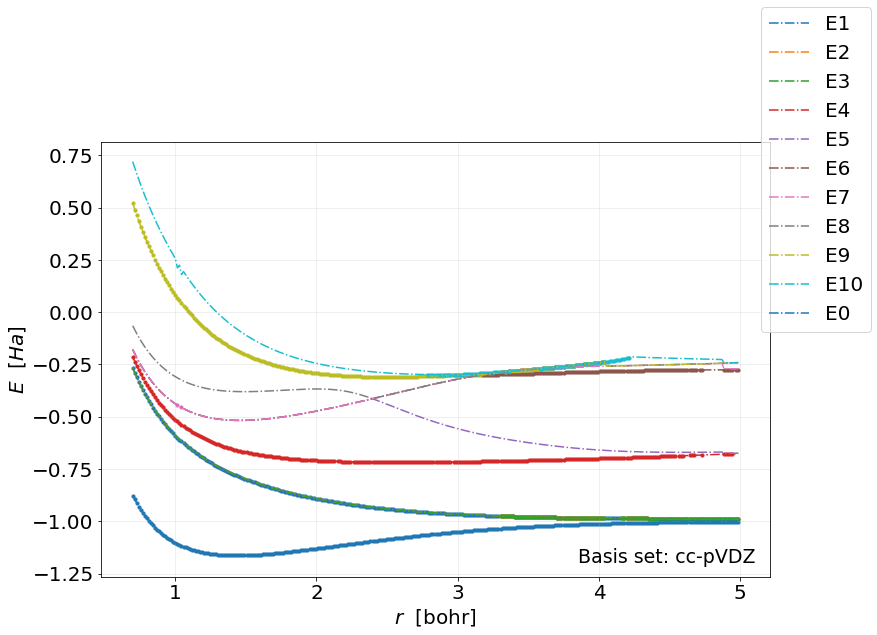

In [16]:
plotfunction_diatomic_exc([RJ,RJ],[EEOM,ECC],basis,eom_conv,[['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10'],'E0'])

In [17]:
# function [x, error, iter, flag] = gmres( A, x, b, M, restrt, max_it, tol )

# %  -- Iterative template routine --
# %     Univ. of Tennessee and Oak Ridge National Laboratory
# %     October 1, 1993
# %     Details of this algorithm are described in "Templates for the
# %     Solution of Linear Systems: Building Blocks for Iterative
# %     Methods", Barrett, Berry, Chan, Demmel, Donato, Dongarra,
# %     Eijkhout, Pozo, Romine, and van der Vorst, SIAM Publications,
# %     1993. (ftp netlib2.cs.utk.edu; cd linalg; get templates.ps).
# %
# % [x, error, iter, flag] = gmres( A, x, b, M, restrt, max_it, tol )
# %
# % gmres.m solves the linear system Ax=b
# % using the Generalized Minimal residual ( GMRESm ) method with restarts .
# %
# % input   A        REAL nonsymmetric positive definite matrix
# %         x        REAL initial guess vector
# %         b        REAL right hand side vector
# %         M        REAL preconditioner matrix
# %         restrt   INTEGER number of iterations between restarts
# %         max_it   INTEGER maximum number of iterations
# %         tol      REAL error tolerance
# %
# % output  x        REAL solution vector
# %         error    REAL error norm
# %         iter     INTEGER number of iterations performed
# %         flag     INTEGER: 0 = solution found to tolerance
# %                           1 = no convergence given max_it

#    iter = 0;                                         % initialization
#    flag = 0;

#    bnrm2 = norm( b );
#    if  ( bnrm2 == 0.0 ), bnrm2 = 1.0; end

#    r = M \ ( b-A*x );
#    error = norm( r ) / bnrm2;
#    if ( error < tol ) return, end

#    [n,n] = size(A);                                  % initialize workspace
#    m = restrt;
#    V(1:n,1:m+1) = zeros(n,m+1);
#    H(1:m+1,1:m) = zeros(m+1,m);
#    cs(1:m) = zeros(m,1);
#    sn(1:m) = zeros(m,1);
#    e1    = zeros(n,1);
#    e1(1) = 1.0;

#    for iter = 1:max_it,                              % begin iteration

#       r = M \ ( b-A*x );
#       V(:,1) = r / norm( r );
#       s = norm( r )*e1;
#       for i = 1:m,                                   % construct orthonormal
# 	 w = M \ (A*V(:,i));                         % basis using Gram-Schmidt
# 	 for k = 1:i,
# 	   H(k,i)= w'*V(:,k);
# 	   w = w - H(k,i)*V(:,k);
# 	 end
# 	 H(i+1,i) = norm( w );
# 	 V(:,i+1) = w / H(i+1,i);
# 	 for k = 1:i-1,                              % apply Givens rotation
#             temp     =  cs(k)*H(k,i) + sn(k)*H(k+1,i);
#             H(k+1,i) = -sn(k)*H(k,i) + cs(k)*H(k+1,i);
#             H(k,i)   = temp;
# 	 end
# 	 [cs(i),sn(i)] = rotmat( H(i,i), H(i+1,i) ); % form i-th rotation matrix
#          temp   = cs(i)*s(i);                        % approximate residual norm
#          s(i+1) = -sn(i)*s(i);
# 	 s(i)   = temp;
#          H(i,i) = cs(i)*H(i,i) + sn(i)*H(i+1,i);
#          H(i+1,i) = 0.0;
# 	 error  = abs(s(i+1)) / bnrm2;
# 	 if ( error <= tol ),                        % update approximation
# 	    y = H(1:i,1:i) \ s(1:i);                 % and exit
#             x = x + V(:,1:i)*y;
# 	    break;
# 	 end
#       end

#       if ( error <= tol ), break, end
#       y = H(1:m,1:m) \ s(1:m);
#       x = x + V(:,1:m)*y;                            % update approximation
#       r = M \ ( b-A*x )                              % compute residual
#       s(i+1) = norm(r);
#       error = s(i+1) / bnrm2;                        % check convergence
#       if ( error <= tol ), break, end;
#    end

#    if ( error > tol ) flag = 1; end;                 % converged

# % END of gmres.m

# function [ c, s ] = rotmat( a, b )

# %
# % Compute the Givens rotation matrix parameters for a and b.
# %
#    if ( b == 0.0 ),
#       c = 1.0;
#       s = 0.0;
#    elseif ( abs(b) > abs(a) ),
#       temp = a / b;
#       s = 1.0 / sqrt( 1.0 + temp^2 );
#       c = temp * s;
#    else
#       temp = b / a;
#       c = 1.0 / sqrt( 1.0 + temp^2 );
#       s = temp * c;
#    end